In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#load data 
data=pd.read_csv('C:/Users/jiema/Documents/data/Mnist/train.csv')
tests=pd.read_csv('C:/Users/jiema/Documents/data/Mnist/test.csv')

trains=data.iloc[:,1:].values
labels=data.iloc[:,:1].values
test=tests.iloc[:,:].values

In [2]:
class VAE:
    '''#### VAE model ####
    VAE is composed of 2 parts: 1.Encoder, 2.Decoder. 
    For this VAE model, both Encoder and Decoder employ 2 layers MLP network with activation function: softplus
    Loss function follows the original papaer as: KL loss - cross entropy. 
    KL loss is defined as distribution distance between latent posterior probability P(z|x) and proposed posterior probability Q(z|x)
    corss entropy is to caculate error between orginial image and generated image
    Args:
       input_size: image dimension (28*28)
       encoder_layer_x: encoder MLP layer x output size
       decoder_layer_x: decoder MLP layer x output size
       z_size: latent coder dimension
    '''
    def __init__(self,**param_size):
        self.data_size=param_size.get('input_size',784)
        self.encoder_layer_1=param_size.get('Encoder_layer_1',500)
        self.encoder_layer_2=param_size.get('Encoder_layer_2',500)
        self.decoder_layer_1=param_size.get('Decoder_layer_1',500)
        self.decoder_layer_2=param_size.get('Decoder_layer_2',500)
        self.z_size=param_size.get('z_size',20)
        self.lr=param_size.get('learning_rate',0.001)
        self.batch_size=param_size.get('batch_size',64)
        self.X=tf.placeholder(dtype=tf.float32,shape=[None,self.data_size])
        self.Z=tf.placeholder(dtype=tf.float32,shape=[None,self.z_size])
        
    def _get_weights(self,input_size,output_size):
        val=tf.sqrt(6./(input_size+output_size))
        w=tf.get_variable(name='weights',shape=[input_size,output_size],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())
        b=tf.get_variable(name='bias',shape=[output_size],dtype=tf.float32,initializer=tf.constant_initializer(0.))
        return (w,b)
    
    def _build_full_layers(self,data,ins,outs,name):
        with tf.variable_scope(name):
            (w,b)=self._get_weights(ins,outs)
            output=tf.matmul(data,w)+b
        return output
    
    def Encoder(self,reuse):
        with tf.variable_scope('Encoder',reuse=reuse):
            out1=self._build_full_layers(self.X,self.data_size,self.encoder_layer_1,name='encoder_layer1')
            out1=tf.nn.softplus(out1)
            out2=self._build_full_layers(out1,self.encoder_layer_1,self.encoder_layer_2,name='encoder_layer2')
            out2=tf.nn.softplus(out2)
            z_mean=self._build_full_layers(out2,self.encoder_layer_2,self.z_size,name='latent_mean')
            z_var=self._build_full_layers(out2,self.encoder_layer_2,self.z_size,name='latent_var')
        return z_mean,z_var
        
    def Decoder(self,z,reuse):
        with tf.variable_scope('Decoder',reuse=reuse):
            out1=self._build_full_layers(z,self.z_size,self.decoder_layer_1,name='decoder_layer1')
            out1=tf.nn.softplus(out1)
            out2=self._build_full_layers(out1,self.decoder_layer_1,self.decoder_layer_2,name='decoder_layer2')
            out2=tf.nn.softplus(out2)
            output=self._build_full_layers(out2,self.decoder_layer_2,self.data_size,name='output_layer')
            output=tf.nn.sigmoid(output)
        return output
        
    def cost(self,reuse):
        z_mean,z_var=self.Encoder(reuse)
        eps=tf.random_normal((self.batch_size,self.z_size),0,1,dtype=tf.float32)
        z=tf.add(z_mean,tf.multiply(tf.sqrt(tf.exp(z_var)),eps))
        x_=self.Decoder(z,reuse)
        KL_loss=-0.5*tf.reduce_sum(1.+z_var-tf.square(z_mean)-tf.exp(z_var),1) #KL divergence 
        E_loss=-tf.reduce_sum(self.X*tf.log(1e-10+x_)+(1.-self.X)*tf.log(1e-10+1.-x_),1) #cross entropy
        KL_loss=tf.reduce_mean(KL_loss)
        E_loss=tf.reduce_mean(E_loss)
        cost=KL_loss+E_loss #Loss: KL - cross entropy
        return cost,x_,E_loss,KL_loss
    
    def train(self,reuse):
        cost,x_,E_loss,KL_loss=self.cost(reuse)
        op=tf.train.AdamOptimizer(learning_rate=self.lr)
        train_op=op.minimize(cost)
        encoder_var_list=[]
        decoder_var_list=[]
        for var in tf.trainable_variables():
            if 'Encoder' in var.name:
                encoder_var_list.append(var)
            elif 'Decoder' in var.name:
                decoder_var_list.append(var)
        
        optim_e=tf.train.AdamOptimizer(learning_rate=self.lr).minimize(E_loss,var_list=decoder_var_list)
        optim_kl=tf.train.AdamOptimizer(learning_rate=self.lr).minimize(KL_loss,var_list=encoder_var_list)
        return train_op,cost,E_loss,KL_loss,optim_e,optim_kl
    
    def generate(self,reuse):
        x_=self.Decoder(self.Z,reuse)
        return x_

In [3]:
def train(x,vae,epoch):
    ''' Train VAE'''
    train_op,loss,E_loss,KL_loss,optim_e,optim_kl=vae.train(reuse=False)
    x_reconstruct=myvae.generate(reuse=True)
    m=len(x)
    total_batch=m//vae.batch_size
    init=tf.global_variables_initializer()
    saver=tf.train.Saver(tf.all_variables())
    with tf.Session() as sess:
        sess.run(init)
        e=0
        while e<epoch:
            vae.lr=0.001
            for i in range(total_batch):
                curr_batch=x[i*vae.batch_size:(i+1)*vae.batch_size]
                #_,e_l=sess.run([optim_e,E_loss],{vae.X:curr_batch})
                #_,kl=sess.run([optim_kl,KL_loss],{vae.X:curr_batch})
                _,cost,e_loss,kl=sess.run([train_op,loss,E_loss,KL_loss],feed_dict={vae.X:curr_batch})
                #if i%2==0:
                    #vae.lr*=0.97**(i/2)
                if e%2==0 and i%50==0:
                    print('***epoch {}, step {}: total loss: {}, E_loss: {}, KL_loss:{}'.format(e,i,cost,e_loss,kl))
                if i%100==0:
                    x_r=sess.run(x_reconstruct,{myvae.Z:np.random.normal(size=(1,myvae.z_size))})
                    img=x_r[0]
                    print('**********result at Epoch {} Step {}*************'.format(e,i))
                    plt.imshow(img.reshape(28,28))
                    plt.show()
            e+=1    
        saver.save(sess,os.path.join(os.getcwd(),'B_2_VAE.ckpt'))       

Instructions for updating:
Please use tf.global_variables instead.
***epoch 0, step 0: total loss: 717.62939453125, E_loss: 598.0335693359375, KL_loss:119.59584045410156
**********result at Epoch 0 Step 0*************


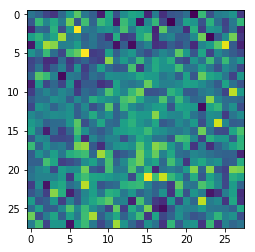

***epoch 0, step 50: total loss: 209.60662841796875, E_loss: 209.60659790039062, KL_loss:2.682685953914188e-05
***epoch 0, step 100: total loss: 205.2115020751953, E_loss: 205.21148681640625, KL_loss:2.0272134861443192e-05
**********result at Epoch 0 Step 100*************


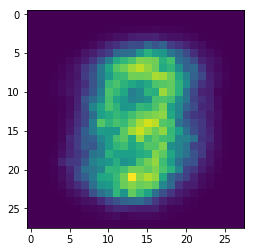

***epoch 0, step 150: total loss: 199.32070922851562, E_loss: 199.3203125, KL_loss:0.00039173185359686613
***epoch 0, step 200: total loss: 208.86578369140625, E_loss: 208.8650665283203, KL_loss:0.0007224100409075618
**********result at Epoch 0 Step 200*************


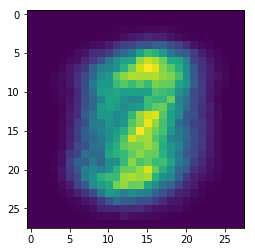

***epoch 0, step 250: total loss: 206.99249267578125, E_loss: 206.99114990234375, KL_loss:0.0013368537183851004
***epoch 0, step 300: total loss: 209.5709686279297, E_loss: 209.56190490722656, KL_loss:0.009069657884538174
**********result at Epoch 0 Step 300*************


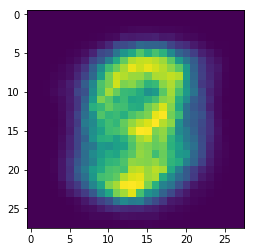

***epoch 0, step 350: total loss: 210.50767517089844, E_loss: 210.33999633789062, KL_loss:0.16767369210720062
***epoch 0, step 400: total loss: 196.2625274658203, E_loss: 194.23699951171875, KL_loss:2.0255327224731445
**********result at Epoch 0 Step 400*************


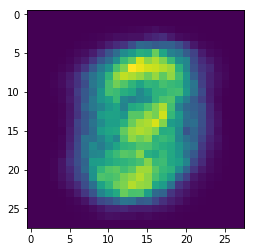

**********result at Epoch 1 Step 0*************


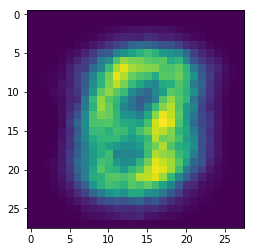

**********result at Epoch 1 Step 100*************


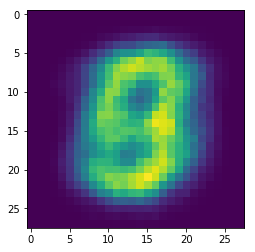

**********result at Epoch 1 Step 200*************


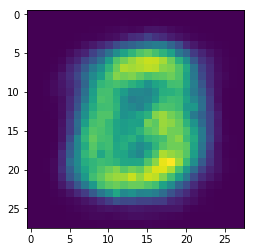

**********result at Epoch 1 Step 300*************


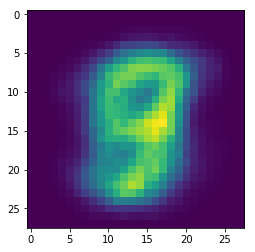

**********result at Epoch 1 Step 400*************


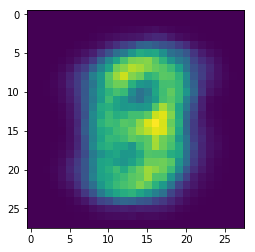

***epoch 2, step 0: total loss: 186.85501098632812, E_loss: 182.06251525878906, KL_loss:4.7925004959106445
**********result at Epoch 2 Step 0*************


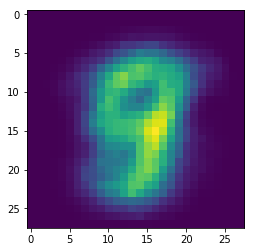

***epoch 2, step 50: total loss: 192.11807250976562, E_loss: 187.87477111816406, KL_loss:4.2433061599731445
***epoch 2, step 100: total loss: 187.11009216308594, E_loss: 181.55709838867188, KL_loss:5.552997589111328
**********result at Epoch 2 Step 100*************


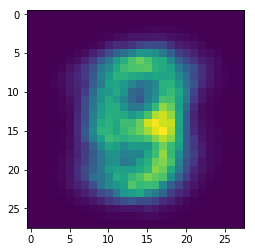

***epoch 2, step 150: total loss: 178.8859405517578, E_loss: 172.374267578125, KL_loss:6.5116682052612305
***epoch 2, step 200: total loss: 184.4061279296875, E_loss: 176.16607666015625, KL_loss:8.240056991577148
**********result at Epoch 2 Step 200*************


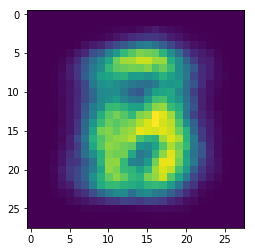

***epoch 2, step 250: total loss: 186.36256408691406, E_loss: 180.34127807617188, KL_loss:6.021289825439453
***epoch 2, step 300: total loss: 191.40805053710938, E_loss: 184.6144256591797, KL_loss:6.793622970581055
**********result at Epoch 2 Step 300*************


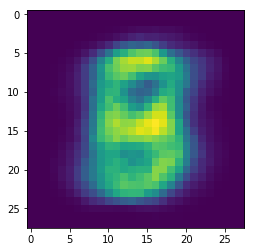

***epoch 2, step 350: total loss: 188.85324096679688, E_loss: 181.59597778320312, KL_loss:7.257255554199219
***epoch 2, step 400: total loss: 176.10792541503906, E_loss: 169.0299072265625, KL_loss:7.0780181884765625
**********result at Epoch 2 Step 400*************


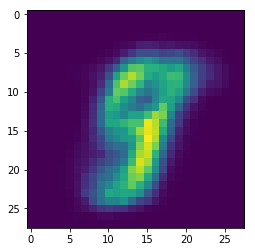

**********result at Epoch 3 Step 0*************


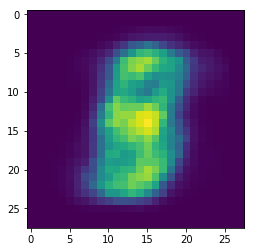

**********result at Epoch 3 Step 100*************


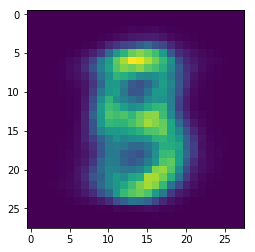

**********result at Epoch 3 Step 200*************


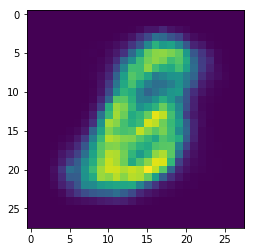

**********result at Epoch 3 Step 300*************


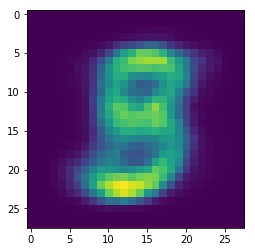

**********result at Epoch 3 Step 400*************


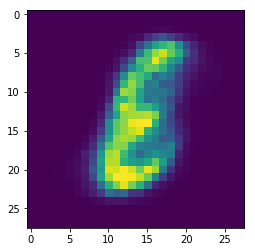

***epoch 4, step 0: total loss: 159.25567626953125, E_loss: 145.34231567382812, KL_loss:13.913359642028809
**********result at Epoch 4 Step 0*************


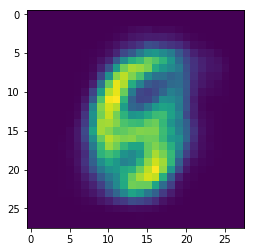

***epoch 4, step 50: total loss: 161.32644653320312, E_loss: 146.58547973632812, KL_loss:14.740968704223633
***epoch 4, step 100: total loss: 162.47320556640625, E_loss: 147.69114685058594, KL_loss:14.782060623168945
**********result at Epoch 4 Step 100*************


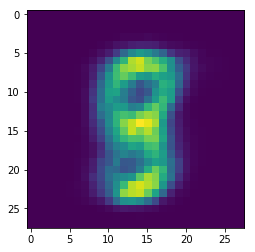

***epoch 4, step 150: total loss: 150.0605926513672, E_loss: 134.42181396484375, KL_loss:15.638772964477539
***epoch 4, step 200: total loss: 156.54737854003906, E_loss: 142.36509704589844, KL_loss:14.18228816986084
**********result at Epoch 4 Step 200*************


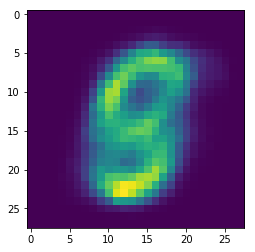

***epoch 4, step 250: total loss: 160.9853973388672, E_loss: 147.1229705810547, KL_loss:13.86242961883545
***epoch 4, step 300: total loss: 163.2616729736328, E_loss: 147.4077911376953, KL_loss:15.853887557983398
**********result at Epoch 4 Step 300*************


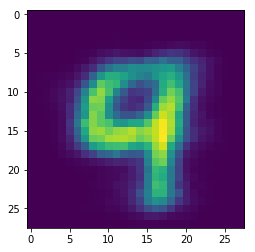

***epoch 4, step 350: total loss: 160.68154907226562, E_loss: 145.56240844726562, KL_loss:15.119147300720215
***epoch 4, step 400: total loss: 156.08270263671875, E_loss: 142.31138610839844, KL_loss:13.771310806274414
**********result at Epoch 4 Step 400*************


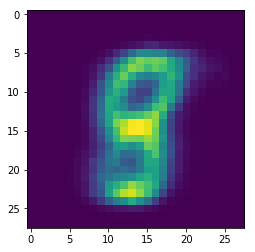

**********result at Epoch 5 Step 0*************


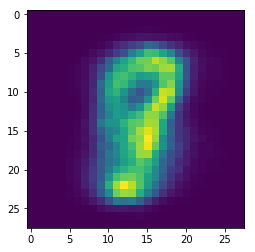

**********result at Epoch 5 Step 100*************


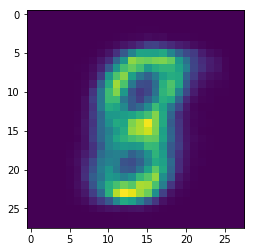

**********result at Epoch 5 Step 200*************


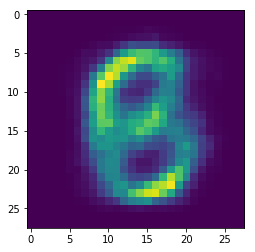

**********result at Epoch 5 Step 300*************


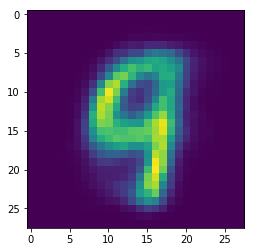

**********result at Epoch 5 Step 400*************


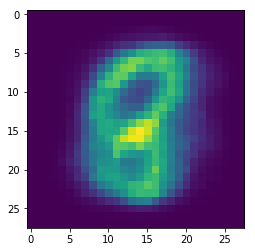

***epoch 6, step 0: total loss: 149.62623596191406, E_loss: 131.98501586914062, KL_loss:17.64121437072754
**********result at Epoch 6 Step 0*************


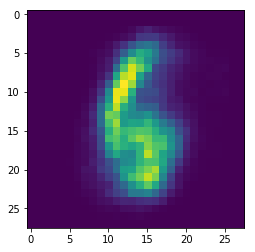

***epoch 6, step 50: total loss: 150.8726806640625, E_loss: 132.5831298828125, KL_loss:18.289552688598633
***epoch 6, step 100: total loss: 151.29824829101562, E_loss: 133.123779296875, KL_loss:18.174474716186523
**********result at Epoch 6 Step 100*************


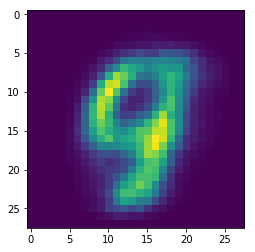

***epoch 6, step 150: total loss: 142.73277282714844, E_loss: 125.6910171508789, KL_loss:17.041751861572266
***epoch 6, step 200: total loss: 151.64125061035156, E_loss: 134.24424743652344, KL_loss:17.397008895874023
**********result at Epoch 6 Step 200*************


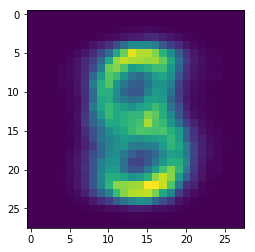

***epoch 6, step 250: total loss: 153.20274353027344, E_loss: 135.7655029296875, KL_loss:17.43723487854004
***epoch 6, step 300: total loss: 154.10833740234375, E_loss: 135.681396484375, KL_loss:18.42694091796875
**********result at Epoch 6 Step 300*************


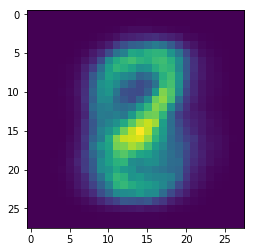

***epoch 6, step 350: total loss: 154.2723846435547, E_loss: 135.75289916992188, KL_loss:18.519485473632812
***epoch 6, step 400: total loss: 151.13729858398438, E_loss: 134.87002563476562, KL_loss:16.26726531982422
**********result at Epoch 6 Step 400*************


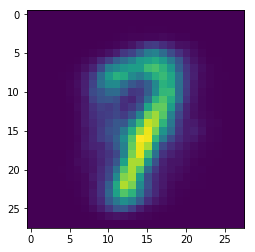

**********result at Epoch 7 Step 0*************


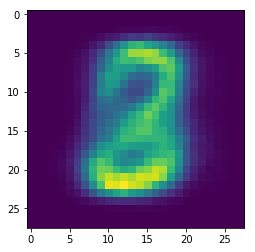

**********result at Epoch 7 Step 100*************


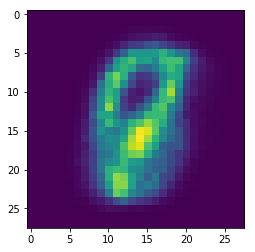

**********result at Epoch 7 Step 200*************


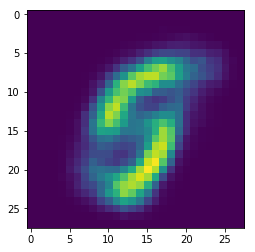

**********result at Epoch 7 Step 300*************


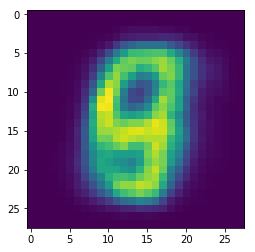

**********result at Epoch 7 Step 400*************


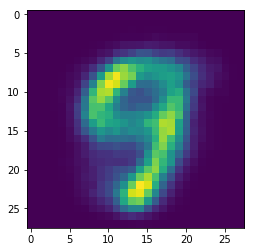

***epoch 8, step 0: total loss: 144.0394287109375, E_loss: 125.24551391601562, KL_loss:18.793912887573242
**********result at Epoch 8 Step 0*************


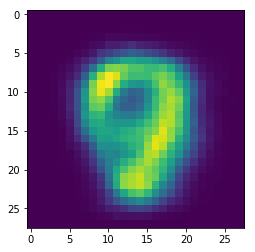

***epoch 8, step 50: total loss: 148.90528869628906, E_loss: 129.41012573242188, KL_loss:19.49515724182129
***epoch 8, step 100: total loss: 144.9048309326172, E_loss: 125.67357635498047, KL_loss:19.231260299682617
**********result at Epoch 8 Step 100*************


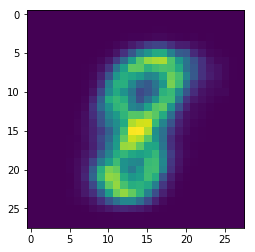

***epoch 8, step 150: total loss: 131.96768188476562, E_loss: 113.86264038085938, KL_loss:18.10503578186035
***epoch 8, step 200: total loss: 145.170166015625, E_loss: 127.46701049804688, KL_loss:17.703161239624023
**********result at Epoch 8 Step 200*************


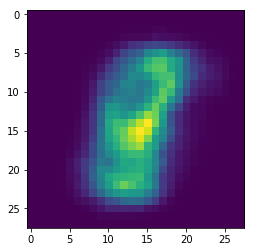

***epoch 8, step 250: total loss: 146.9866180419922, E_loss: 128.88394165039062, KL_loss:18.102680206298828
***epoch 8, step 300: total loss: 147.8323211669922, E_loss: 127.7503662109375, KL_loss:20.081951141357422
**********result at Epoch 8 Step 300*************


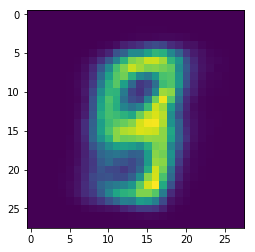

***epoch 8, step 350: total loss: 149.00196838378906, E_loss: 129.6022186279297, KL_loss:19.39975357055664
***epoch 8, step 400: total loss: 144.7147674560547, E_loss: 127.12608337402344, KL_loss:17.588687896728516
**********result at Epoch 8 Step 400*************


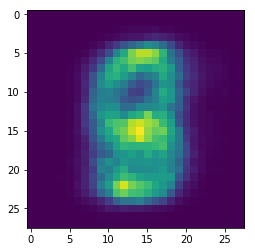

**********result at Epoch 9 Step 0*************


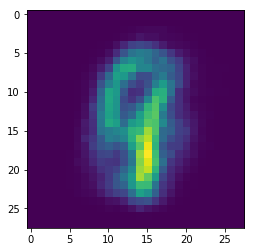

**********result at Epoch 9 Step 100*************


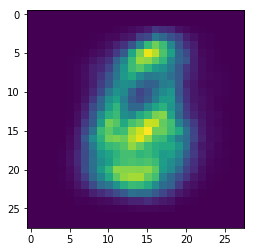

**********result at Epoch 9 Step 200*************


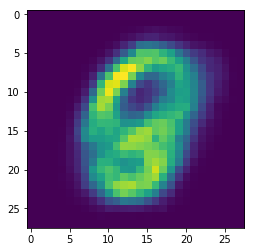

**********result at Epoch 9 Step 300*************


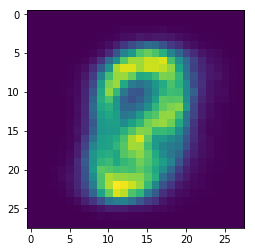

**********result at Epoch 9 Step 400*************


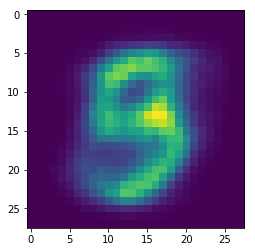

***epoch 10, step 0: total loss: 142.7874298095703, E_loss: 122.44961547851562, KL_loss:20.337814331054688
**********result at Epoch 10 Step 0*************


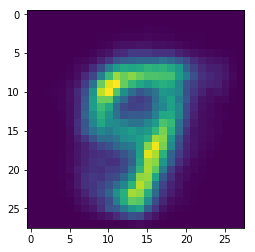

***epoch 10, step 50: total loss: 140.73089599609375, E_loss: 121.28694152832031, KL_loss:19.443946838378906
***epoch 10, step 100: total loss: 138.85311889648438, E_loss: 119.28054809570312, KL_loss:19.57256317138672
**********result at Epoch 10 Step 100*************


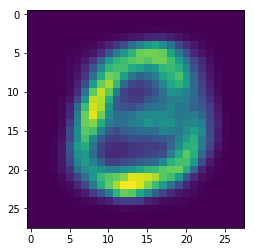

***epoch 10, step 150: total loss: 131.43299865722656, E_loss: 111.6627426147461, KL_loss:19.770254135131836
***epoch 10, step 200: total loss: 141.59030151367188, E_loss: 122.39833068847656, KL_loss:19.19197654724121
**********result at Epoch 10 Step 200*************


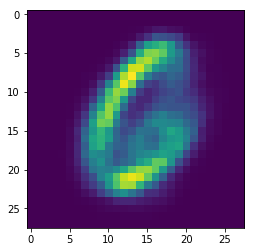

***epoch 10, step 250: total loss: 143.3791046142578, E_loss: 123.77681732177734, KL_loss:19.60228157043457
***epoch 10, step 300: total loss: 145.57412719726562, E_loss: 124.2052001953125, KL_loss:21.368927001953125
**********result at Epoch 10 Step 300*************


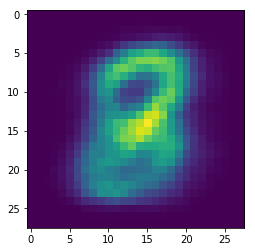

***epoch 10, step 350: total loss: 147.43934631347656, E_loss: 127.6545639038086, KL_loss:19.784786224365234
***epoch 10, step 400: total loss: 142.97190856933594, E_loss: 123.9910888671875, KL_loss:18.980819702148438
**********result at Epoch 10 Step 400*************


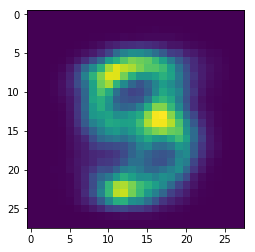

**********result at Epoch 11 Step 0*************


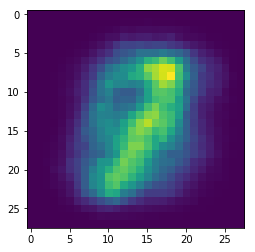

**********result at Epoch 11 Step 100*************


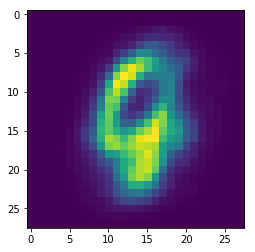

**********result at Epoch 11 Step 200*************


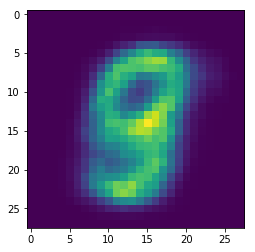

**********result at Epoch 11 Step 300*************


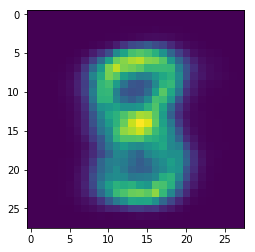

**********result at Epoch 11 Step 400*************


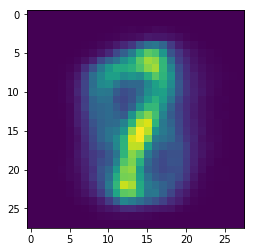

***epoch 12, step 0: total loss: 136.99752807617188, E_loss: 116.96324157714844, KL_loss:20.034290313720703
**********result at Epoch 12 Step 0*************


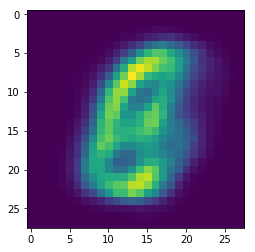

***epoch 12, step 50: total loss: 140.97349548339844, E_loss: 121.0947265625, KL_loss:19.878765106201172
***epoch 12, step 100: total loss: 139.683837890625, E_loss: 119.53585052490234, KL_loss:20.147985458374023
**********result at Epoch 12 Step 100*************


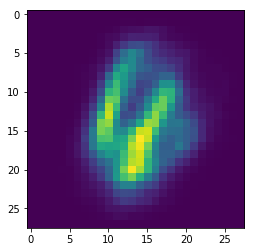

***epoch 12, step 150: total loss: 134.29908752441406, E_loss: 114.58872985839844, KL_loss:19.71035385131836
***epoch 12, step 200: total loss: 136.14505004882812, E_loss: 116.2231674194336, KL_loss:19.921886444091797
**********result at Epoch 12 Step 200*************


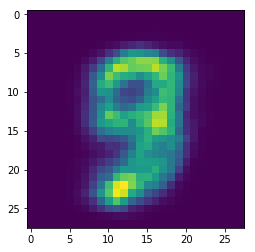

***epoch 12, step 250: total loss: 142.2278594970703, E_loss: 122.33782958984375, KL_loss:19.890033721923828
***epoch 12, step 300: total loss: 142.36521911621094, E_loss: 121.02639770507812, KL_loss:21.338821411132812
**********result at Epoch 12 Step 300*************


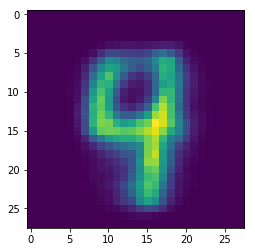

***epoch 12, step 350: total loss: 145.72720336914062, E_loss: 125.39442443847656, KL_loss:20.332786560058594
***epoch 12, step 400: total loss: 139.95814514160156, E_loss: 120.63249969482422, KL_loss:19.325639724731445
**********result at Epoch 12 Step 400*************


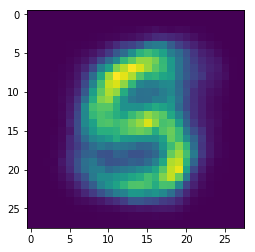

**********result at Epoch 13 Step 0*************


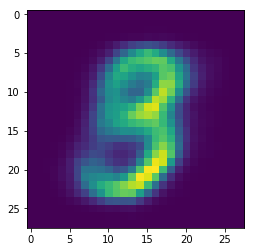

**********result at Epoch 13 Step 100*************


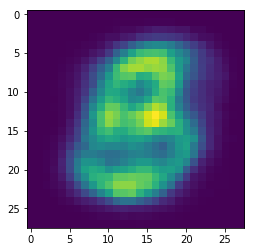

**********result at Epoch 13 Step 200*************


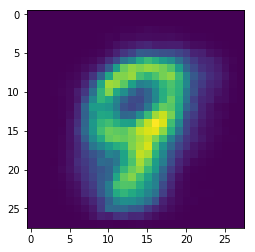

**********result at Epoch 13 Step 300*************


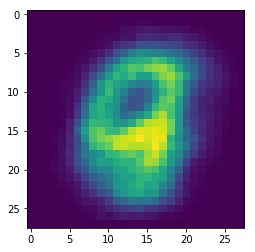

**********result at Epoch 13 Step 400*************


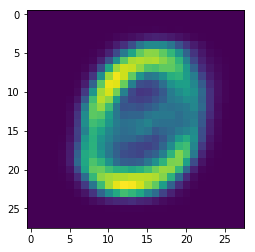

***epoch 14, step 0: total loss: 137.11279296875, E_loss: 115.81603240966797, KL_loss:21.296756744384766
**********result at Epoch 14 Step 0*************


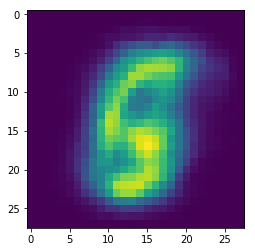

***epoch 14, step 50: total loss: 142.8997344970703, E_loss: 122.08712768554688, KL_loss:20.812610626220703
***epoch 14, step 100: total loss: 140.4896240234375, E_loss: 120.14157104492188, KL_loss:20.348052978515625
**********result at Epoch 14 Step 100*************


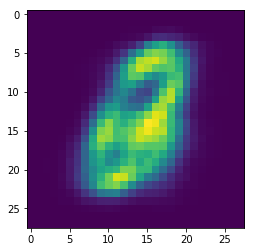

***epoch 14, step 150: total loss: 130.990966796875, E_loss: 111.06820678710938, KL_loss:19.922760009765625
***epoch 14, step 200: total loss: 136.49154663085938, E_loss: 115.35794830322266, KL_loss:21.133590698242188
**********result at Epoch 14 Step 200*************


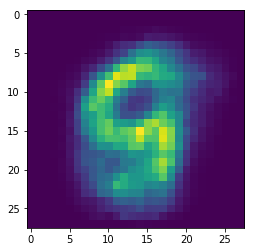

***epoch 14, step 250: total loss: 143.05117797851562, E_loss: 122.7754898071289, KL_loss:20.275691986083984
***epoch 14, step 300: total loss: 142.7795867919922, E_loss: 120.36224365234375, KL_loss:22.417339324951172
**********result at Epoch 14 Step 300*************


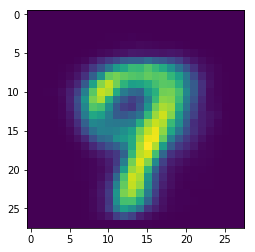

***epoch 14, step 350: total loss: 144.78268432617188, E_loss: 124.07908630371094, KL_loss:20.70359992980957
***epoch 14, step 400: total loss: 138.1649169921875, E_loss: 117.97940063476562, KL_loss:20.185508728027344
**********result at Epoch 14 Step 400*************


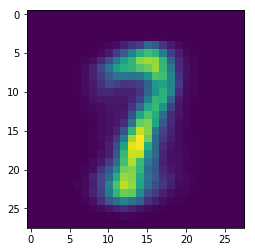

**********result at Epoch 15 Step 0*************


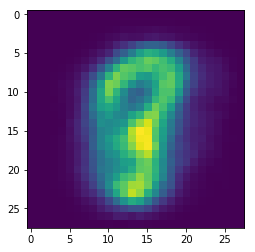

**********result at Epoch 15 Step 100*************


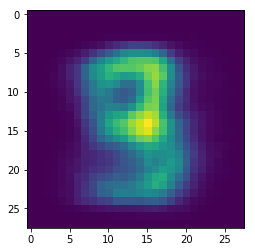

**********result at Epoch 15 Step 200*************


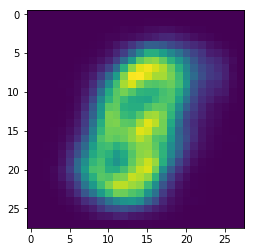

**********result at Epoch 15 Step 300*************


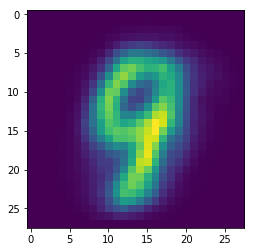

**********result at Epoch 15 Step 400*************


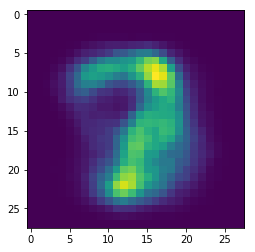

***epoch 16, step 0: total loss: 136.0843048095703, E_loss: 114.5894775390625, KL_loss:21.494829177856445
**********result at Epoch 16 Step 0*************


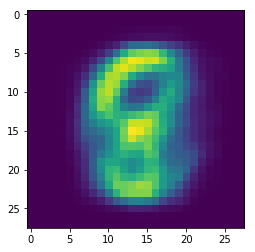

***epoch 16, step 50: total loss: 136.80801391601562, E_loss: 115.8818588256836, KL_loss:20.9261531829834
***epoch 16, step 100: total loss: 136.15960693359375, E_loss: 115.17941284179688, KL_loss:20.980186462402344
**********result at Epoch 16 Step 100*************


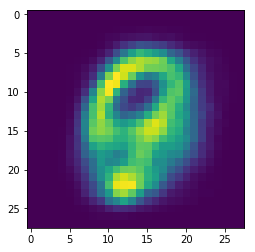

***epoch 16, step 150: total loss: 132.2689208984375, E_loss: 112.6908187866211, KL_loss:19.578109741210938
***epoch 16, step 200: total loss: 136.061767578125, E_loss: 114.66569519042969, KL_loss:21.39607810974121
**********result at Epoch 16 Step 200*************


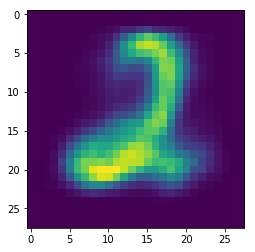

***epoch 16, step 250: total loss: 138.5911407470703, E_loss: 117.4162368774414, KL_loss:21.174903869628906
***epoch 16, step 300: total loss: 141.03564453125, E_loss: 119.47218322753906, KL_loss:21.563465118408203
**********result at Epoch 16 Step 300*************


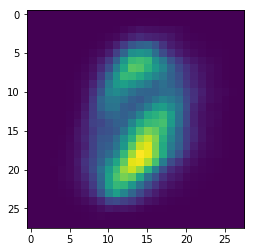

***epoch 16, step 350: total loss: 143.6713409423828, E_loss: 122.26215362548828, KL_loss:21.40919303894043
***epoch 16, step 400: total loss: 138.12351989746094, E_loss: 116.99800109863281, KL_loss:21.125513076782227
**********result at Epoch 16 Step 400*************


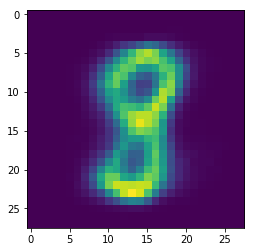

**********result at Epoch 17 Step 0*************


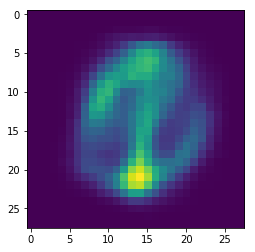

**********result at Epoch 17 Step 100*************


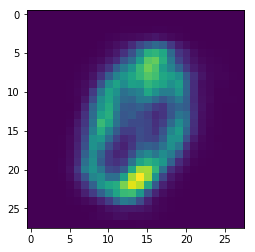

**********result at Epoch 17 Step 200*************


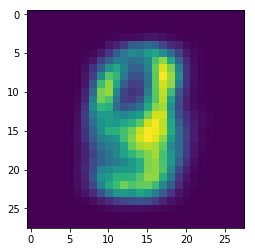

**********result at Epoch 17 Step 300*************


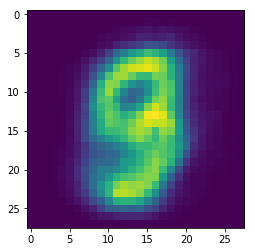

**********result at Epoch 17 Step 400*************


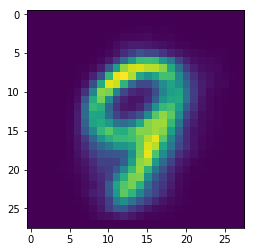

***epoch 18, step 0: total loss: 133.96273803710938, E_loss: 113.21681213378906, KL_loss:20.745933532714844
**********result at Epoch 18 Step 0*************


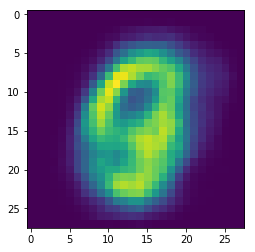

***epoch 18, step 50: total loss: 136.8440704345703, E_loss: 115.38650512695312, KL_loss:21.45755958557129
***epoch 18, step 100: total loss: 136.3018798828125, E_loss: 114.90753173828125, KL_loss:21.39434814453125
**********result at Epoch 18 Step 100*************


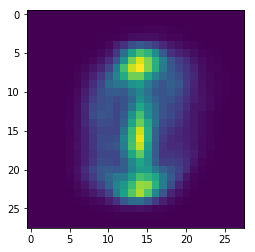

***epoch 18, step 150: total loss: 129.9962158203125, E_loss: 109.98299407958984, KL_loss:20.013219833374023
***epoch 18, step 200: total loss: 138.09478759765625, E_loss: 117.2065658569336, KL_loss:20.888225555419922
**********result at Epoch 18 Step 200*************


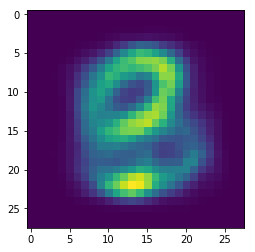

***epoch 18, step 250: total loss: 139.98080444335938, E_loss: 118.60670471191406, KL_loss:21.37409782409668
***epoch 18, step 300: total loss: 139.69422912597656, E_loss: 117.97024536132812, KL_loss:21.72397804260254
**********result at Epoch 18 Step 300*************


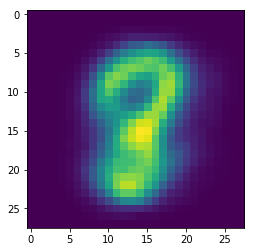

***epoch 18, step 350: total loss: 140.2808380126953, E_loss: 118.867431640625, KL_loss:21.413410186767578
***epoch 18, step 400: total loss: 136.68194580078125, E_loss: 115.74854278564453, KL_loss:20.93340492248535
**********result at Epoch 18 Step 400*************


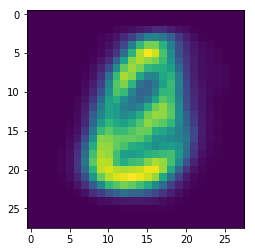

**********result at Epoch 19 Step 0*************


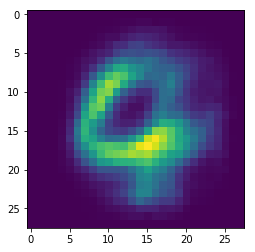

**********result at Epoch 19 Step 100*************


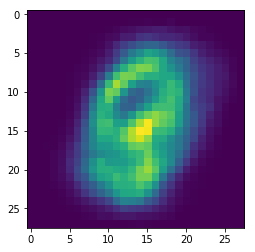

**********result at Epoch 19 Step 200*************


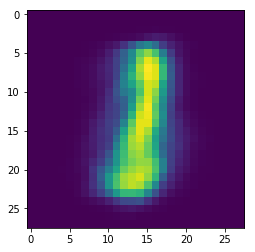

**********result at Epoch 19 Step 300*************


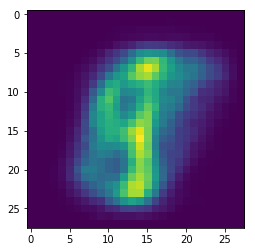

**********result at Epoch 19 Step 400*************


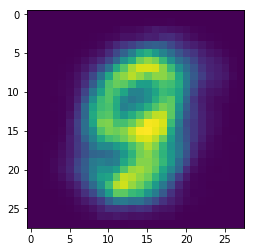

In [4]:
train_f=trains/255
myvae=VAE(batch_size=100,z_size=100)
train(train_f,myvae,100,20)

Instructions for updating:
Please use tf.global_variables instead.
***epoch 0, step 0: total loss: 619.2549438476562, E_loss: 596.646484375, KL_loss:22.608470916748047
**********result at Epoch 0 Step 0*************


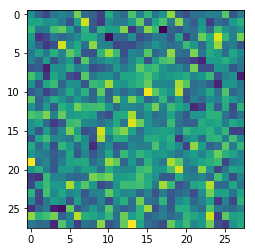

***epoch 0, step 50: total loss: 208.6923828125, E_loss: 208.3041229248047, KL_loss:0.38825446367263794
***epoch 0, step 100: total loss: 194.79159545898438, E_loss: 192.16790771484375, KL_loss:2.6236867904663086
**********result at Epoch 0 Step 100*************


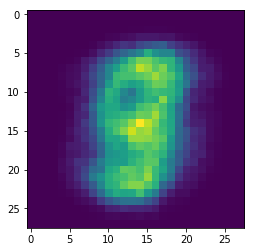

***epoch 0, step 150: total loss: 183.93978881835938, E_loss: 179.89227294921875, KL_loss:4.047512054443359
***epoch 0, step 200: total loss: 181.41697692871094, E_loss: 175.04934692382812, KL_loss:6.3676323890686035
**********result at Epoch 0 Step 200*************


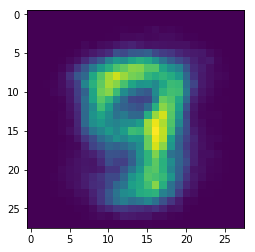

***epoch 0, step 250: total loss: 174.6043701171875, E_loss: 166.66734313964844, KL_loss:7.937028884887695
***epoch 0, step 300: total loss: 166.11119079589844, E_loss: 155.56207275390625, KL_loss:10.549116134643555
**********result at Epoch 0 Step 300*************


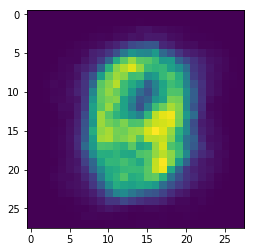

***epoch 0, step 350: total loss: 161.65318298339844, E_loss: 150.52879333496094, KL_loss:11.12438678741455
***epoch 0, step 400: total loss: 148.86184692382812, E_loss: 137.2509002685547, KL_loss:11.61094856262207
**********result at Epoch 0 Step 400*************


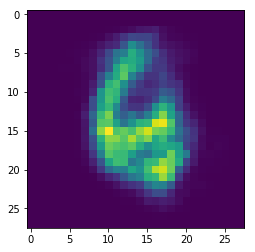

**********result at Epoch 1 Step 0*************


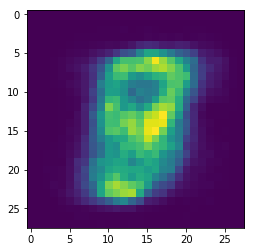

**********result at Epoch 1 Step 100*************


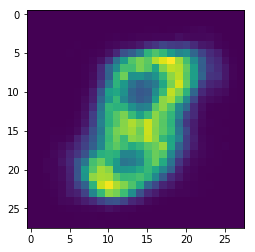

**********result at Epoch 1 Step 200*************


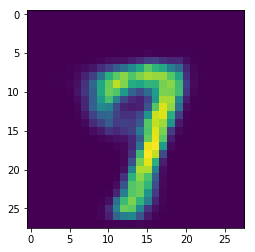

**********result at Epoch 1 Step 300*************


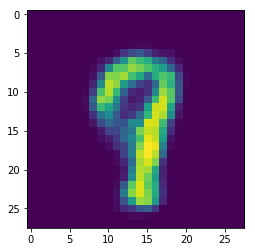

**********result at Epoch 1 Step 400*************


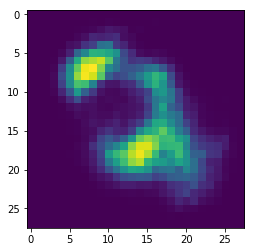

***epoch 2, step 0: total loss: 126.47988891601562, E_loss: 112.27796936035156, KL_loss:14.201919555664062
**********result at Epoch 2 Step 0*************


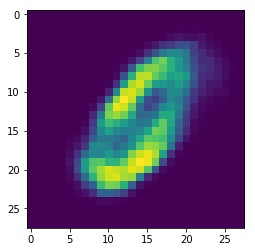

***epoch 2, step 50: total loss: 126.43792724609375, E_loss: 111.89160919189453, KL_loss:14.546319961547852
***epoch 2, step 100: total loss: 122.52985382080078, E_loss: 108.1115951538086, KL_loss:14.418255805969238
**********result at Epoch 2 Step 100*************


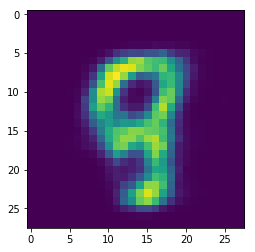

***epoch 2, step 150: total loss: 114.56342315673828, E_loss: 100.25688171386719, KL_loss:14.306539535522461
***epoch 2, step 200: total loss: 120.63612365722656, E_loss: 105.59831237792969, KL_loss:15.037809371948242
**********result at Epoch 2 Step 200*************


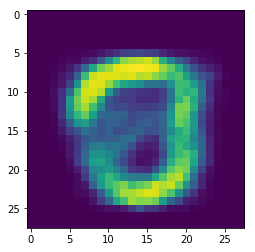

***epoch 2, step 250: total loss: 123.1360855102539, E_loss: 108.03910064697266, KL_loss:15.096985816955566
***epoch 2, step 300: total loss: 123.2757568359375, E_loss: 107.53523254394531, KL_loss:15.74052619934082
**********result at Epoch 2 Step 300*************


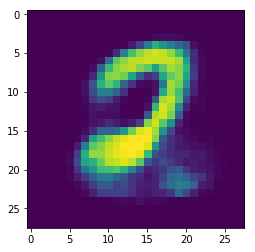

***epoch 2, step 350: total loss: 121.95198822021484, E_loss: 106.20736694335938, KL_loss:15.744621276855469
***epoch 2, step 400: total loss: 120.04248809814453, E_loss: 104.99131774902344, KL_loss:15.051170349121094
**********result at Epoch 2 Step 400*************


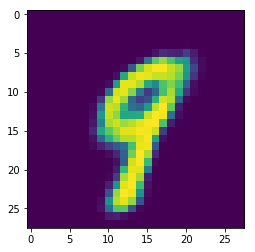

**********result at Epoch 3 Step 0*************


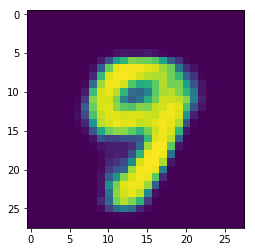

**********result at Epoch 3 Step 100*************


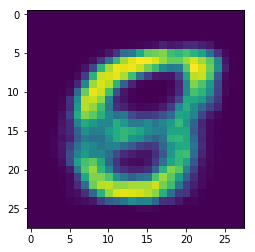

**********result at Epoch 3 Step 200*************


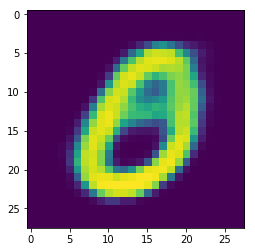

**********result at Epoch 3 Step 300*************


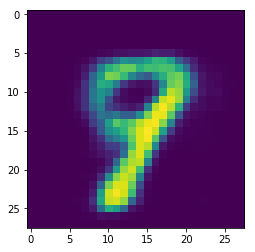

**********result at Epoch 3 Step 400*************


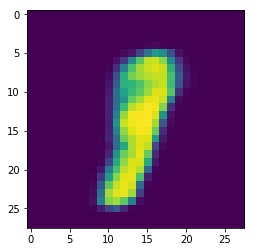

***epoch 4, step 0: total loss: 112.49856567382812, E_loss: 97.08566284179688, KL_loss:15.412903785705566
**********result at Epoch 4 Step 0*************


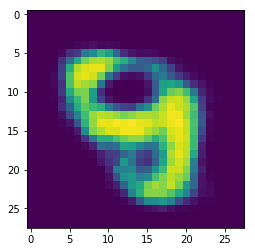

***epoch 4, step 50: total loss: 115.15211486816406, E_loss: 98.75469970703125, KL_loss:16.397418975830078
***epoch 4, step 100: total loss: 111.6722640991211, E_loss: 95.59782409667969, KL_loss:16.07444190979004
**********result at Epoch 4 Step 100*************


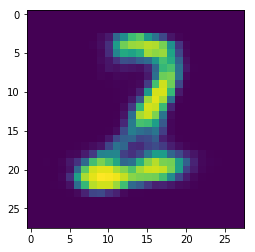

***epoch 4, step 150: total loss: 106.73565673828125, E_loss: 91.083984375, KL_loss:15.651674270629883
***epoch 4, step 200: total loss: 112.62662506103516, E_loss: 96.56575012207031, KL_loss:16.060876846313477
**********result at Epoch 4 Step 200*************


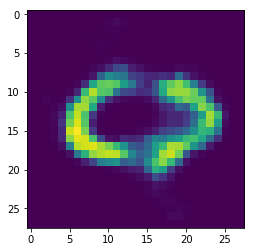

***epoch 4, step 250: total loss: 114.15614318847656, E_loss: 97.620849609375, KL_loss:16.535293579101562
***epoch 4, step 300: total loss: 115.01074981689453, E_loss: 98.48149108886719, KL_loss:16.529258728027344
**********result at Epoch 4 Step 300*************


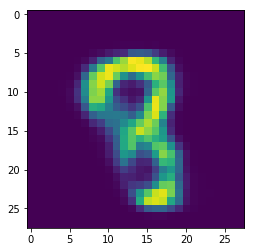

***epoch 4, step 350: total loss: 114.75941467285156, E_loss: 98.13583374023438, KL_loss:16.623579025268555
***epoch 4, step 400: total loss: 112.93515014648438, E_loss: 96.27316284179688, KL_loss:16.6619873046875
**********result at Epoch 4 Step 400*************


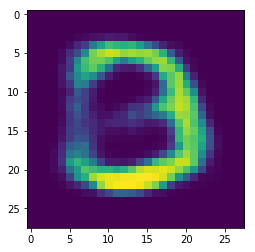

**********result at Epoch 5 Step 0*************


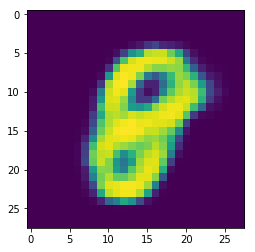

**********result at Epoch 5 Step 100*************


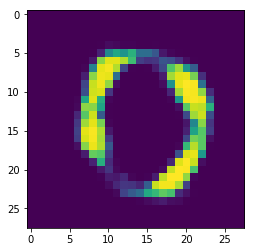

**********result at Epoch 5 Step 200*************


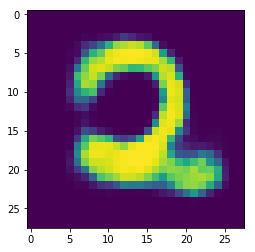

**********result at Epoch 5 Step 300*************


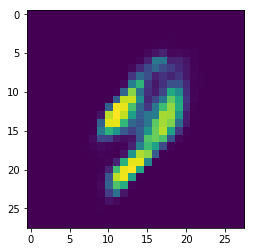

**********result at Epoch 5 Step 400*************


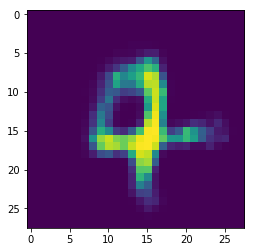

***epoch 6, step 0: total loss: 107.91532897949219, E_loss: 91.57510375976562, KL_loss:16.340229034423828
**********result at Epoch 6 Step 0*************


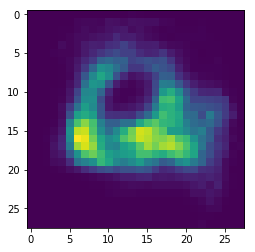

***epoch 6, step 50: total loss: 111.30335998535156, E_loss: 94.01899719238281, KL_loss:17.284364700317383
***epoch 6, step 100: total loss: 108.60023498535156, E_loss: 91.24394226074219, KL_loss:17.356292724609375
**********result at Epoch 6 Step 100*************


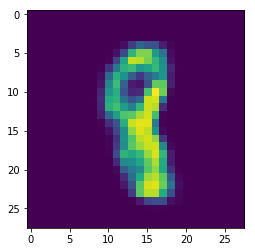

***epoch 6, step 150: total loss: 103.05387878417969, E_loss: 86.32464599609375, KL_loss:16.729232788085938
***epoch 6, step 200: total loss: 107.25779724121094, E_loss: 89.79640197753906, KL_loss:17.46139907836914
**********result at Epoch 6 Step 200*************


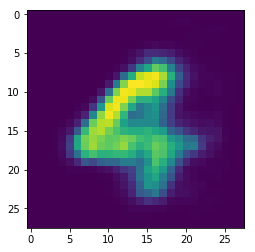

***epoch 6, step 250: total loss: 109.52845764160156, E_loss: 91.71893310546875, KL_loss:17.80952262878418
***epoch 6, step 300: total loss: 111.67469787597656, E_loss: 94.65463256835938, KL_loss:17.020069122314453
**********result at Epoch 6 Step 300*************


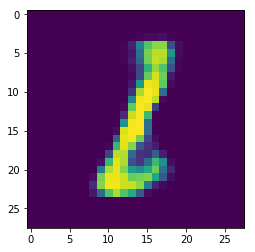

***epoch 6, step 350: total loss: 111.48828125, E_loss: 94.16564178466797, KL_loss:17.32263946533203
***epoch 6, step 400: total loss: 109.7568130493164, E_loss: 92.2021713256836, KL_loss:17.554641723632812
**********result at Epoch 6 Step 400*************


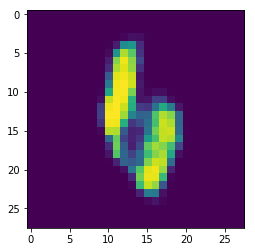

**********result at Epoch 7 Step 0*************


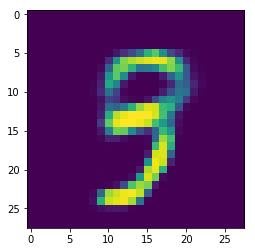

**********result at Epoch 7 Step 100*************


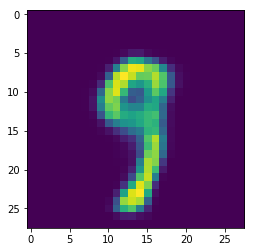

**********result at Epoch 7 Step 200*************


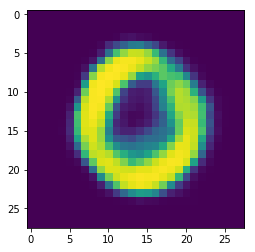

**********result at Epoch 7 Step 300*************


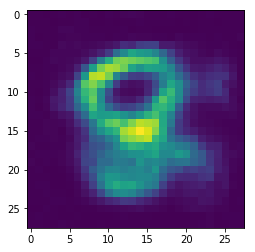

**********result at Epoch 7 Step 400*************


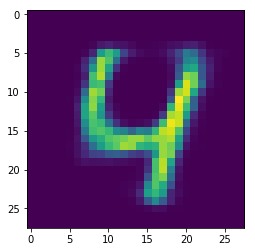

***epoch 8, step 0: total loss: 105.22687530517578, E_loss: 88.072265625, KL_loss:17.15460777282715
**********result at Epoch 8 Step 0*************


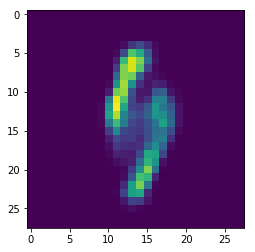

***epoch 8, step 50: total loss: 107.86470031738281, E_loss: 89.9159927368164, KL_loss:17.94870376586914
***epoch 8, step 100: total loss: 105.30596923828125, E_loss: 87.52032470703125, KL_loss:17.78564453125
**********result at Epoch 8 Step 100*************


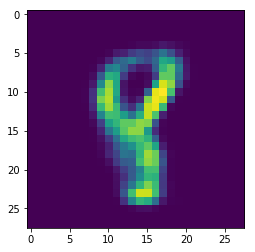

***epoch 8, step 150: total loss: 101.55635070800781, E_loss: 84.1814956665039, KL_loss:17.374858856201172
***epoch 8, step 200: total loss: 104.98274993896484, E_loss: 87.29716491699219, KL_loss:17.685583114624023
**********result at Epoch 8 Step 200*************


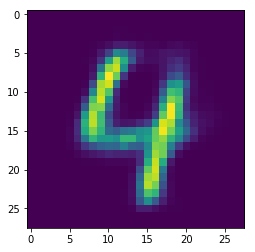

***epoch 8, step 250: total loss: 107.2845458984375, E_loss: 89.30091094970703, KL_loss:17.983633041381836
***epoch 8, step 300: total loss: 108.9336166381836, E_loss: 91.08674621582031, KL_loss:17.84686851501465
**********result at Epoch 8 Step 300*************


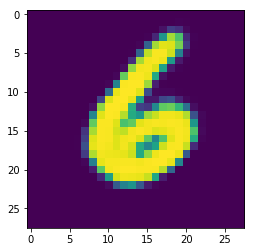

***epoch 8, step 350: total loss: 108.4349136352539, E_loss: 90.24005126953125, KL_loss:18.19486427307129
***epoch 8, step 400: total loss: 106.78645324707031, E_loss: 89.01725769042969, KL_loss:17.76919174194336
**********result at Epoch 8 Step 400*************


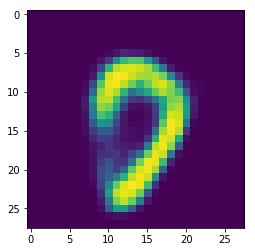

**********result at Epoch 9 Step 0*************


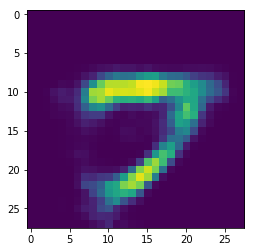

**********result at Epoch 9 Step 100*************


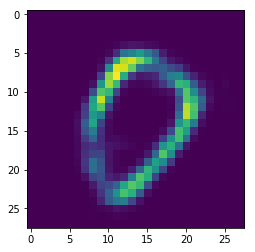

**********result at Epoch 9 Step 200*************


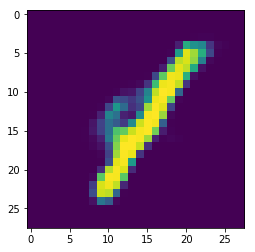

**********result at Epoch 9 Step 300*************


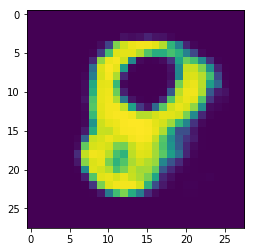

**********result at Epoch 9 Step 400*************


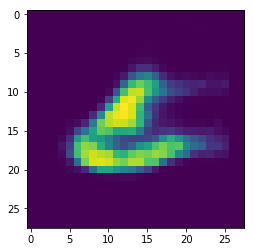

***epoch 10, step 0: total loss: 103.77655792236328, E_loss: 86.36239624023438, KL_loss:17.41416358947754
**********result at Epoch 10 Step 0*************


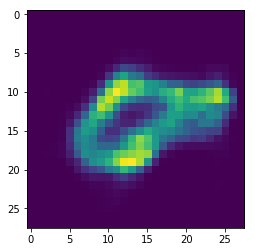

***epoch 10, step 50: total loss: 105.84502410888672, E_loss: 87.812255859375, KL_loss:18.03277015686035
***epoch 10, step 100: total loss: 103.80081939697266, E_loss: 85.68898010253906, KL_loss:18.111841201782227
**********result at Epoch 10 Step 100*************


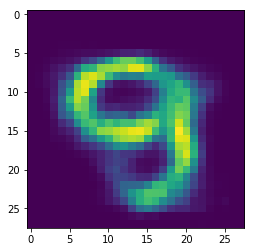

***epoch 10, step 150: total loss: 99.60899353027344, E_loss: 82.170654296875, KL_loss:17.438337326049805
***epoch 10, step 200: total loss: 102.44461059570312, E_loss: 84.54054260253906, KL_loss:17.904064178466797
**********result at Epoch 10 Step 200*************


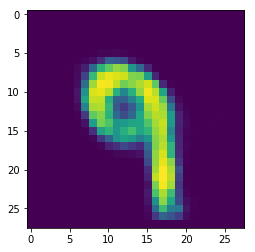

***epoch 10, step 250: total loss: 106.01817321777344, E_loss: 87.6347427368164, KL_loss:18.38343048095703
***epoch 10, step 300: total loss: 107.37654876708984, E_loss: 89.53886413574219, KL_loss:17.837682723999023
**********result at Epoch 10 Step 300*************


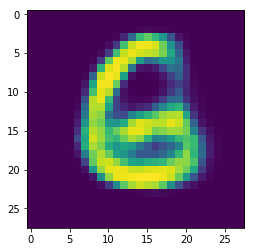

***epoch 10, step 350: total loss: 107.04207611083984, E_loss: 89.14865112304688, KL_loss:17.893423080444336
***epoch 10, step 400: total loss: 106.288330078125, E_loss: 88.3016357421875, KL_loss:17.986698150634766
**********result at Epoch 10 Step 400*************


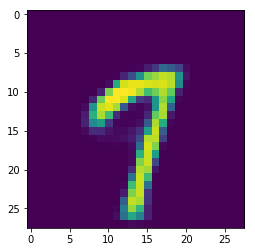

**********result at Epoch 11 Step 0*************


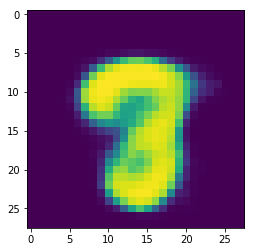

**********result at Epoch 11 Step 100*************


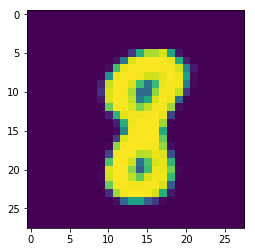

**********result at Epoch 11 Step 200*************


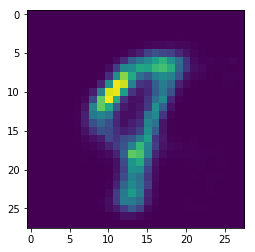

**********result at Epoch 11 Step 300*************


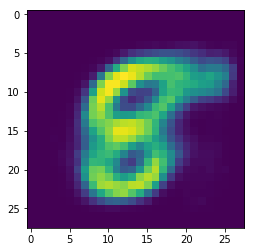

**********result at Epoch 11 Step 400*************


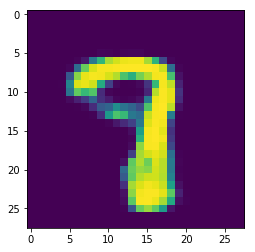

***epoch 12, step 0: total loss: 102.63275909423828, E_loss: 84.86119842529297, KL_loss:17.771560668945312
**********result at Epoch 12 Step 0*************


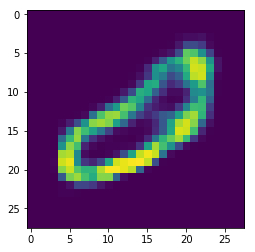

***epoch 12, step 50: total loss: 104.22341918945312, E_loss: 85.59111022949219, KL_loss:18.632307052612305
***epoch 12, step 100: total loss: 102.67367553710938, E_loss: 84.77222442626953, KL_loss:17.901451110839844
**********result at Epoch 12 Step 100*************


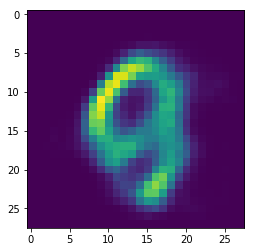

***epoch 12, step 150: total loss: 98.62593078613281, E_loss: 80.99913024902344, KL_loss:17.626802444458008
***epoch 12, step 200: total loss: 101.32431030273438, E_loss: 83.0093994140625, KL_loss:18.314910888671875
**********result at Epoch 12 Step 200*************


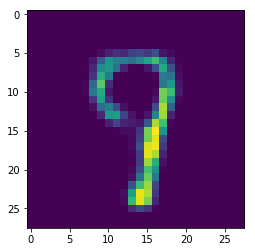

***epoch 12, step 250: total loss: 105.49822235107422, E_loss: 86.77157592773438, KL_loss:18.72664451599121
***epoch 12, step 300: total loss: 106.77981567382812, E_loss: 88.23336791992188, KL_loss:18.546451568603516
**********result at Epoch 12 Step 300*************


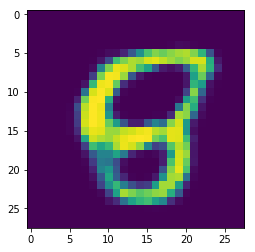

***epoch 12, step 350: total loss: 105.57350158691406, E_loss: 87.08631134033203, KL_loss:18.487194061279297
***epoch 12, step 400: total loss: 105.31991577148438, E_loss: 87.14427185058594, KL_loss:18.175647735595703
**********result at Epoch 12 Step 400*************


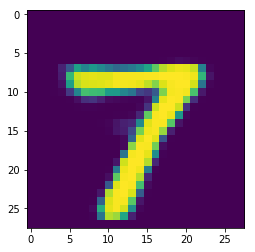

**********result at Epoch 13 Step 0*************


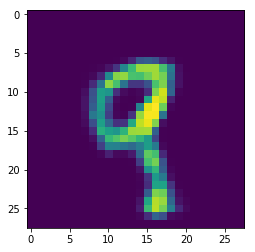

**********result at Epoch 13 Step 100*************


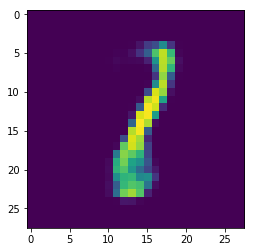

**********result at Epoch 13 Step 200*************


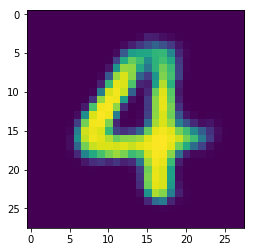

**********result at Epoch 13 Step 300*************


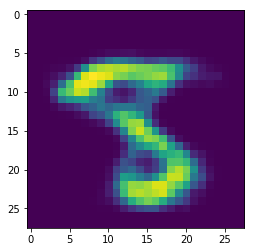

**********result at Epoch 13 Step 400*************


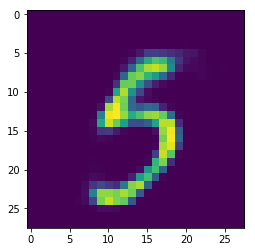

***epoch 14, step 0: total loss: 101.2272720336914, E_loss: 83.55937194824219, KL_loss:17.66790199279785
**********result at Epoch 14 Step 0*************


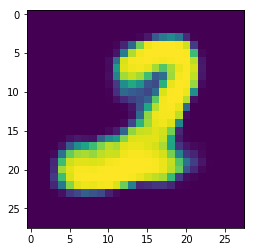

***epoch 14, step 50: total loss: 103.92668151855469, E_loss: 85.5966567993164, KL_loss:18.330028533935547
***epoch 14, step 100: total loss: 101.54987335205078, E_loss: 83.2364501953125, KL_loss:18.313425064086914
**********result at Epoch 14 Step 100*************


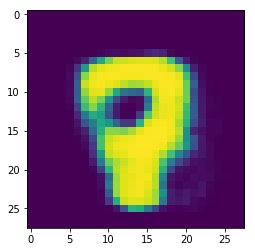

***epoch 14, step 150: total loss: 98.26703643798828, E_loss: 80.61005401611328, KL_loss:17.656980514526367
***epoch 14, step 200: total loss: 101.01296997070312, E_loss: 83.00243377685547, KL_loss:18.010540008544922
**********result at Epoch 14 Step 200*************


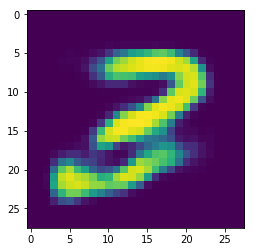

***epoch 14, step 250: total loss: 104.43474578857422, E_loss: 85.93596649169922, KL_loss:18.498779296875
***epoch 14, step 300: total loss: 104.8023910522461, E_loss: 86.36668395996094, KL_loss:18.435707092285156
**********result at Epoch 14 Step 300*************


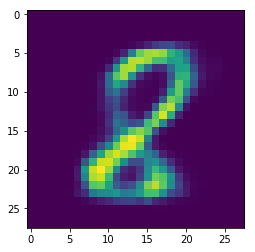

***epoch 14, step 350: total loss: 104.93449401855469, E_loss: 86.26214599609375, KL_loss:18.672346115112305
***epoch 14, step 400: total loss: 104.83248138427734, E_loss: 86.33645629882812, KL_loss:18.49602508544922
**********result at Epoch 14 Step 400*************


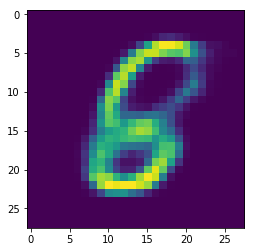

**********result at Epoch 15 Step 0*************


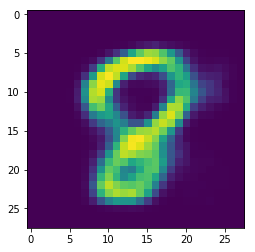

**********result at Epoch 15 Step 100*************


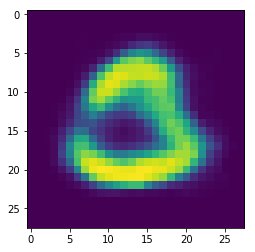

**********result at Epoch 15 Step 200*************


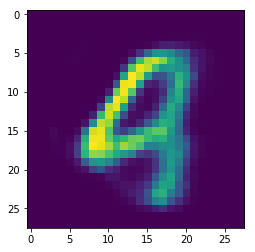

**********result at Epoch 15 Step 300*************


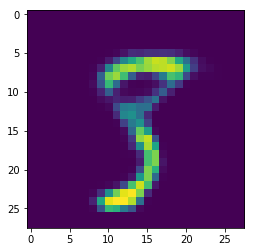

**********result at Epoch 15 Step 400*************


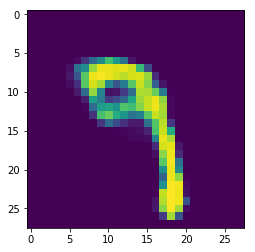

***epoch 16, step 0: total loss: 99.79324340820312, E_loss: 81.65862274169922, KL_loss:18.134620666503906
**********result at Epoch 16 Step 0*************


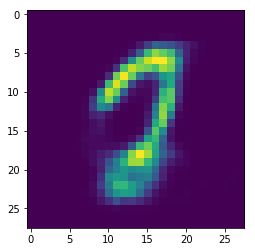

***epoch 16, step 50: total loss: 101.43777465820312, E_loss: 82.57703399658203, KL_loss:18.86074447631836
***epoch 16, step 100: total loss: 101.1708984375, E_loss: 82.45568084716797, KL_loss:18.71521759033203
**********result at Epoch 16 Step 100*************


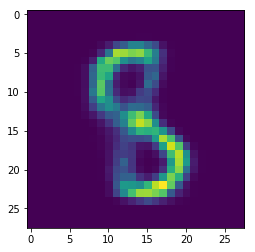

***epoch 16, step 150: total loss: 96.96599578857422, E_loss: 79.2382583618164, KL_loss:17.72773551940918
***epoch 16, step 200: total loss: 100.21858978271484, E_loss: 81.98027801513672, KL_loss:18.238311767578125
**********result at Epoch 16 Step 200*************


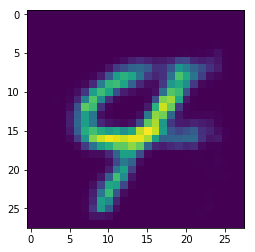

***epoch 16, step 250: total loss: 104.11165618896484, E_loss: 85.50836944580078, KL_loss:18.60328483581543
***epoch 16, step 300: total loss: 104.09254455566406, E_loss: 85.5515365600586, KL_loss:18.54100799560547
**********result at Epoch 16 Step 300*************


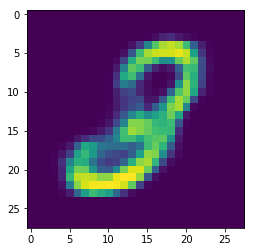

***epoch 16, step 350: total loss: 104.5843505859375, E_loss: 85.73533630371094, KL_loss:18.849010467529297
***epoch 16, step 400: total loss: 103.1586685180664, E_loss: 84.68644714355469, KL_loss:18.472219467163086
**********result at Epoch 16 Step 400*************


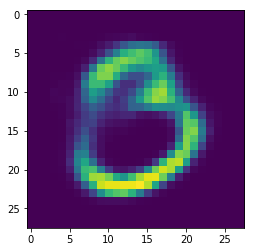

**********result at Epoch 17 Step 0*************


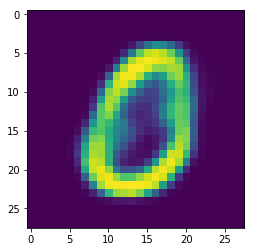

**********result at Epoch 17 Step 100*************


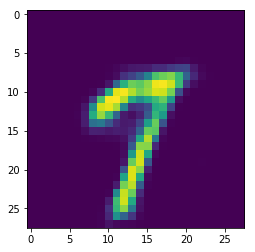

**********result at Epoch 17 Step 200*************


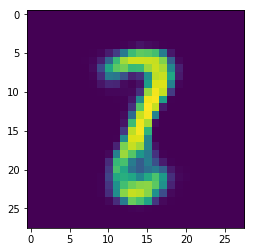

**********result at Epoch 17 Step 300*************


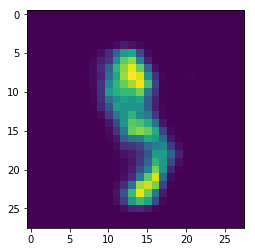

**********result at Epoch 17 Step 400*************


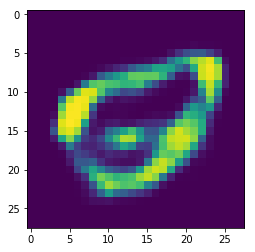

***epoch 18, step 0: total loss: 100.10336303710938, E_loss: 81.94844818115234, KL_loss:18.154916763305664
**********result at Epoch 18 Step 0*************


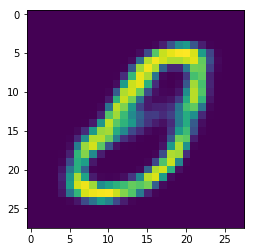

***epoch 18, step 50: total loss: 102.57501220703125, E_loss: 84.03905487060547, KL_loss:18.535953521728516
***epoch 18, step 100: total loss: 100.61956787109375, E_loss: 82.24293518066406, KL_loss:18.376628875732422
**********result at Epoch 18 Step 100*************


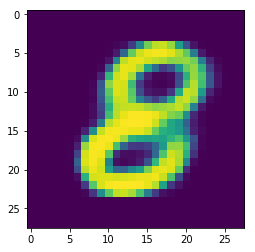

***epoch 18, step 150: total loss: 96.42564392089844, E_loss: 78.3559341430664, KL_loss:18.069705963134766
***epoch 18, step 200: total loss: 99.1209716796875, E_loss: 80.67076873779297, KL_loss:18.45020294189453
**********result at Epoch 18 Step 200*************


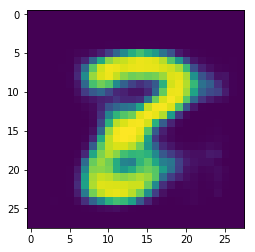

***epoch 18, step 250: total loss: 103.41085052490234, E_loss: 84.8570556640625, KL_loss:18.553794860839844
***epoch 18, step 300: total loss: 103.88478088378906, E_loss: 85.19200134277344, KL_loss:18.692777633666992
**********result at Epoch 18 Step 300*************


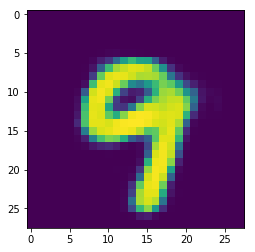

***epoch 18, step 350: total loss: 103.63187408447266, E_loss: 84.91567993164062, KL_loss:18.71619415283203
***epoch 18, step 400: total loss: 101.74345397949219, E_loss: 83.31307220458984, KL_loss:18.43037986755371
**********result at Epoch 18 Step 400*************


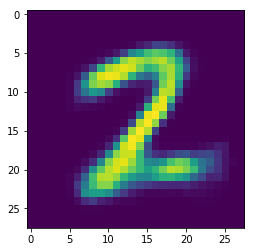

**********result at Epoch 19 Step 0*************


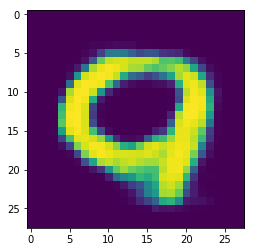

**********result at Epoch 19 Step 100*************


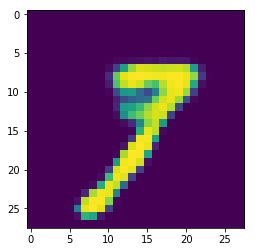

**********result at Epoch 19 Step 200*************


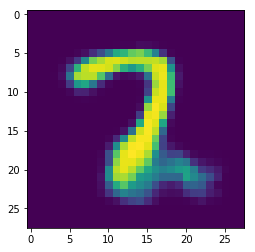

**********result at Epoch 19 Step 300*************


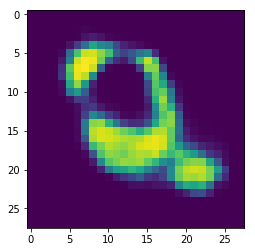

**********result at Epoch 19 Step 400*************


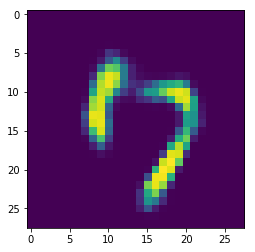

***epoch 20, step 0: total loss: 99.4666748046875, E_loss: 81.04141235351562, KL_loss:18.425262451171875
**********result at Epoch 20 Step 0*************


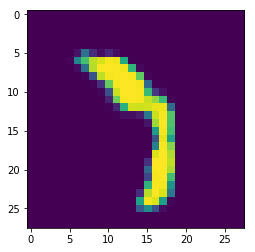

***epoch 20, step 50: total loss: 100.7518310546875, E_loss: 82.012939453125, KL_loss:18.738893508911133
***epoch 20, step 100: total loss: 99.34901428222656, E_loss: 80.65849304199219, KL_loss:18.690521240234375
**********result at Epoch 20 Step 100*************


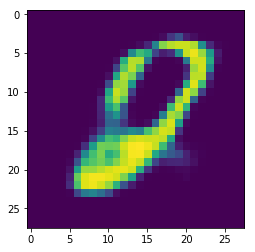

***epoch 20, step 150: total loss: 95.66485595703125, E_loss: 77.45626831054688, KL_loss:18.20859146118164
***epoch 20, step 200: total loss: 98.60382843017578, E_loss: 79.7965316772461, KL_loss:18.80729866027832
**********result at Epoch 20 Step 200*************


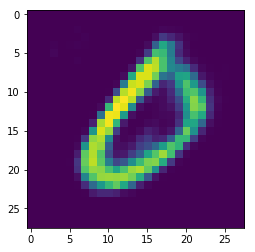

***epoch 20, step 250: total loss: 102.85071563720703, E_loss: 84.14979553222656, KL_loss:18.70092010498047
***epoch 20, step 300: total loss: 102.72737884521484, E_loss: 83.98469543457031, KL_loss:18.7426815032959
**********result at Epoch 20 Step 300*************


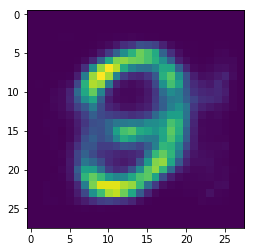

***epoch 20, step 350: total loss: 103.16146850585938, E_loss: 83.7695541381836, KL_loss:19.391910552978516
***epoch 20, step 400: total loss: 101.64264678955078, E_loss: 82.77758026123047, KL_loss:18.865066528320312
**********result at Epoch 20 Step 400*************


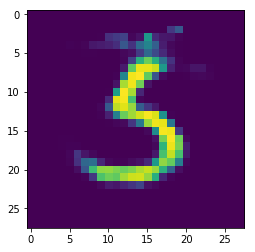

**********result at Epoch 21 Step 0*************


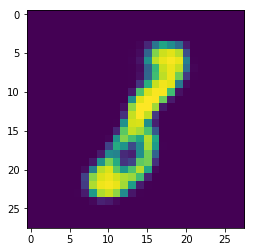

**********result at Epoch 21 Step 100*************


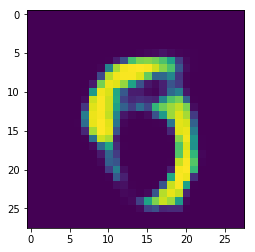

**********result at Epoch 21 Step 200*************


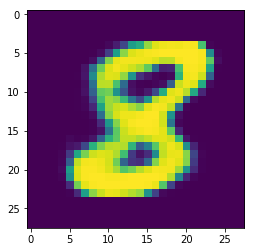

**********result at Epoch 21 Step 300*************


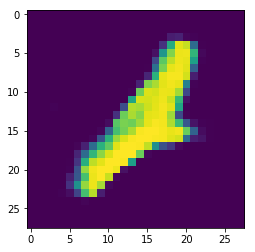

**********result at Epoch 21 Step 400*************


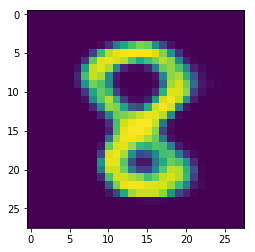

***epoch 22, step 0: total loss: 98.90141296386719, E_loss: 80.23843383789062, KL_loss:18.662975311279297
**********result at Epoch 22 Step 0*************


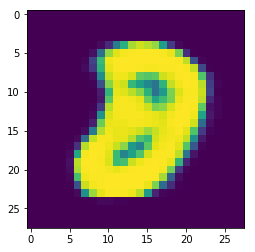

***epoch 22, step 50: total loss: 100.35610961914062, E_loss: 81.50142669677734, KL_loss:18.85468292236328
***epoch 22, step 100: total loss: 99.93804931640625, E_loss: 81.694580078125, KL_loss:18.243467330932617
**********result at Epoch 22 Step 100*************


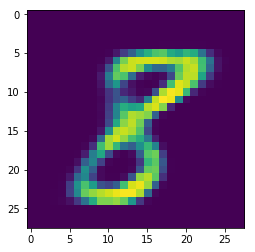

***epoch 22, step 150: total loss: 95.582275390625, E_loss: 77.21674346923828, KL_loss:18.365528106689453
***epoch 22, step 200: total loss: 98.92466735839844, E_loss: 80.02909851074219, KL_loss:18.895570755004883
**********result at Epoch 22 Step 200*************


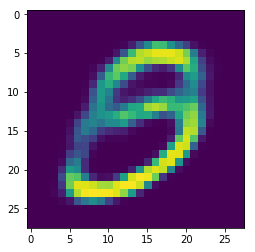

***epoch 22, step 250: total loss: 101.31253814697266, E_loss: 82.43541717529297, KL_loss:18.87712287902832
***epoch 22, step 300: total loss: 102.24089050292969, E_loss: 83.70523071289062, KL_loss:18.535659790039062
**********result at Epoch 22 Step 300*************


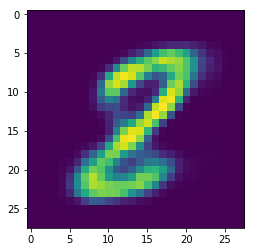

***epoch 22, step 350: total loss: 102.55564880371094, E_loss: 83.4593276977539, KL_loss:19.096323013305664
***epoch 22, step 400: total loss: 102.08750915527344, E_loss: 83.27471923828125, KL_loss:18.812793731689453
**********result at Epoch 22 Step 400*************


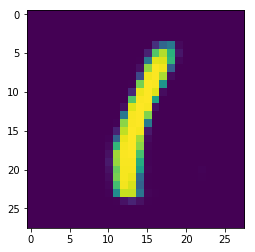

**********result at Epoch 23 Step 0*************


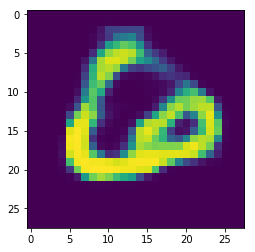

**********result at Epoch 23 Step 100*************


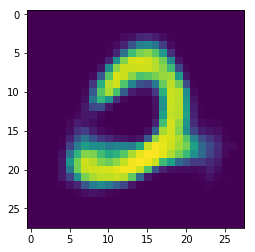

**********result at Epoch 23 Step 200*************


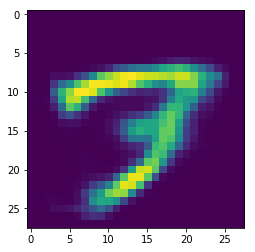

**********result at Epoch 23 Step 300*************


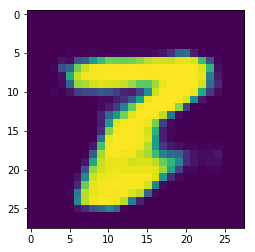

**********result at Epoch 23 Step 400*************


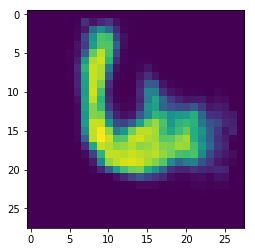

***epoch 24, step 0: total loss: 98.9353256225586, E_loss: 80.51744079589844, KL_loss:18.417884826660156
**********result at Epoch 24 Step 0*************


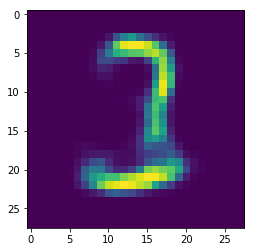

***epoch 24, step 50: total loss: 100.64302825927734, E_loss: 81.98612976074219, KL_loss:18.65690040588379
***epoch 24, step 100: total loss: 98.46385192871094, E_loss: 79.65350341796875, KL_loss:18.810344696044922
**********result at Epoch 24 Step 100*************


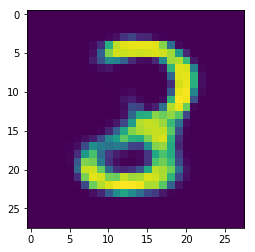

***epoch 24, step 150: total loss: 94.58245086669922, E_loss: 76.47172546386719, KL_loss:18.11072540283203
***epoch 24, step 200: total loss: 97.86740112304688, E_loss: 79.19916534423828, KL_loss:18.66823959350586
**********result at Epoch 24 Step 200*************


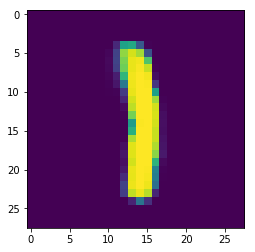

***epoch 24, step 250: total loss: 100.968017578125, E_loss: 82.16365051269531, KL_loss:18.804363250732422
***epoch 24, step 300: total loss: 101.67807006835938, E_loss: 82.7635498046875, KL_loss:18.914522171020508
**********result at Epoch 24 Step 300*************


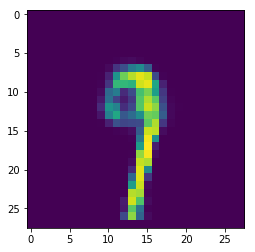

***epoch 24, step 350: total loss: 101.55892944335938, E_loss: 82.88858795166016, KL_loss:18.67034149169922
***epoch 24, step 400: total loss: 101.5701904296875, E_loss: 82.57701110839844, KL_loss:18.993183135986328
**********result at Epoch 24 Step 400*************


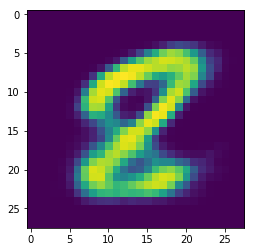

**********result at Epoch 25 Step 0*************


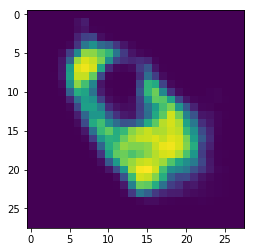

**********result at Epoch 25 Step 100*************


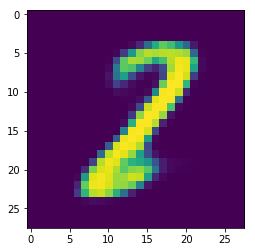

**********result at Epoch 25 Step 200*************


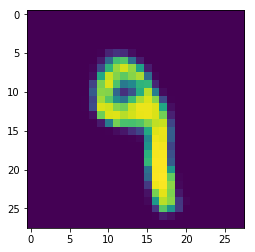

**********result at Epoch 25 Step 300*************


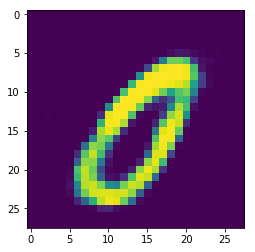

**********result at Epoch 25 Step 400*************


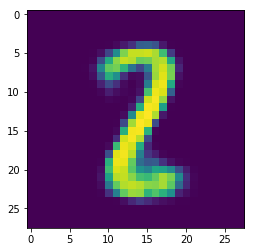

***epoch 26, step 0: total loss: 98.12835693359375, E_loss: 79.58577728271484, KL_loss:18.542579650878906
**********result at Epoch 26 Step 0*************


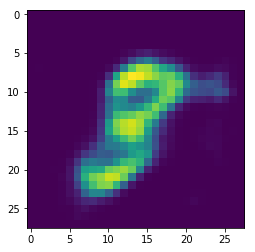

***epoch 26, step 50: total loss: 99.93531036376953, E_loss: 80.92960357666016, KL_loss:19.005706787109375
***epoch 26, step 100: total loss: 98.25637817382812, E_loss: 79.61000061035156, KL_loss:18.64637565612793
**********result at Epoch 26 Step 100*************


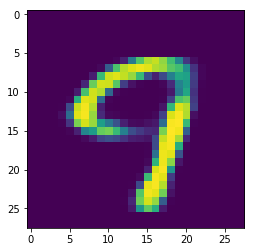

***epoch 26, step 150: total loss: 94.44889831542969, E_loss: 76.0914077758789, KL_loss:18.35749053955078
***epoch 26, step 200: total loss: 97.81312561035156, E_loss: 79.1746597290039, KL_loss:18.638463973999023
**********result at Epoch 26 Step 200*************


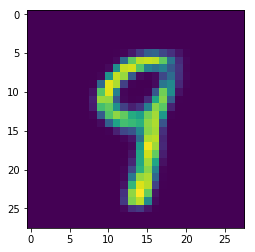

***epoch 26, step 250: total loss: 100.81526184082031, E_loss: 81.70732116699219, KL_loss:19.107942581176758
***epoch 26, step 300: total loss: 101.0504379272461, E_loss: 82.1987075805664, KL_loss:18.851728439331055
**********result at Epoch 26 Step 300*************


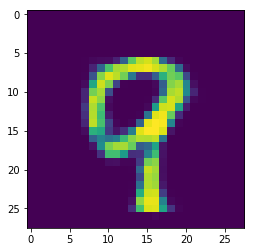

***epoch 26, step 350: total loss: 101.599853515625, E_loss: 82.06887817382812, KL_loss:19.53097152709961
***epoch 26, step 400: total loss: 100.37919616699219, E_loss: 81.4820556640625, KL_loss:18.897136688232422
**********result at Epoch 26 Step 400*************


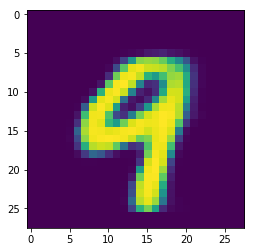

**********result at Epoch 27 Step 0*************


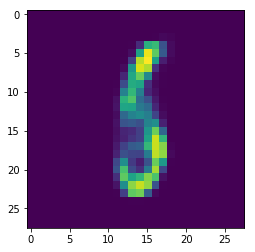

**********result at Epoch 27 Step 100*************


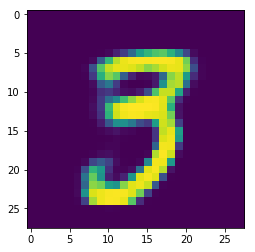

**********result at Epoch 27 Step 200*************


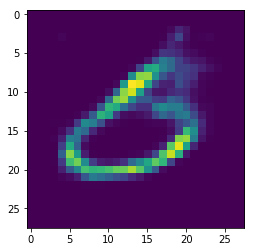

**********result at Epoch 27 Step 300*************


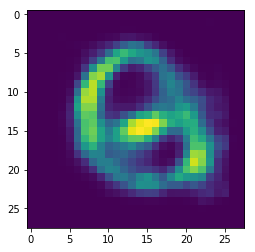

**********result at Epoch 27 Step 400*************


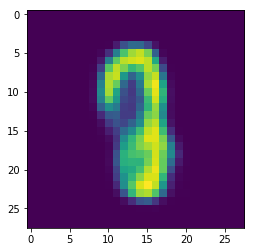

***epoch 28, step 0: total loss: 96.968505859375, E_loss: 78.19564819335938, KL_loss:18.77285385131836
**********result at Epoch 28 Step 0*************


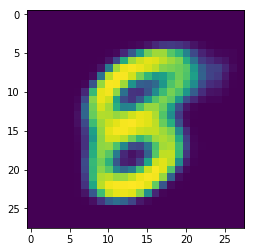

***epoch 28, step 50: total loss: 100.01304626464844, E_loss: 81.1053466796875, KL_loss:18.907699584960938
***epoch 28, step 100: total loss: 98.05110168457031, E_loss: 79.24298095703125, KL_loss:18.808124542236328
**********result at Epoch 28 Step 100*************


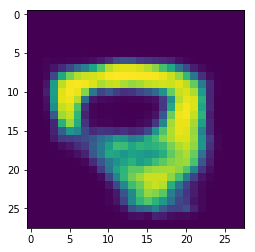

***epoch 28, step 150: total loss: 93.59779357910156, E_loss: 75.33074188232422, KL_loss:18.267051696777344
***epoch 28, step 200: total loss: 97.06685638427734, E_loss: 78.20414733886719, KL_loss:18.862707138061523
**********result at Epoch 28 Step 200*************


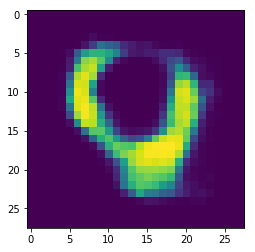

***epoch 28, step 250: total loss: 100.66014862060547, E_loss: 81.66484069824219, KL_loss:18.99530792236328
***epoch 28, step 300: total loss: 101.78010559082031, E_loss: 82.65949249267578, KL_loss:19.120615005493164
**********result at Epoch 28 Step 300*************


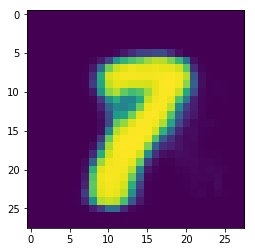

***epoch 28, step 350: total loss: 100.98878479003906, E_loss: 81.46034240722656, KL_loss:19.528438568115234
***epoch 28, step 400: total loss: 99.97932434082031, E_loss: 80.73297119140625, KL_loss:19.246355056762695
**********result at Epoch 28 Step 400*************


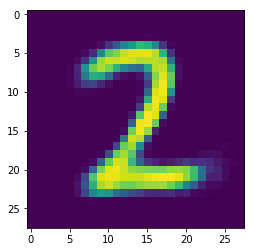

**********result at Epoch 29 Step 0*************


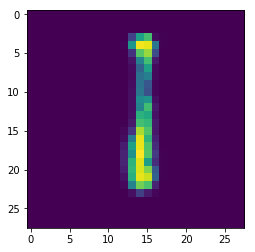

**********result at Epoch 29 Step 100*************


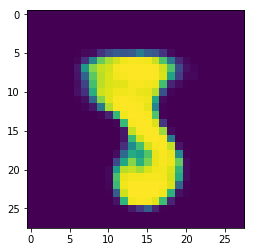

**********result at Epoch 29 Step 200*************


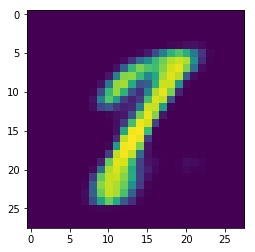

**********result at Epoch 29 Step 300*************


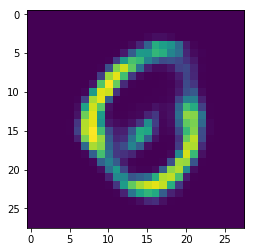

**********result at Epoch 29 Step 400*************


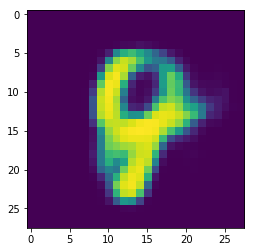

***epoch 30, step 0: total loss: 97.62918853759766, E_loss: 79.14006042480469, KL_loss:18.48912811279297
**********result at Epoch 30 Step 0*************


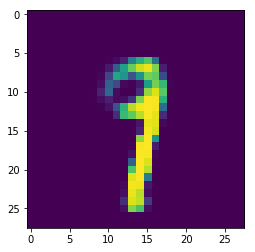

***epoch 30, step 50: total loss: 99.52619934082031, E_loss: 80.51187133789062, KL_loss:19.014326095581055
***epoch 30, step 100: total loss: 97.70372009277344, E_loss: 78.76658630371094, KL_loss:18.937131881713867
**********result at Epoch 30 Step 100*************


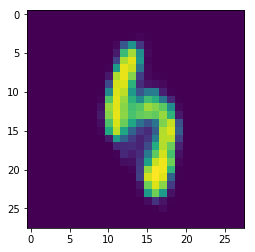

***epoch 30, step 150: total loss: 93.7991943359375, E_loss: 75.57559967041016, KL_loss:18.22359275817871
***epoch 30, step 200: total loss: 97.19972229003906, E_loss: 78.33634948730469, KL_loss:18.86336898803711
**********result at Epoch 30 Step 200*************


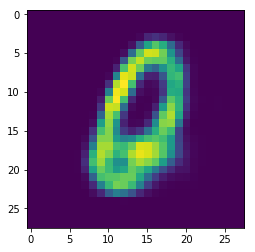

***epoch 30, step 250: total loss: 99.87956237792969, E_loss: 80.75072479248047, KL_loss:19.128833770751953
***epoch 30, step 300: total loss: 100.9739990234375, E_loss: 81.8115234375, KL_loss:19.1624755859375
**********result at Epoch 30 Step 300*************


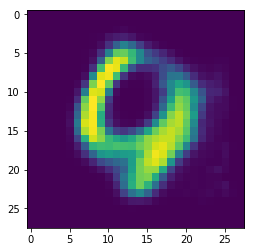

***epoch 30, step 350: total loss: 101.64115905761719, E_loss: 82.25709533691406, KL_loss:19.384061813354492
***epoch 30, step 400: total loss: 99.2278823852539, E_loss: 79.79733276367188, KL_loss:19.43054962158203
**********result at Epoch 30 Step 400*************


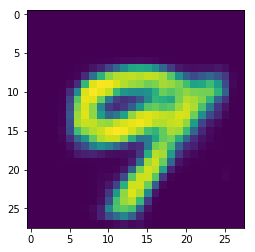

**********result at Epoch 31 Step 0*************


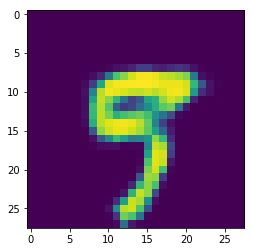

**********result at Epoch 31 Step 100*************


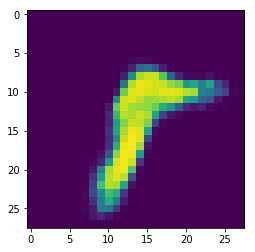

**********result at Epoch 31 Step 200*************


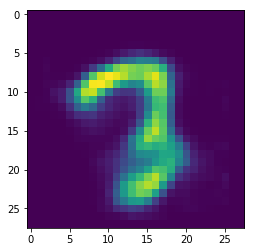

**********result at Epoch 31 Step 300*************


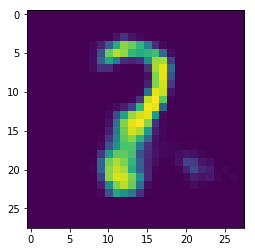

**********result at Epoch 31 Step 400*************


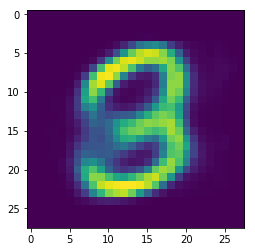

***epoch 32, step 0: total loss: 96.85696411132812, E_loss: 78.0343017578125, KL_loss:18.82265853881836
**********result at Epoch 32 Step 0*************


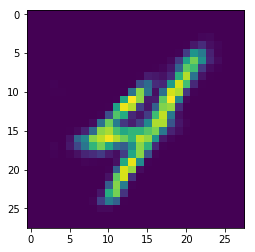

***epoch 32, step 50: total loss: 98.4287109375, E_loss: 79.53572845458984, KL_loss:18.892980575561523
***epoch 32, step 100: total loss: 97.22087097167969, E_loss: 78.55873107910156, KL_loss:18.662137985229492
**********result at Epoch 32 Step 100*************


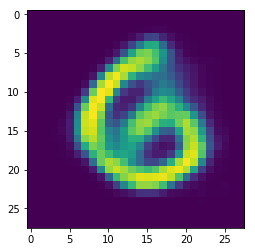

***epoch 32, step 150: total loss: 92.84159851074219, E_loss: 74.50874328613281, KL_loss:18.33285140991211
***epoch 32, step 200: total loss: 96.9224853515625, E_loss: 78.16305541992188, KL_loss:18.75942611694336
**********result at Epoch 32 Step 200*************


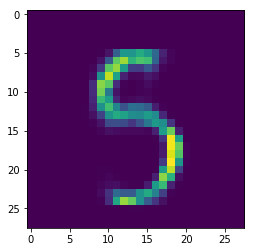

***epoch 32, step 250: total loss: 100.04218292236328, E_loss: 80.99637603759766, KL_loss:19.045806884765625
***epoch 32, step 300: total loss: 100.83358001708984, E_loss: 81.88328552246094, KL_loss:18.950294494628906
**********result at Epoch 32 Step 300*************


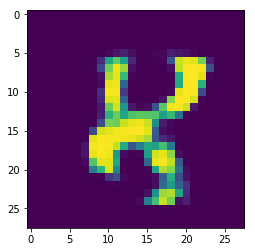

***epoch 32, step 350: total loss: 100.09840393066406, E_loss: 80.55963897705078, KL_loss:19.53876304626465
***epoch 32, step 400: total loss: 99.85967254638672, E_loss: 80.96504974365234, KL_loss:18.894624710083008
**********result at Epoch 32 Step 400*************


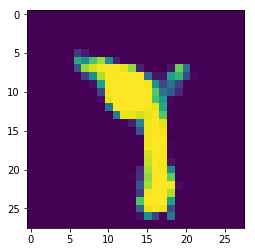

**********result at Epoch 33 Step 0*************


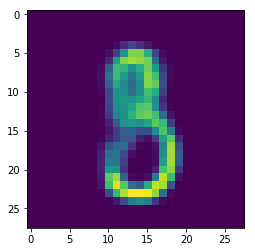

**********result at Epoch 33 Step 100*************


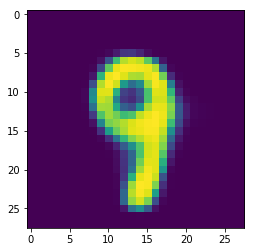

**********result at Epoch 33 Step 200*************


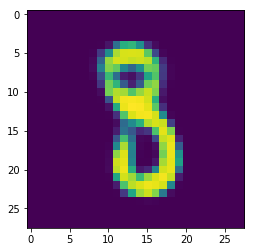

**********result at Epoch 33 Step 300*************


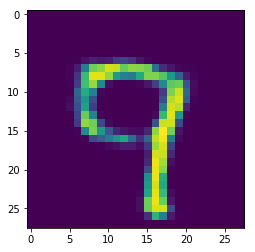

**********result at Epoch 33 Step 400*************


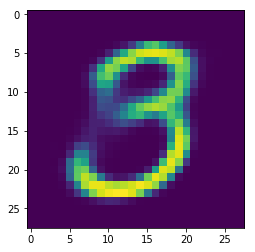

***epoch 34, step 0: total loss: 96.94927215576172, E_loss: 78.04069519042969, KL_loss:18.90857696533203
**********result at Epoch 34 Step 0*************


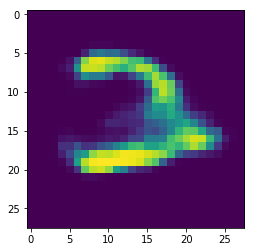

***epoch 34, step 50: total loss: 98.61075592041016, E_loss: 79.45416259765625, KL_loss:19.15659523010254
***epoch 34, step 100: total loss: 97.1021728515625, E_loss: 78.10411071777344, KL_loss:18.998065948486328
**********result at Epoch 34 Step 100*************


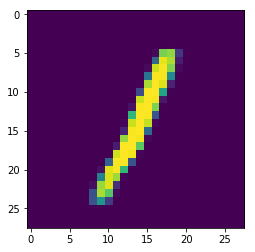

***epoch 34, step 150: total loss: 93.69043731689453, E_loss: 75.44165802001953, KL_loss:18.248777389526367
***epoch 34, step 200: total loss: 96.60520935058594, E_loss: 77.53986358642578, KL_loss:19.065345764160156
**********result at Epoch 34 Step 200*************


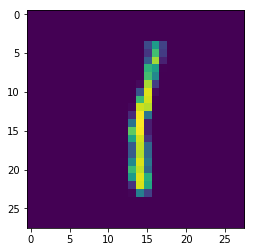

***epoch 34, step 250: total loss: 100.22889709472656, E_loss: 81.20599365234375, KL_loss:19.022903442382812
***epoch 34, step 300: total loss: 100.43073272705078, E_loss: 81.20785522460938, KL_loss:19.22287940979004
**********result at Epoch 34 Step 300*************


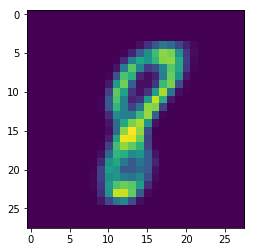

***epoch 34, step 350: total loss: 100.64212036132812, E_loss: 81.34852600097656, KL_loss:19.293598175048828
***epoch 34, step 400: total loss: 99.14378356933594, E_loss: 79.71435546875, KL_loss:19.429424285888672
**********result at Epoch 34 Step 400*************


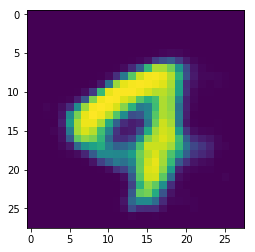

**********result at Epoch 35 Step 0*************


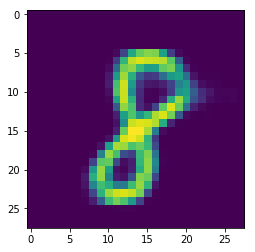

**********result at Epoch 35 Step 100*************


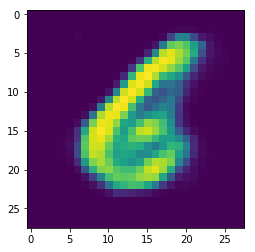

**********result at Epoch 35 Step 200*************


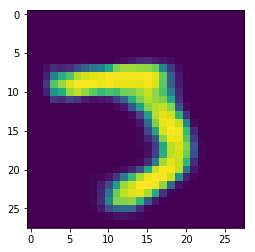

**********result at Epoch 35 Step 300*************


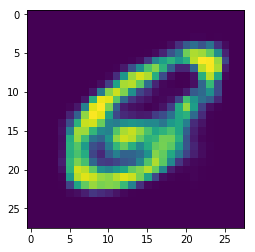

**********result at Epoch 35 Step 400*************


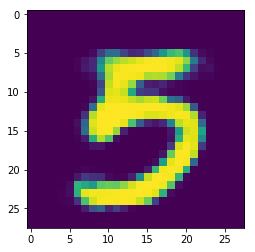

***epoch 36, step 0: total loss: 96.62592315673828, E_loss: 77.77307891845703, KL_loss:18.852846145629883
**********result at Epoch 36 Step 0*************


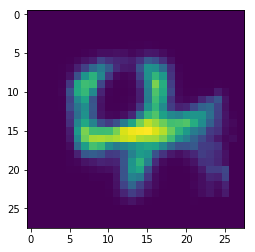

***epoch 36, step 50: total loss: 98.42646789550781, E_loss: 79.07261657714844, KL_loss:19.35385513305664
***epoch 36, step 100: total loss: 96.21880340576172, E_loss: 77.40240478515625, KL_loss:18.816396713256836
**********result at Epoch 36 Step 100*************


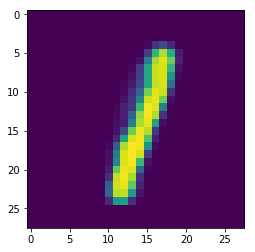

***epoch 36, step 150: total loss: 93.31372833251953, E_loss: 74.882080078125, KL_loss:18.431650161743164
***epoch 36, step 200: total loss: 95.58577728271484, E_loss: 76.74101257324219, KL_loss:18.84476661682129
**********result at Epoch 36 Step 200*************


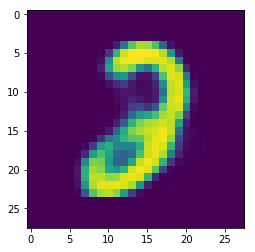

***epoch 36, step 250: total loss: 100.5111083984375, E_loss: 81.3531265258789, KL_loss:19.157983779907227
***epoch 36, step 300: total loss: 100.51004028320312, E_loss: 81.58416748046875, KL_loss:18.925874710083008
**********result at Epoch 36 Step 300*************


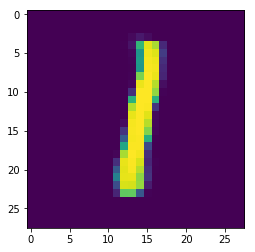

***epoch 36, step 350: total loss: 100.08338928222656, E_loss: 80.51217651367188, KL_loss:19.571208953857422
***epoch 36, step 400: total loss: 98.78498840332031, E_loss: 79.50126647949219, KL_loss:19.283721923828125
**********result at Epoch 36 Step 400*************


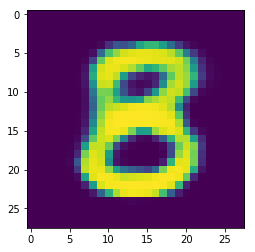

**********result at Epoch 37 Step 0*************


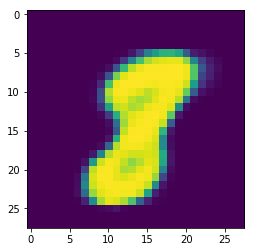

**********result at Epoch 37 Step 100*************


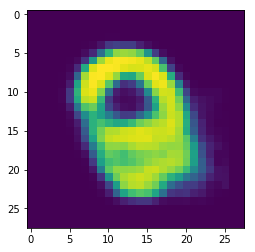

**********result at Epoch 37 Step 200*************


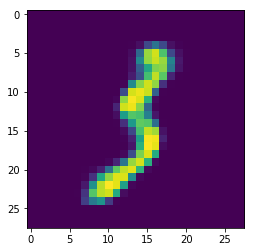

**********result at Epoch 37 Step 300*************


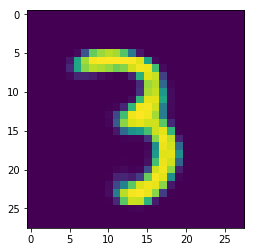

**********result at Epoch 37 Step 400*************


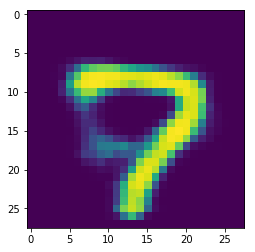

***epoch 38, step 0: total loss: 95.73664855957031, E_loss: 76.86786651611328, KL_loss:18.868785858154297
**********result at Epoch 38 Step 0*************


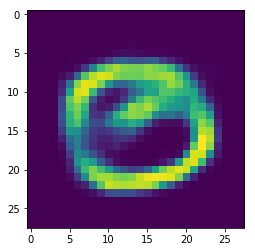

***epoch 38, step 50: total loss: 97.92054748535156, E_loss: 78.63946533203125, KL_loss:19.281084060668945
***epoch 38, step 100: total loss: 96.80467987060547, E_loss: 78.0650863647461, KL_loss:18.739593505859375
**********result at Epoch 38 Step 100*************


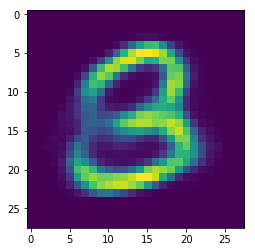

***epoch 38, step 150: total loss: 92.75264739990234, E_loss: 74.28044128417969, KL_loss:18.472204208374023
***epoch 38, step 200: total loss: 96.02220153808594, E_loss: 77.22649383544922, KL_loss:18.795711517333984
**********result at Epoch 38 Step 200*************


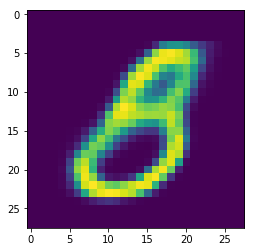

***epoch 38, step 250: total loss: 100.03194427490234, E_loss: 80.82542419433594, KL_loss:19.20652198791504
***epoch 38, step 300: total loss: 100.0199966430664, E_loss: 81.2396469116211, KL_loss:18.780351638793945
**********result at Epoch 38 Step 300*************


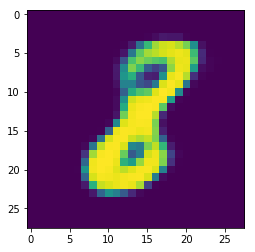

***epoch 38, step 350: total loss: 99.83740234375, E_loss: 80.46989440917969, KL_loss:19.367504119873047
***epoch 38, step 400: total loss: 98.50056457519531, E_loss: 79.21377563476562, KL_loss:19.286792755126953
**********result at Epoch 38 Step 400*************


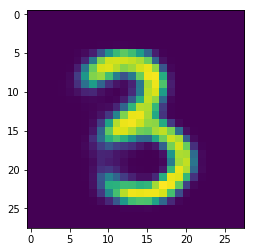

**********result at Epoch 39 Step 0*************


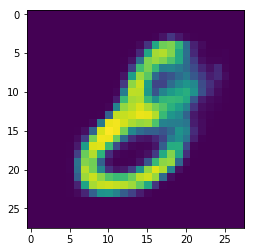

**********result at Epoch 39 Step 100*************


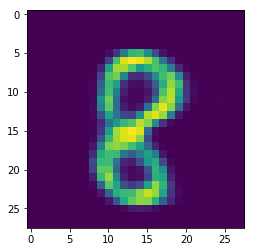

**********result at Epoch 39 Step 200*************


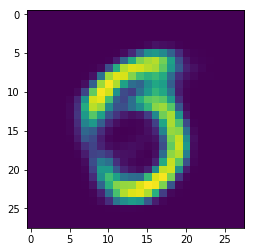

**********result at Epoch 39 Step 300*************


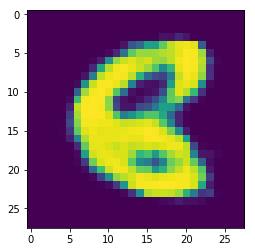

**********result at Epoch 39 Step 400*************


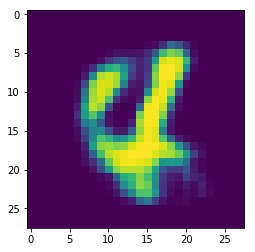

***epoch 40, step 0: total loss: 96.19216918945312, E_loss: 77.46056365966797, KL_loss:18.73160743713379
**********result at Epoch 40 Step 0*************


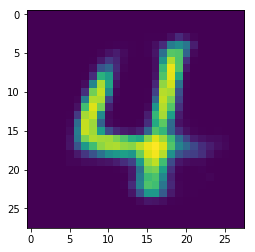

***epoch 40, step 50: total loss: 98.12686157226562, E_loss: 78.84318542480469, KL_loss:19.283672332763672
***epoch 40, step 100: total loss: 96.18852233886719, E_loss: 77.29673767089844, KL_loss:18.891788482666016
**********result at Epoch 40 Step 100*************


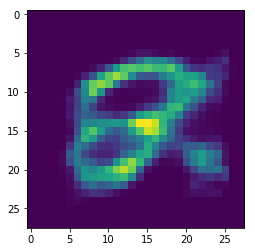

***epoch 40, step 150: total loss: 93.02569580078125, E_loss: 74.55811309814453, KL_loss:18.46758270263672
***epoch 40, step 200: total loss: 95.25852966308594, E_loss: 76.56433868408203, KL_loss:18.69418716430664
**********result at Epoch 40 Step 200*************


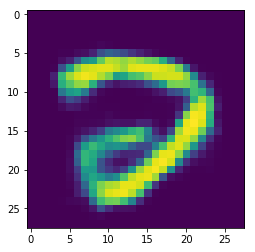

***epoch 40, step 250: total loss: 99.67276763916016, E_loss: 80.3911361694336, KL_loss:19.28162956237793
***epoch 40, step 300: total loss: 100.59700012207031, E_loss: 81.29884338378906, KL_loss:19.298152923583984
**********result at Epoch 40 Step 300*************


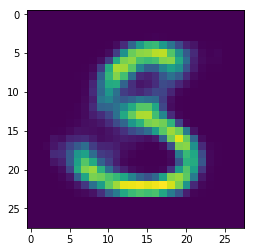

***epoch 40, step 350: total loss: 99.88789367675781, E_loss: 80.2377700805664, KL_loss:19.650127410888672
***epoch 40, step 400: total loss: 97.8130111694336, E_loss: 78.3529281616211, KL_loss:19.4600830078125
**********result at Epoch 40 Step 400*************


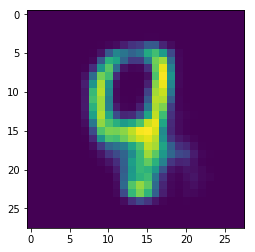

**********result at Epoch 41 Step 0*************


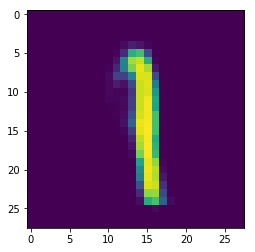

**********result at Epoch 41 Step 100*************


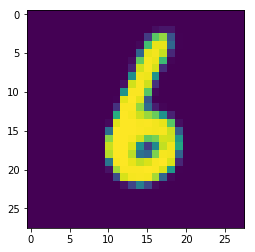

**********result at Epoch 41 Step 200*************


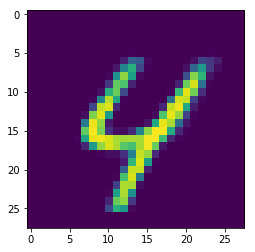

**********result at Epoch 41 Step 300*************


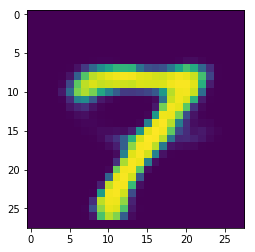

**********result at Epoch 41 Step 400*************


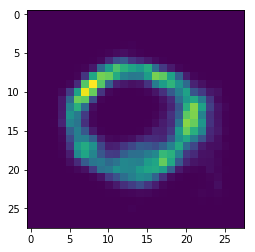

***epoch 42, step 0: total loss: 95.44998168945312, E_loss: 76.55997467041016, KL_loss:18.890005111694336
**********result at Epoch 42 Step 0*************


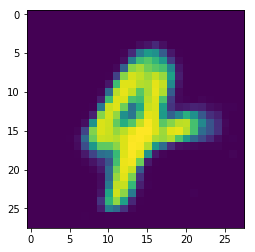

***epoch 42, step 50: total loss: 97.54361724853516, E_loss: 78.58455657958984, KL_loss:18.959062576293945
***epoch 42, step 100: total loss: 95.92802429199219, E_loss: 76.85247039794922, KL_loss:19.075557708740234
**********result at Epoch 42 Step 100*************


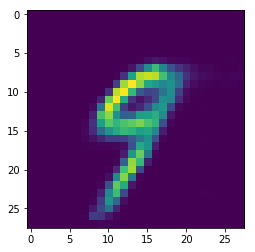

***epoch 42, step 150: total loss: 92.89462280273438, E_loss: 74.6965560913086, KL_loss:18.198070526123047
***epoch 42, step 200: total loss: 95.54048919677734, E_loss: 76.7077865600586, KL_loss:18.832700729370117
**********result at Epoch 42 Step 200*************


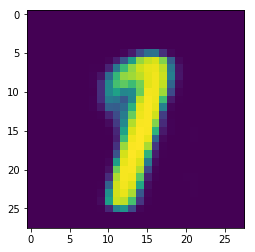

***epoch 42, step 250: total loss: 98.34616088867188, E_loss: 79.16389465332031, KL_loss:19.182268142700195
***epoch 42, step 300: total loss: 99.44381713867188, E_loss: 80.21371459960938, KL_loss:19.230106353759766
**********result at Epoch 42 Step 300*************


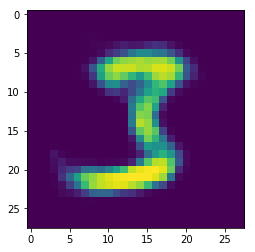

***epoch 42, step 350: total loss: 98.74718475341797, E_loss: 79.09318542480469, KL_loss:19.654001235961914
***epoch 42, step 400: total loss: 97.86244201660156, E_loss: 78.47499084472656, KL_loss:19.387449264526367
**********result at Epoch 42 Step 400*************


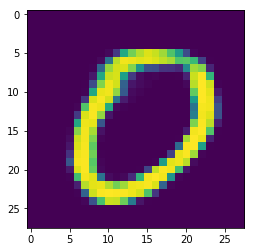

**********result at Epoch 43 Step 0*************


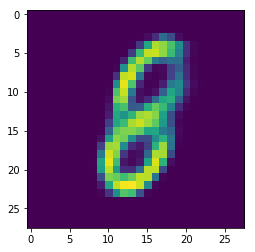

**********result at Epoch 43 Step 100*************


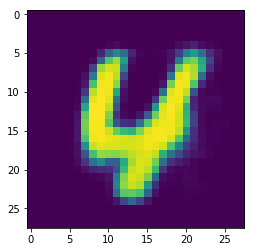

**********result at Epoch 43 Step 200*************


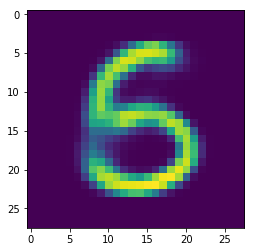

**********result at Epoch 43 Step 300*************


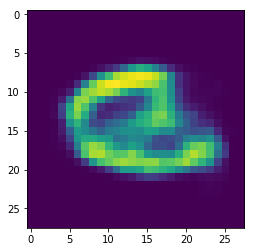

**********result at Epoch 43 Step 400*************


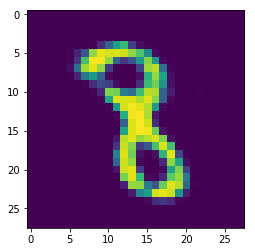

***epoch 44, step 0: total loss: 94.612060546875, E_loss: 75.49501037597656, KL_loss:19.117046356201172
**********result at Epoch 44 Step 0*************


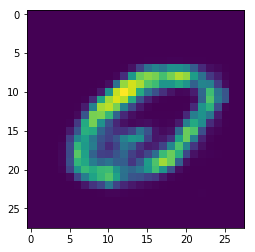

***epoch 44, step 50: total loss: 97.78593444824219, E_loss: 78.762451171875, KL_loss:19.023479461669922
***epoch 44, step 100: total loss: 95.85196685791016, E_loss: 77.13607788085938, KL_loss:18.71588706970215
**********result at Epoch 44 Step 100*************


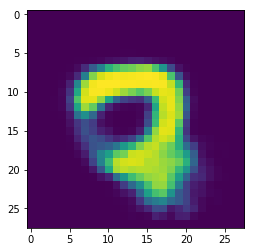

***epoch 44, step 150: total loss: 92.53695678710938, E_loss: 73.70518493652344, KL_loss:18.831768035888672
***epoch 44, step 200: total loss: 94.95901489257812, E_loss: 76.0947265625, KL_loss:18.864290237426758
**********result at Epoch 44 Step 200*************


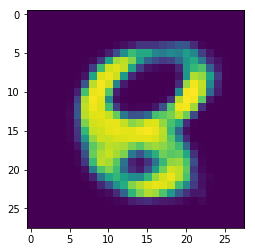

***epoch 44, step 250: total loss: 98.92778015136719, E_loss: 79.46954345703125, KL_loss:19.458240509033203
***epoch 44, step 300: total loss: 98.53575134277344, E_loss: 78.94915771484375, KL_loss:19.586589813232422
**********result at Epoch 44 Step 300*************


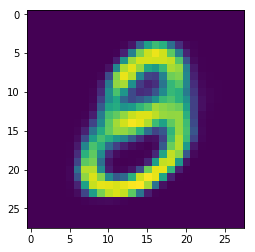

***epoch 44, step 350: total loss: 98.77484130859375, E_loss: 79.00872802734375, KL_loss:19.766111373901367
***epoch 44, step 400: total loss: 97.38981628417969, E_loss: 77.93386840820312, KL_loss:19.455947875976562
**********result at Epoch 44 Step 400*************


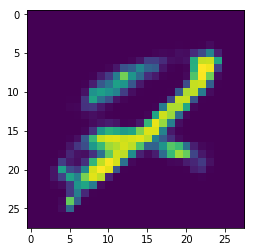

**********result at Epoch 45 Step 0*************


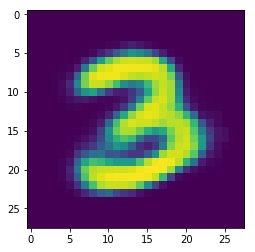

**********result at Epoch 45 Step 100*************


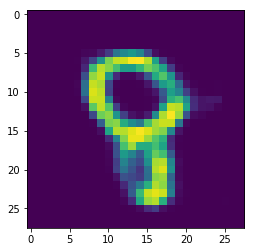

**********result at Epoch 45 Step 200*************


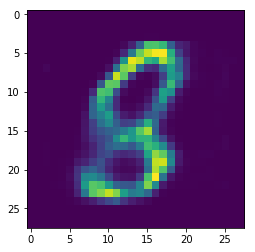

**********result at Epoch 45 Step 300*************


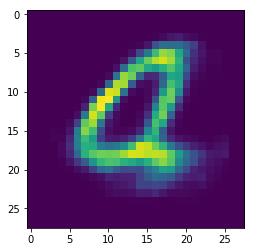

**********result at Epoch 45 Step 400*************


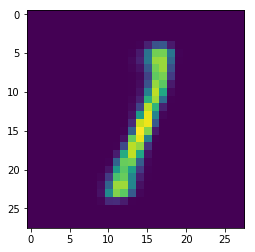

***epoch 46, step 0: total loss: 94.63390350341797, E_loss: 75.78852081298828, KL_loss:18.845382690429688
**********result at Epoch 46 Step 0*************


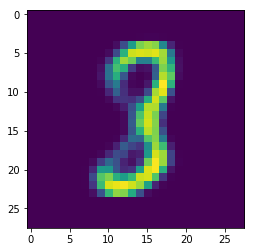

***epoch 46, step 50: total loss: 97.10738372802734, E_loss: 78.06361389160156, KL_loss:19.04376983642578
***epoch 46, step 100: total loss: 96.16681671142578, E_loss: 77.31596374511719, KL_loss:18.85085105895996
**********result at Epoch 46 Step 100*************


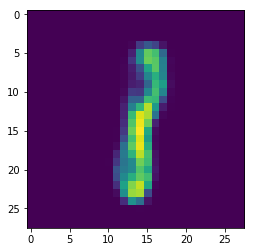

***epoch 46, step 150: total loss: 92.37682342529297, E_loss: 74.13101196289062, KL_loss:18.245813369750977
***epoch 46, step 200: total loss: 94.3756103515625, E_loss: 75.56656646728516, KL_loss:18.809040069580078
**********result at Epoch 46 Step 200*************


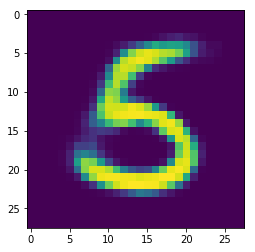

***epoch 46, step 250: total loss: 98.09114074707031, E_loss: 78.83512878417969, KL_loss:19.25600814819336
***epoch 46, step 300: total loss: 98.30570983886719, E_loss: 78.92799377441406, KL_loss:19.377716064453125
**********result at Epoch 46 Step 300*************


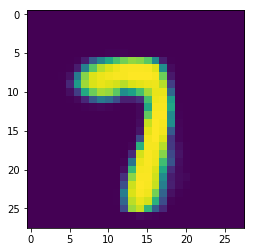

***epoch 46, step 350: total loss: 99.51778411865234, E_loss: 79.87005615234375, KL_loss:19.647727966308594
***epoch 46, step 400: total loss: 97.25173950195312, E_loss: 77.89540100097656, KL_loss:19.356340408325195
**********result at Epoch 46 Step 400*************


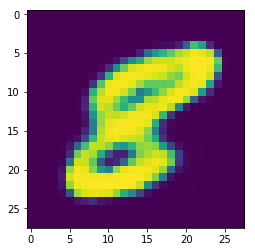

**********result at Epoch 47 Step 0*************


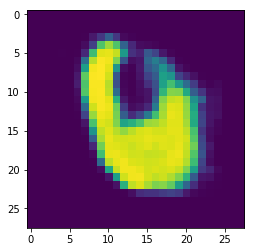

**********result at Epoch 47 Step 100*************


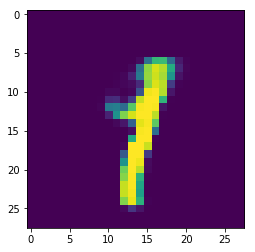

**********result at Epoch 47 Step 200*************


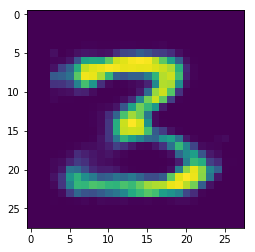

**********result at Epoch 47 Step 300*************


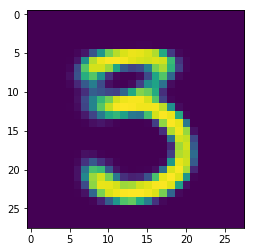

**********result at Epoch 47 Step 400*************


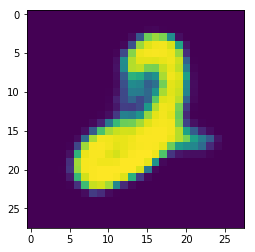

***epoch 48, step 0: total loss: 95.0714111328125, E_loss: 75.85867309570312, KL_loss:19.21274185180664
**********result at Epoch 48 Step 0*************


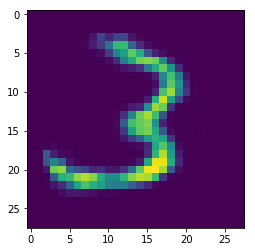

***epoch 48, step 50: total loss: 96.60658264160156, E_loss: 77.2688980102539, KL_loss:19.33768081665039
***epoch 48, step 100: total loss: 95.68382263183594, E_loss: 76.5403823852539, KL_loss:19.143444061279297
**********result at Epoch 48 Step 100*************


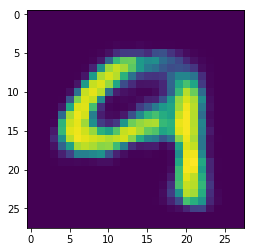

***epoch 48, step 150: total loss: 92.35416412353516, E_loss: 74.24236297607422, KL_loss:18.111801147460938
***epoch 48, step 200: total loss: 94.61934661865234, E_loss: 75.54615020751953, KL_loss:19.073196411132812
**********result at Epoch 48 Step 200*************


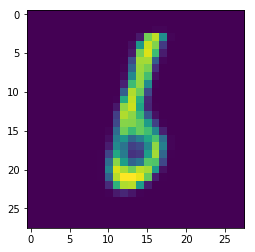

***epoch 48, step 250: total loss: 98.05229187011719, E_loss: 78.79225158691406, KL_loss:19.26003646850586
***epoch 48, step 300: total loss: 98.4132080078125, E_loss: 79.1042251586914, KL_loss:19.308984756469727
**********result at Epoch 48 Step 300*************


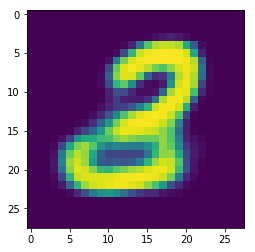

***epoch 48, step 350: total loss: 98.21562194824219, E_loss: 78.6270980834961, KL_loss:19.58852195739746
***epoch 48, step 400: total loss: 97.57594299316406, E_loss: 78.1560287475586, KL_loss:19.419918060302734
**********result at Epoch 48 Step 400*************


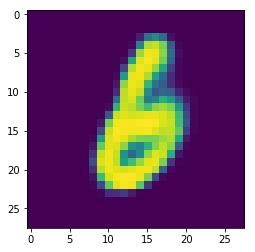

**********result at Epoch 49 Step 0*************


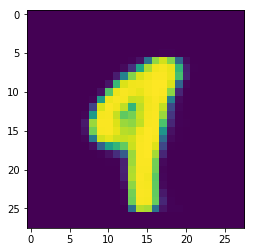

**********result at Epoch 49 Step 100*************


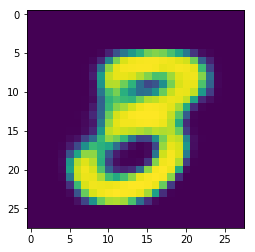

**********result at Epoch 49 Step 200*************


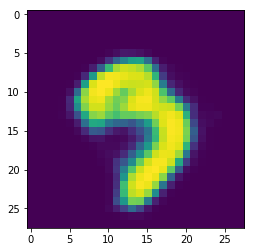

**********result at Epoch 49 Step 300*************


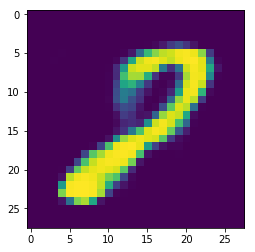

**********result at Epoch 49 Step 400*************


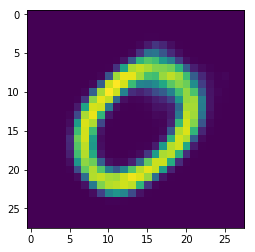

***epoch 50, step 0: total loss: 94.65567016601562, E_loss: 75.7739486694336, KL_loss:18.881723403930664
**********result at Epoch 50 Step 0*************


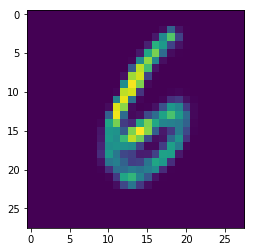

***epoch 50, step 50: total loss: 96.83228302001953, E_loss: 77.65145874023438, KL_loss:19.180824279785156
***epoch 50, step 100: total loss: 94.47166442871094, E_loss: 75.34677124023438, KL_loss:19.124893188476562
**********result at Epoch 50 Step 100*************


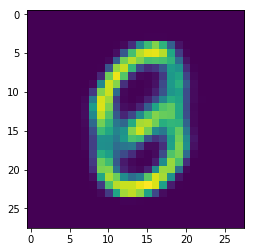

***epoch 50, step 150: total loss: 91.56126403808594, E_loss: 73.01868438720703, KL_loss:18.542583465576172
***epoch 50, step 200: total loss: 94.68543243408203, E_loss: 75.57454681396484, KL_loss:19.110883712768555
**********result at Epoch 50 Step 200*************


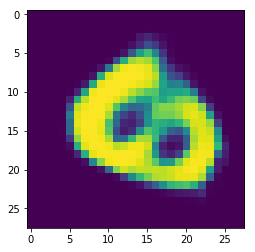

***epoch 50, step 250: total loss: 97.9638671875, E_loss: 78.5805435180664, KL_loss:19.383323669433594
***epoch 50, step 300: total loss: 97.72830200195312, E_loss: 78.11461639404297, KL_loss:19.613689422607422
**********result at Epoch 50 Step 300*************


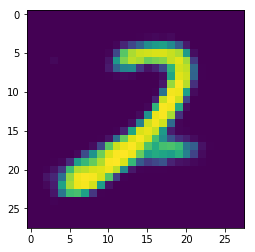

***epoch 50, step 350: total loss: 97.80845642089844, E_loss: 78.31587219238281, KL_loss:19.49258804321289
***epoch 50, step 400: total loss: 97.21515655517578, E_loss: 77.66902160644531, KL_loss:19.5461368560791
**********result at Epoch 50 Step 400*************


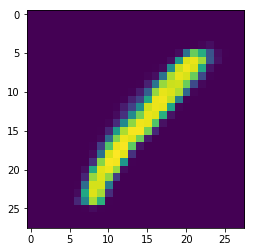

**********result at Epoch 51 Step 0*************


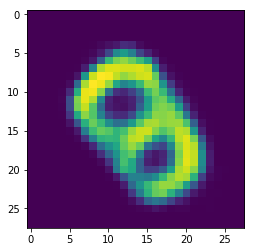

**********result at Epoch 51 Step 100*************


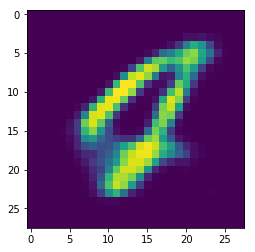

**********result at Epoch 51 Step 200*************


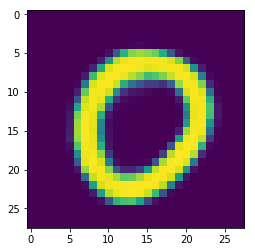

**********result at Epoch 51 Step 300*************


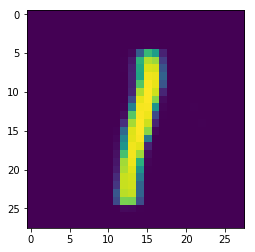

**********result at Epoch 51 Step 400*************


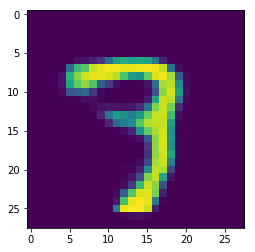

***epoch 52, step 0: total loss: 94.69993591308594, E_loss: 75.63002014160156, KL_loss:19.06991195678711
**********result at Epoch 52 Step 0*************


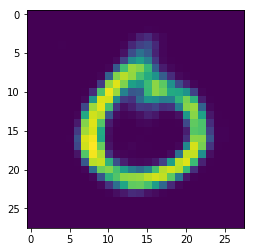

***epoch 52, step 50: total loss: 96.50614929199219, E_loss: 77.34475708007812, KL_loss:19.161394119262695
***epoch 52, step 100: total loss: 94.9981460571289, E_loss: 76.10419464111328, KL_loss:18.893951416015625
**********result at Epoch 52 Step 100*************


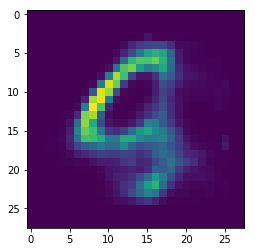

***epoch 52, step 150: total loss: 91.94477844238281, E_loss: 73.23723602294922, KL_loss:18.707544326782227
***epoch 52, step 200: total loss: 94.46820068359375, E_loss: 75.26578521728516, KL_loss:19.202417373657227
**********result at Epoch 52 Step 200*************


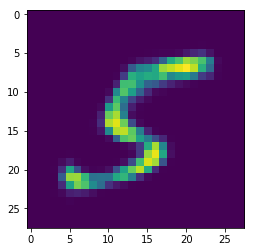

***epoch 52, step 250: total loss: 98.19081115722656, E_loss: 78.49797821044922, KL_loss:19.692834854125977
***epoch 52, step 300: total loss: 97.78273010253906, E_loss: 78.16038513183594, KL_loss:19.622344970703125
**********result at Epoch 52 Step 300*************


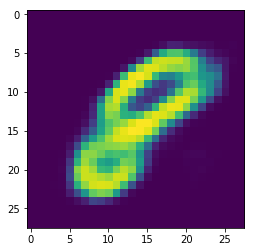

***epoch 52, step 350: total loss: 98.5120849609375, E_loss: 78.75314331054688, KL_loss:19.75893783569336
***epoch 52, step 400: total loss: 96.43812561035156, E_loss: 76.937255859375, KL_loss:19.500873565673828
**********result at Epoch 52 Step 400*************


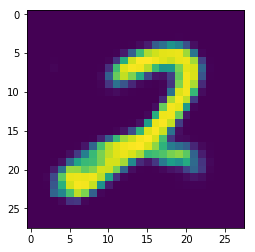

**********result at Epoch 53 Step 0*************


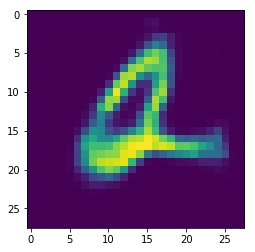

**********result at Epoch 53 Step 100*************


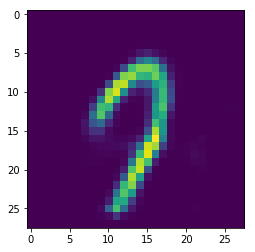

**********result at Epoch 53 Step 200*************


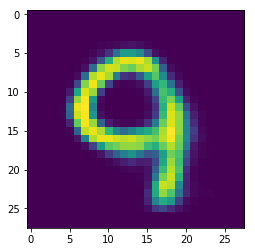

**********result at Epoch 53 Step 300*************


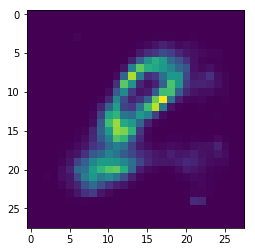

**********result at Epoch 53 Step 400*************


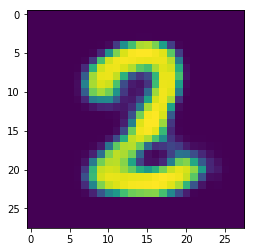

***epoch 54, step 0: total loss: 94.52603912353516, E_loss: 75.39732360839844, KL_loss:19.12871742248535
**********result at Epoch 54 Step 0*************


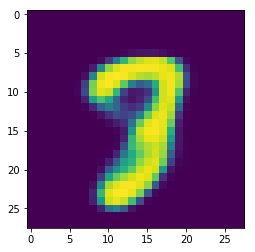

***epoch 54, step 50: total loss: 96.31700134277344, E_loss: 77.03083801269531, KL_loss:19.286163330078125
***epoch 54, step 100: total loss: 94.48714447021484, E_loss: 75.32332611083984, KL_loss:19.163816452026367
**********result at Epoch 54 Step 100*************


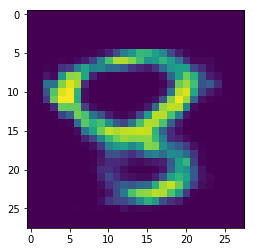

***epoch 54, step 150: total loss: 91.15922546386719, E_loss: 72.63919067382812, KL_loss:18.520036697387695
***epoch 54, step 200: total loss: 94.98165130615234, E_loss: 75.90708923339844, KL_loss:19.07456398010254
**********result at Epoch 54 Step 200*************


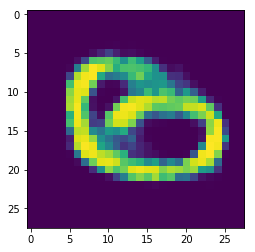

***epoch 54, step 250: total loss: 97.95919799804688, E_loss: 78.64012145996094, KL_loss:19.319080352783203
***epoch 54, step 300: total loss: 98.31724548339844, E_loss: 78.94969177246094, KL_loss:19.367549896240234
**********result at Epoch 54 Step 300*************


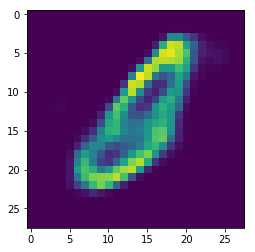

***epoch 54, step 350: total loss: 98.1241226196289, E_loss: 78.3144302368164, KL_loss:19.809690475463867
***epoch 54, step 400: total loss: 96.57084655761719, E_loss: 77.03912353515625, KL_loss:19.531719207763672
**********result at Epoch 54 Step 400*************


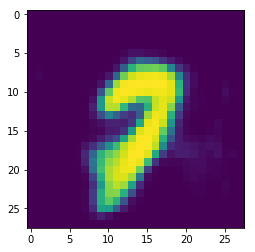

**********result at Epoch 55 Step 0*************


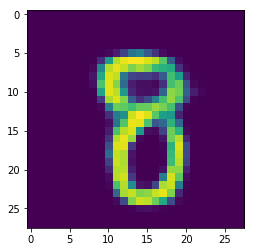

**********result at Epoch 55 Step 100*************


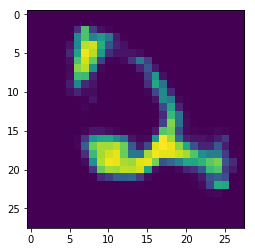

**********result at Epoch 55 Step 200*************


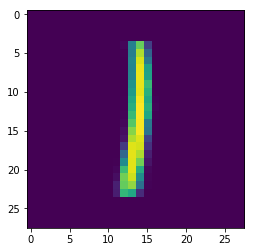

**********result at Epoch 55 Step 300*************


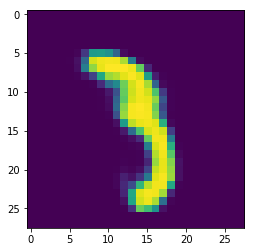

**********result at Epoch 55 Step 400*************


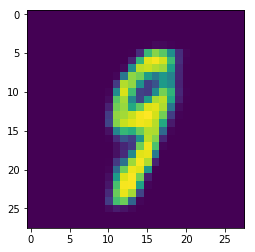

***epoch 56, step 0: total loss: 94.71116638183594, E_loss: 75.47116088867188, KL_loss:19.240005493164062
**********result at Epoch 56 Step 0*************


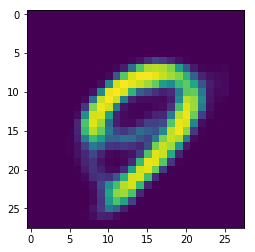

***epoch 56, step 50: total loss: 96.31840515136719, E_loss: 77.22173309326172, KL_loss:19.09667205810547
***epoch 56, step 100: total loss: 94.29888916015625, E_loss: 75.08232879638672, KL_loss:19.2165584564209
**********result at Epoch 56 Step 100*************


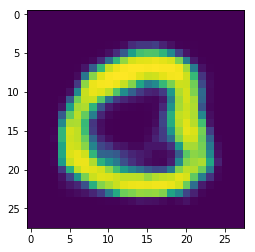

***epoch 56, step 150: total loss: 91.5222396850586, E_loss: 72.94963836669922, KL_loss:18.572601318359375
***epoch 56, step 200: total loss: 94.85200500488281, E_loss: 75.70219421386719, KL_loss:19.149810791015625
**********result at Epoch 56 Step 200*************


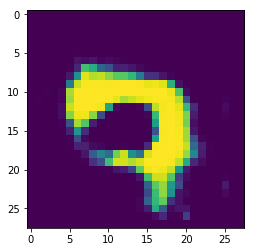

***epoch 56, step 250: total loss: 98.0102310180664, E_loss: 78.58447265625, KL_loss:19.425758361816406
***epoch 56, step 300: total loss: 98.68712615966797, E_loss: 79.13742065429688, KL_loss:19.54970359802246
**********result at Epoch 56 Step 300*************


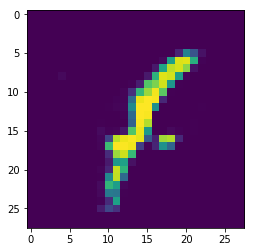

***epoch 56, step 350: total loss: 97.52162170410156, E_loss: 77.94465637207031, KL_loss:19.576967239379883
***epoch 56, step 400: total loss: 96.6220474243164, E_loss: 76.75318908691406, KL_loss:19.868860244750977
**********result at Epoch 56 Step 400*************


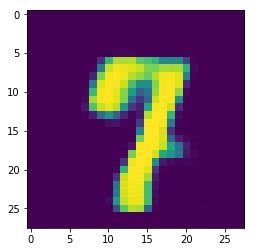

**********result at Epoch 57 Step 0*************


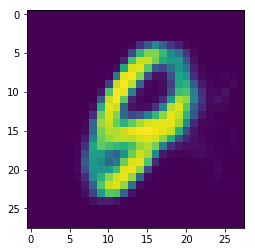

**********result at Epoch 57 Step 100*************


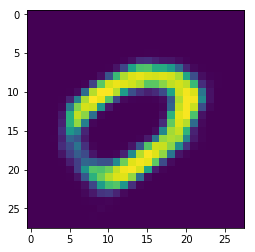

**********result at Epoch 57 Step 200*************


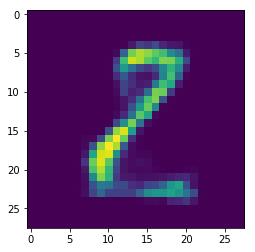

**********result at Epoch 57 Step 300*************


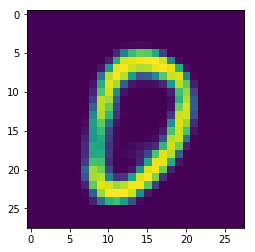

**********result at Epoch 57 Step 400*************


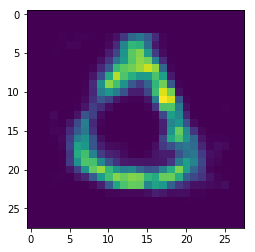

***epoch 58, step 0: total loss: 94.58648681640625, E_loss: 75.47640991210938, KL_loss:19.11008071899414
**********result at Epoch 58 Step 0*************


***epoch 58, step 50: total loss: 95.63275909423828, E_loss: 76.56103515625, KL_loss:19.071725845336914
***epoch 58, step 100: total loss: 93.49786376953125, E_loss: 74.38420867919922, KL_loss:19.113658905029297
**********result at Epoch 58 Step 100*************


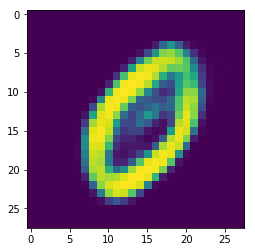

***epoch 58, step 150: total loss: 90.11250305175781, E_loss: 71.81674194335938, KL_loss:18.295764923095703
***epoch 58, step 200: total loss: 94.03606414794922, E_loss: 74.79240417480469, KL_loss:19.24365997314453
**********result at Epoch 58 Step 200*************


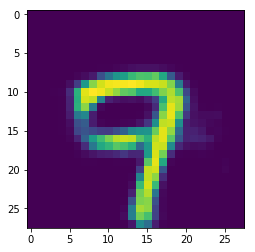

***epoch 58, step 250: total loss: 98.15345001220703, E_loss: 78.54144287109375, KL_loss:19.612009048461914
***epoch 58, step 300: total loss: 97.82266235351562, E_loss: 78.58013153076172, KL_loss:19.242530822753906
**********result at Epoch 58 Step 300*************


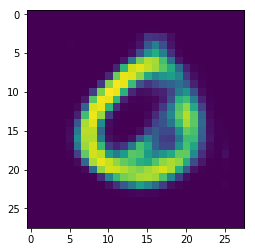

***epoch 58, step 350: total loss: 97.7059555053711, E_loss: 77.70935821533203, KL_loss:19.996597290039062
***epoch 58, step 400: total loss: 96.74177551269531, E_loss: 77.2997055053711, KL_loss:19.44207000732422
**********result at Epoch 58 Step 400*************


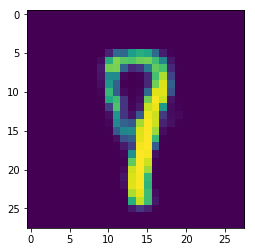

**********result at Epoch 59 Step 0*************


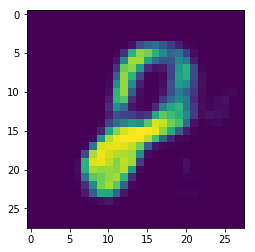

**********result at Epoch 59 Step 100*************


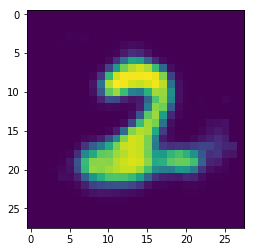

**********result at Epoch 59 Step 200*************


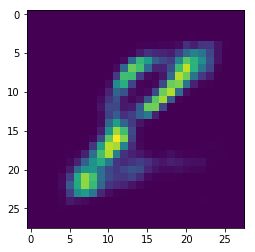

**********result at Epoch 59 Step 300*************


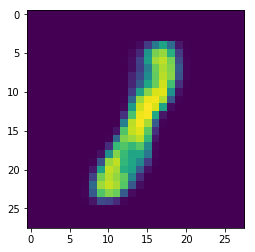

**********result at Epoch 59 Step 400*************


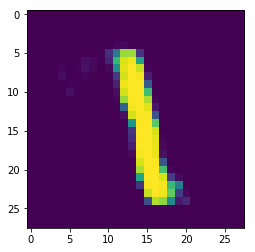

***epoch 60, step 0: total loss: 93.51062774658203, E_loss: 74.40303039550781, KL_loss:19.10759735107422
**********result at Epoch 60 Step 0*************


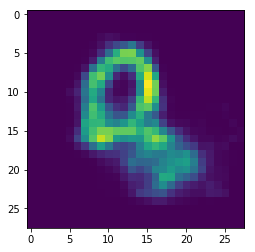

***epoch 60, step 50: total loss: 96.47441864013672, E_loss: 77.09425354003906, KL_loss:19.38016700744629
***epoch 60, step 100: total loss: 94.2686996459961, E_loss: 75.08126831054688, KL_loss:19.18743324279785
**********result at Epoch 60 Step 100*************


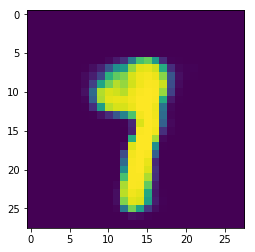

***epoch 60, step 150: total loss: 90.61126708984375, E_loss: 72.17657470703125, KL_loss:18.434688568115234
***epoch 60, step 200: total loss: 93.57785034179688, E_loss: 74.589111328125, KL_loss:18.98873519897461
**********result at Epoch 60 Step 200*************


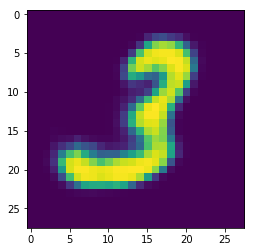

***epoch 60, step 250: total loss: 98.82339477539062, E_loss: 79.46186828613281, KL_loss:19.361528396606445
***epoch 60, step 300: total loss: 99.02608489990234, E_loss: 79.44474792480469, KL_loss:19.581336975097656
**********result at Epoch 60 Step 300*************


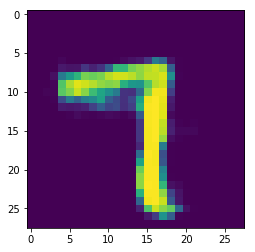

***epoch 60, step 350: total loss: 98.4369125366211, E_loss: 78.77286529541016, KL_loss:19.664047241210938
***epoch 60, step 400: total loss: 96.10507202148438, E_loss: 76.32628631591797, KL_loss:19.778789520263672
**********result at Epoch 60 Step 400*************


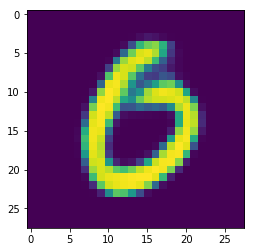

**********result at Epoch 61 Step 0*************


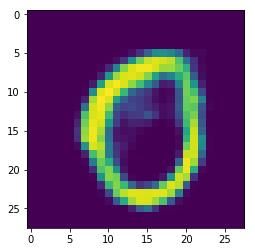

**********result at Epoch 61 Step 100*************


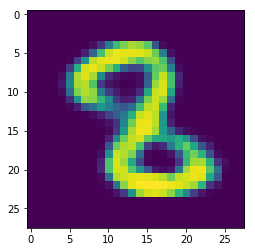

**********result at Epoch 61 Step 200*************


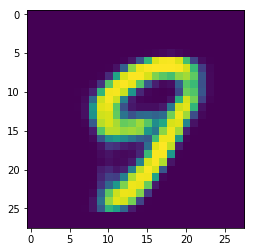

**********result at Epoch 61 Step 300*************


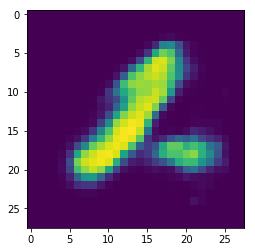

**********result at Epoch 61 Step 400*************


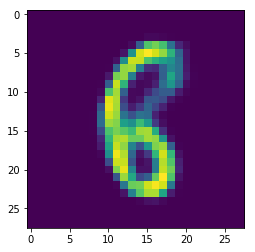

***epoch 62, step 0: total loss: 94.19996643066406, E_loss: 75.0543441772461, KL_loss:19.145626068115234
**********result at Epoch 62 Step 0*************


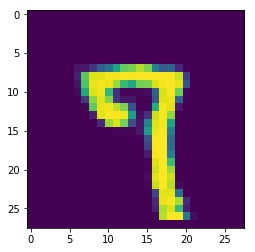

***epoch 62, step 50: total loss: 96.10968017578125, E_loss: 76.91020202636719, KL_loss:19.199478149414062
***epoch 62, step 100: total loss: 94.75080108642578, E_loss: 75.903076171875, KL_loss:18.84772491455078
**********result at Epoch 62 Step 100*************


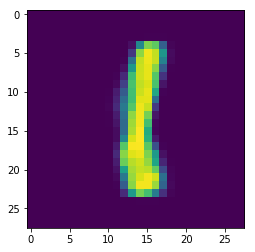

***epoch 62, step 150: total loss: 90.93760681152344, E_loss: 72.37057495117188, KL_loss:18.567031860351562
***epoch 62, step 200: total loss: 93.99299621582031, E_loss: 74.8785171508789, KL_loss:19.11447525024414
**********result at Epoch 62 Step 200*************


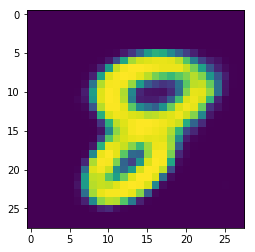

***epoch 62, step 250: total loss: 97.5721664428711, E_loss: 78.5977554321289, KL_loss:18.974409103393555
***epoch 62, step 300: total loss: 97.74308013916016, E_loss: 78.1874008178711, KL_loss:19.555681228637695
**********result at Epoch 62 Step 300*************


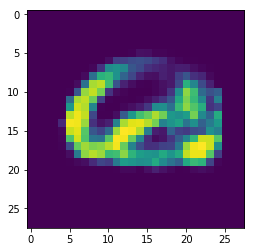

***epoch 62, step 350: total loss: 97.2568359375, E_loss: 77.42760467529297, KL_loss:19.82923126220703
***epoch 62, step 400: total loss: 95.98678588867188, E_loss: 76.33023071289062, KL_loss:19.656558990478516
**********result at Epoch 62 Step 400*************


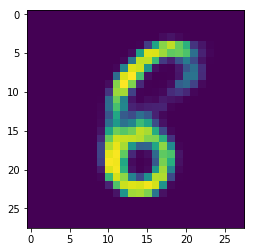

**********result at Epoch 63 Step 0*************


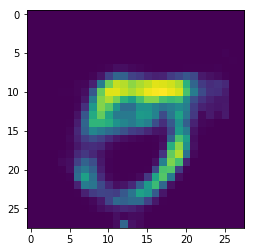

**********result at Epoch 63 Step 100*************


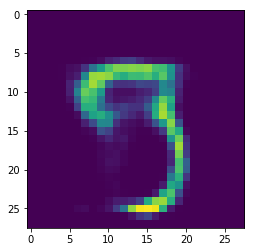

**********result at Epoch 63 Step 200*************


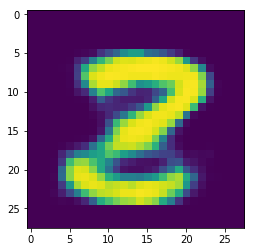

**********result at Epoch 63 Step 300*************


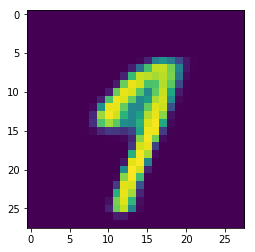

**********result at Epoch 63 Step 400*************


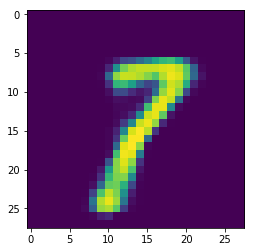

***epoch 64, step 0: total loss: 93.30467224121094, E_loss: 74.01087188720703, KL_loss:19.29380226135254
**********result at Epoch 64 Step 0*************


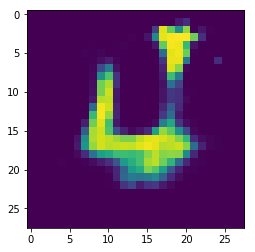

***epoch 64, step 50: total loss: 95.76516723632812, E_loss: 76.51644134521484, KL_loss:19.24872589111328
***epoch 64, step 100: total loss: 94.15446472167969, E_loss: 74.88628387451172, KL_loss:19.268177032470703
**********result at Epoch 64 Step 100*************


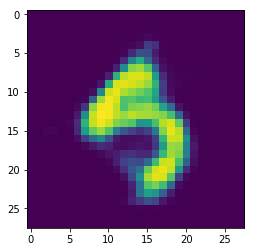

***epoch 64, step 150: total loss: 90.24484252929688, E_loss: 71.45467376708984, KL_loss:18.790172576904297
***epoch 64, step 200: total loss: 94.08268737792969, E_loss: 75.09989929199219, KL_loss:18.982791900634766
**********result at Epoch 64 Step 200*************


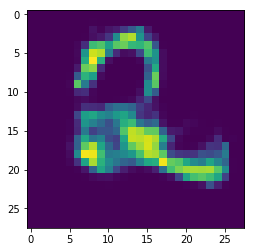

***epoch 64, step 250: total loss: 97.1554183959961, E_loss: 77.6001205444336, KL_loss:19.555299758911133
***epoch 64, step 300: total loss: 97.3914794921875, E_loss: 77.84841918945312, KL_loss:19.54305648803711
**********result at Epoch 64 Step 300*************


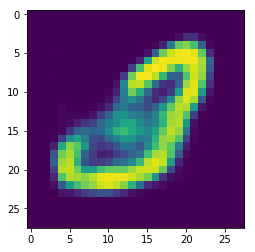

***epoch 64, step 350: total loss: 96.99776458740234, E_loss: 77.10540771484375, KL_loss:19.89235496520996
***epoch 64, step 400: total loss: 95.7868881225586, E_loss: 75.9376220703125, KL_loss:19.849267959594727
**********result at Epoch 64 Step 400*************


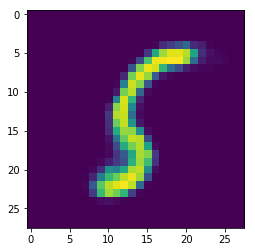

**********result at Epoch 65 Step 0*************


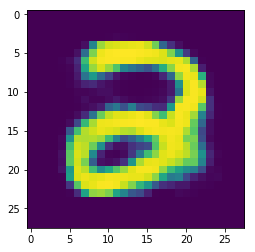

**********result at Epoch 65 Step 100*************


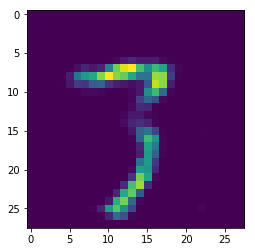

**********result at Epoch 65 Step 200*************


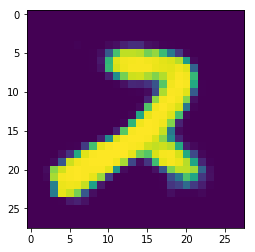

**********result at Epoch 65 Step 300*************


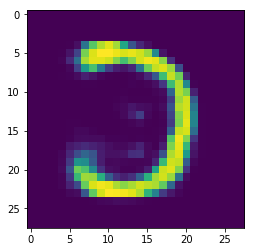

**********result at Epoch 65 Step 400*************


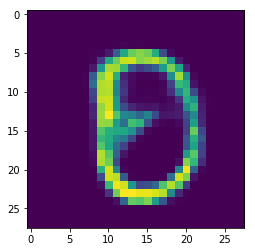

***epoch 66, step 0: total loss: 93.88520812988281, E_loss: 74.606201171875, KL_loss:19.279010772705078
**********result at Epoch 66 Step 0*************


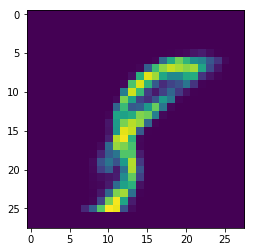

***epoch 66, step 50: total loss: 95.51976776123047, E_loss: 76.440185546875, KL_loss:19.07958221435547
***epoch 66, step 100: total loss: 93.91754913330078, E_loss: 74.71307373046875, KL_loss:19.20447540283203
**********result at Epoch 66 Step 100*************


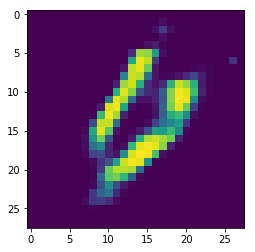

***epoch 66, step 150: total loss: 90.45099639892578, E_loss: 71.81920623779297, KL_loss:18.631790161132812
***epoch 66, step 200: total loss: 93.98530578613281, E_loss: 75.03727722167969, KL_loss:18.94803237915039
**********result at Epoch 66 Step 200*************


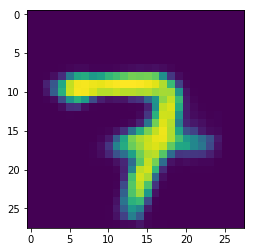

***epoch 66, step 250: total loss: 96.90431213378906, E_loss: 77.46757507324219, KL_loss:19.436738967895508
***epoch 66, step 300: total loss: 97.41133880615234, E_loss: 77.71951293945312, KL_loss:19.69182586669922
**********result at Epoch 66 Step 300*************


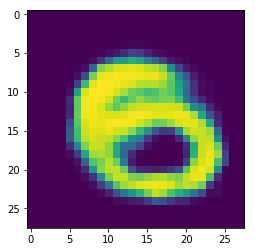

***epoch 66, step 350: total loss: 97.76970672607422, E_loss: 78.12825012207031, KL_loss:19.641454696655273
***epoch 66, step 400: total loss: 95.3436279296875, E_loss: 75.89784240722656, KL_loss:19.445785522460938
**********result at Epoch 66 Step 400*************


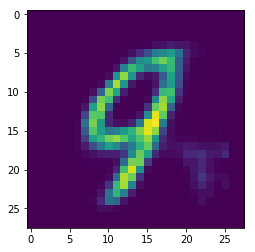

**********result at Epoch 67 Step 0*************


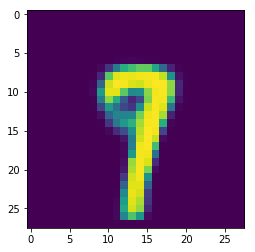

**********result at Epoch 67 Step 100*************


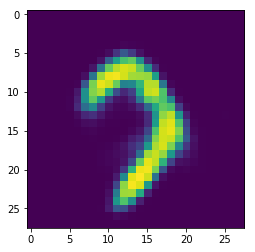

**********result at Epoch 67 Step 200*************


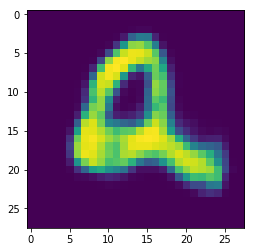

**********result at Epoch 67 Step 300*************


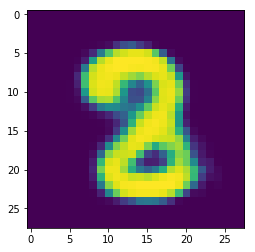

**********result at Epoch 67 Step 400*************


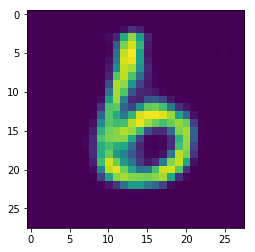

***epoch 68, step 0: total loss: 93.36536407470703, E_loss: 74.3087158203125, KL_loss:19.056650161743164
**********result at Epoch 68 Step 0*************


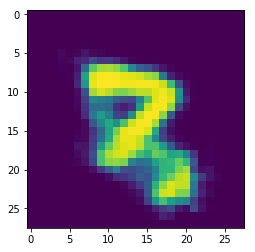

***epoch 68, step 50: total loss: 95.78948974609375, E_loss: 76.72563171386719, KL_loss:19.063858032226562
***epoch 68, step 100: total loss: 94.36343383789062, E_loss: 75.19903564453125, KL_loss:19.16439437866211
**********result at Epoch 68 Step 100*************


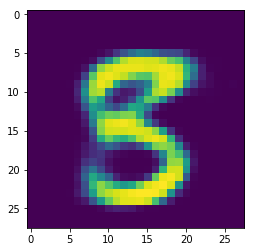

***epoch 68, step 150: total loss: 90.00958251953125, E_loss: 71.53437805175781, KL_loss:18.475204467773438
***epoch 68, step 200: total loss: 92.94345092773438, E_loss: 73.50189208984375, KL_loss:19.441558837890625
**********result at Epoch 68 Step 200*************


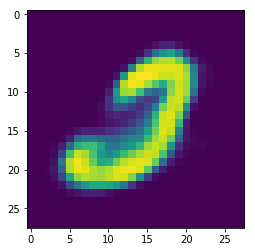

***epoch 68, step 250: total loss: 97.37374877929688, E_loss: 78.29257202148438, KL_loss:19.081172943115234
***epoch 68, step 300: total loss: 97.33226776123047, E_loss: 77.80169677734375, KL_loss:19.53057289123535
**********result at Epoch 68 Step 300*************


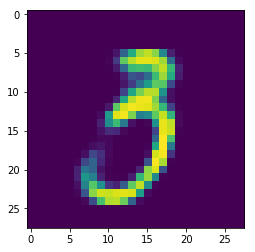

***epoch 68, step 350: total loss: 97.02918243408203, E_loss: 77.4238510131836, KL_loss:19.60533332824707
***epoch 68, step 400: total loss: 95.22218322753906, E_loss: 75.36457061767578, KL_loss:19.857608795166016
**********result at Epoch 68 Step 400*************


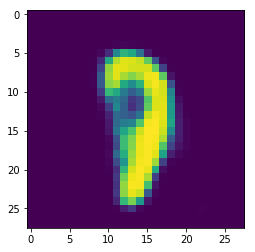

**********result at Epoch 69 Step 0*************


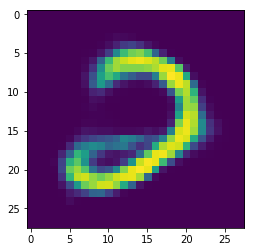

**********result at Epoch 69 Step 100*************


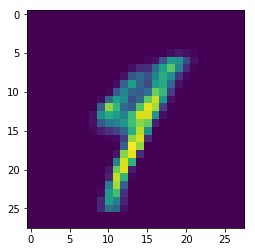

**********result at Epoch 69 Step 200*************


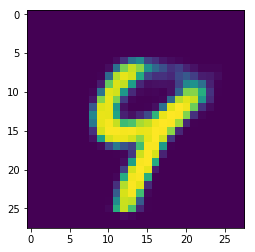

**********result at Epoch 69 Step 300*************


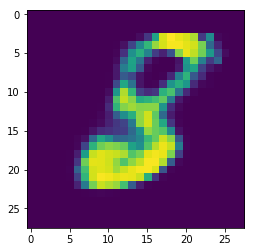

**********result at Epoch 69 Step 400*************


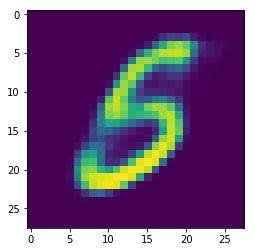

***epoch 70, step 0: total loss: 93.40568542480469, E_loss: 74.17044830322266, KL_loss:19.235233306884766
**********result at Epoch 70 Step 0*************


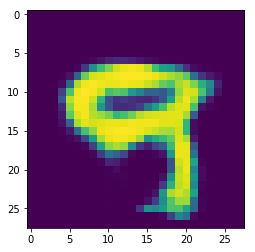

***epoch 70, step 50: total loss: 96.07957458496094, E_loss: 77.11266326904297, KL_loss:18.96691131591797
***epoch 70, step 100: total loss: 93.9505844116211, E_loss: 74.7080078125, KL_loss:19.24257469177246
**********result at Epoch 70 Step 100*************


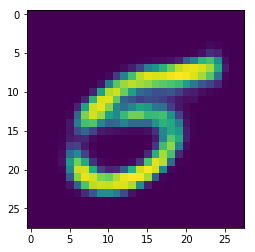

***epoch 70, step 150: total loss: 89.975830078125, E_loss: 71.48026275634766, KL_loss:18.49557113647461
***epoch 70, step 200: total loss: 93.79391479492188, E_loss: 74.60492706298828, KL_loss:19.188987731933594
**********result at Epoch 70 Step 200*************


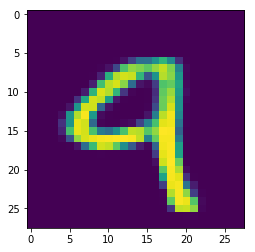

***epoch 70, step 250: total loss: 97.50166320800781, E_loss: 78.0228500366211, KL_loss:19.47881317138672
***epoch 70, step 300: total loss: 97.11861419677734, E_loss: 77.53306579589844, KL_loss:19.58555030822754
**********result at Epoch 70 Step 300*************


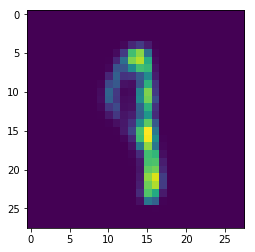

***epoch 70, step 350: total loss: 96.34896087646484, E_loss: 76.22445678710938, KL_loss:20.124502182006836
***epoch 70, step 400: total loss: 95.29173278808594, E_loss: 75.4536361694336, KL_loss:19.838092803955078
**********result at Epoch 70 Step 400*************


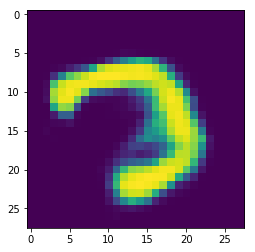

**********result at Epoch 71 Step 0*************


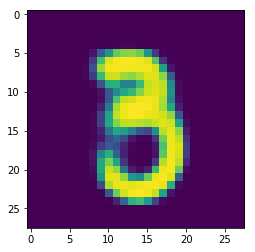

**********result at Epoch 71 Step 100*************


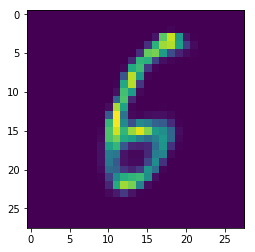

**********result at Epoch 71 Step 200*************


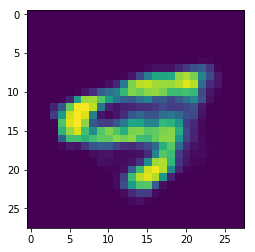

**********result at Epoch 71 Step 300*************


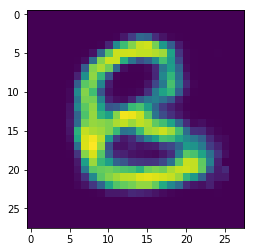

**********result at Epoch 71 Step 400*************


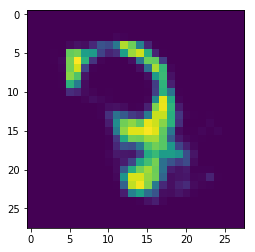

***epoch 72, step 0: total loss: 93.00302124023438, E_loss: 73.9625473022461, KL_loss:19.04047393798828
**********result at Epoch 72 Step 0*************


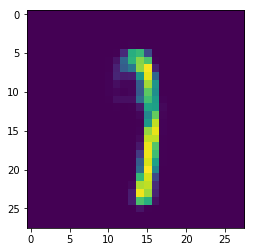

***epoch 72, step 50: total loss: 94.23945617675781, E_loss: 74.78350067138672, KL_loss:19.45595932006836
***epoch 72, step 100: total loss: 94.08353424072266, E_loss: 75.05361938476562, KL_loss:19.029916763305664
**********result at Epoch 72 Step 100*************


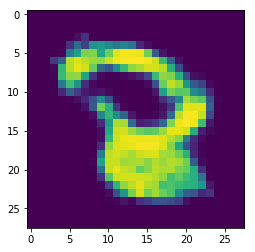

***epoch 72, step 150: total loss: 90.25859069824219, E_loss: 71.45504760742188, KL_loss:18.803546905517578
***epoch 72, step 200: total loss: 93.28628540039062, E_loss: 74.3618392944336, KL_loss:18.924442291259766
**********result at Epoch 72 Step 200*************


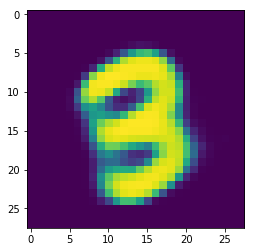

***epoch 72, step 250: total loss: 97.43425750732422, E_loss: 77.89518737792969, KL_loss:19.53907012939453
***epoch 72, step 300: total loss: 97.10297393798828, E_loss: 77.1751708984375, KL_loss:19.92780303955078
**********result at Epoch 72 Step 300*************


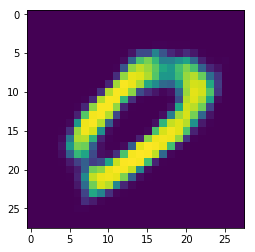

***epoch 72, step 350: total loss: 96.82865142822266, E_loss: 76.93632507324219, KL_loss:19.89232635498047
***epoch 72, step 400: total loss: 95.99259948730469, E_loss: 76.41371154785156, KL_loss:19.57888412475586
**********result at Epoch 72 Step 400*************


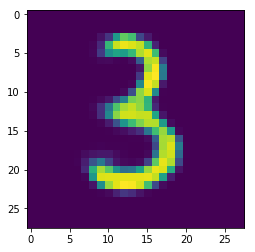

**********result at Epoch 73 Step 0*************


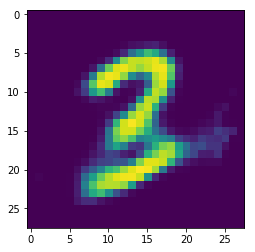

**********result at Epoch 73 Step 100*************


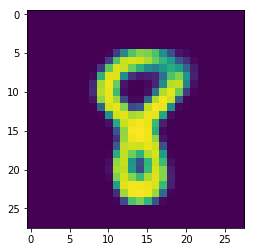

**********result at Epoch 73 Step 200*************


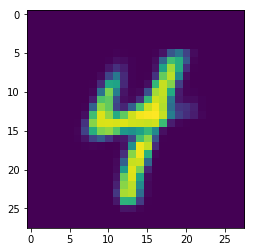

**********result at Epoch 73 Step 300*************


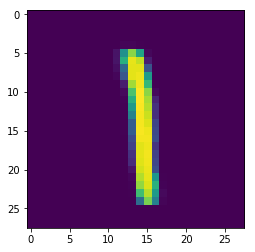

**********result at Epoch 73 Step 400*************


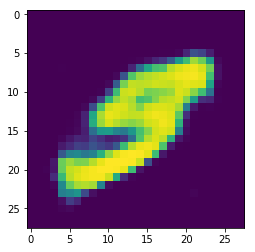

***epoch 74, step 0: total loss: 93.29198455810547, E_loss: 73.88211822509766, KL_loss:19.409866333007812
**********result at Epoch 74 Step 0*************


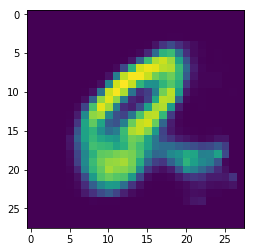

***epoch 74, step 50: total loss: 94.8934326171875, E_loss: 75.69624328613281, KL_loss:19.197187423706055
***epoch 74, step 100: total loss: 94.08934783935547, E_loss: 75.20909118652344, KL_loss:18.8802547454834
**********result at Epoch 74 Step 100*************


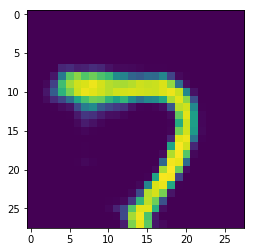

***epoch 74, step 150: total loss: 90.33087921142578, E_loss: 71.96417999267578, KL_loss:18.36669921875
***epoch 74, step 200: total loss: 93.08404541015625, E_loss: 73.70112609863281, KL_loss:19.382919311523438
**********result at Epoch 74 Step 200*************


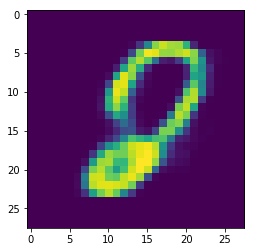

***epoch 74, step 250: total loss: 96.48886108398438, E_loss: 77.25282287597656, KL_loss:19.236034393310547
***epoch 74, step 300: total loss: 96.3568115234375, E_loss: 76.67021179199219, KL_loss:19.686603546142578
**********result at Epoch 74 Step 300*************


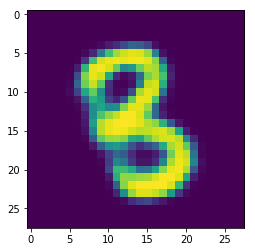

***epoch 74, step 350: total loss: 96.40054321289062, E_loss: 76.34442901611328, KL_loss:20.056114196777344
***epoch 74, step 400: total loss: 94.97476959228516, E_loss: 75.05137634277344, KL_loss:19.923391342163086
**********result at Epoch 74 Step 400*************


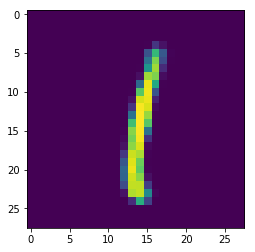

**********result at Epoch 75 Step 0*************


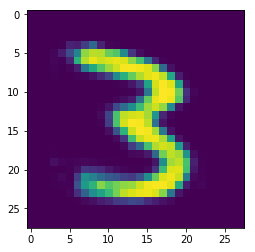

**********result at Epoch 75 Step 100*************


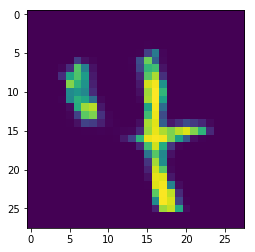

**********result at Epoch 75 Step 200*************


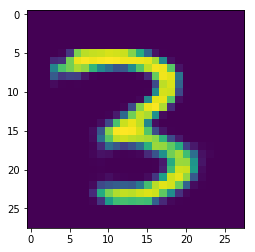

**********result at Epoch 75 Step 300*************


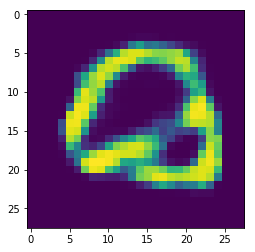

**********result at Epoch 75 Step 400*************


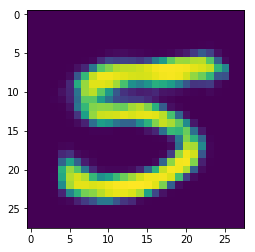

***epoch 76, step 0: total loss: 93.26377868652344, E_loss: 73.90933227539062, KL_loss:19.354450225830078
**********result at Epoch 76 Step 0*************


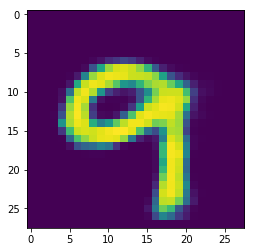

***epoch 76, step 50: total loss: 95.55005645751953, E_loss: 76.3974609375, KL_loss:19.1525936126709
***epoch 76, step 100: total loss: 93.61392974853516, E_loss: 74.42583465576172, KL_loss:19.188093185424805
**********result at Epoch 76 Step 100*************


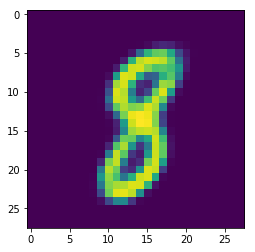

***epoch 76, step 150: total loss: 89.45350646972656, E_loss: 70.82479095458984, KL_loss:18.628719329833984
***epoch 76, step 200: total loss: 92.92211151123047, E_loss: 73.20098114013672, KL_loss:19.72113037109375
**********result at Epoch 76 Step 200*************


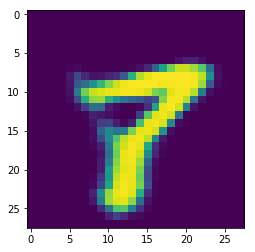

***epoch 76, step 250: total loss: 96.96565246582031, E_loss: 77.63336181640625, KL_loss:19.332294464111328
***epoch 76, step 300: total loss: 96.80113220214844, E_loss: 77.15577697753906, KL_loss:19.64535140991211
**********result at Epoch 76 Step 300*************


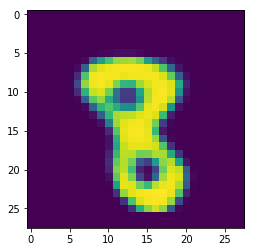

***epoch 76, step 350: total loss: 96.3507080078125, E_loss: 76.48594665527344, KL_loss:19.864765167236328
***epoch 76, step 400: total loss: 93.98674011230469, E_loss: 74.2791976928711, KL_loss:19.70754051208496
**********result at Epoch 76 Step 400*************


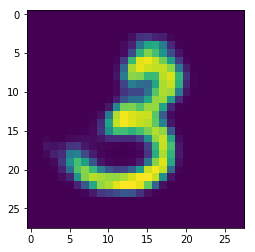

**********result at Epoch 77 Step 0*************


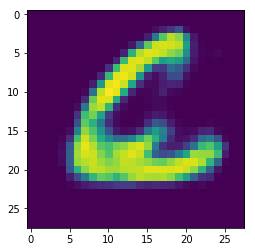

**********result at Epoch 77 Step 100*************


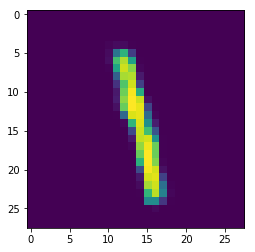

**********result at Epoch 77 Step 200*************


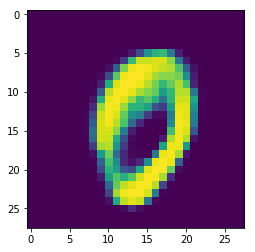

**********result at Epoch 77 Step 300*************


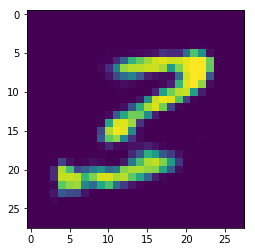

**********result at Epoch 77 Step 400*************


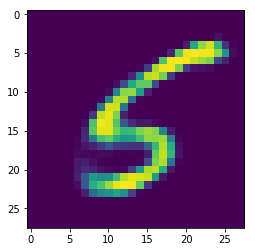

***epoch 78, step 0: total loss: 93.1299819946289, E_loss: 73.935546875, KL_loss:19.194435119628906
**********result at Epoch 78 Step 0*************


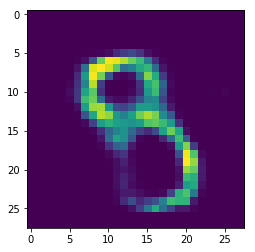

***epoch 78, step 50: total loss: 94.69880676269531, E_loss: 75.24459075927734, KL_loss:19.454219818115234
***epoch 78, step 100: total loss: 93.28754425048828, E_loss: 73.9747314453125, KL_loss:19.31281280517578
**********result at Epoch 78 Step 100*************


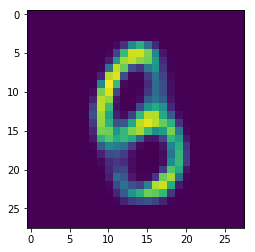

***epoch 78, step 150: total loss: 89.63609313964844, E_loss: 71.1347885131836, KL_loss:18.50130844116211
***epoch 78, step 200: total loss: 92.58041381835938, E_loss: 73.39869689941406, KL_loss:19.181716918945312
**********result at Epoch 78 Step 200*************


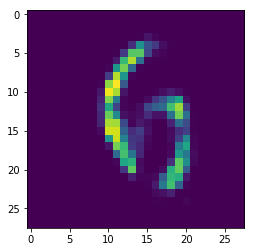

***epoch 78, step 250: total loss: 97.00627136230469, E_loss: 77.75533294677734, KL_loss:19.250938415527344
***epoch 78, step 300: total loss: 96.07808685302734, E_loss: 76.2729721069336, KL_loss:19.80511474609375
**********result at Epoch 78 Step 300*************


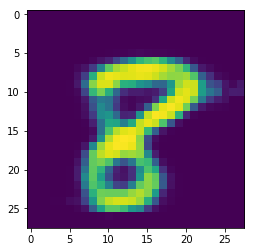

***epoch 78, step 350: total loss: 96.34386444091797, E_loss: 76.390625, KL_loss:19.953237533569336
***epoch 78, step 400: total loss: 95.0577392578125, E_loss: 75.28263854980469, KL_loss:19.775104522705078
**********result at Epoch 78 Step 400*************


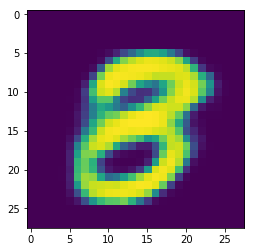

**********result at Epoch 79 Step 0*************


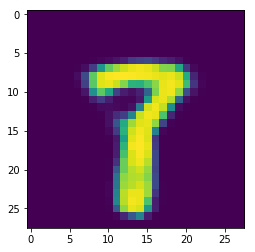

**********result at Epoch 79 Step 100*************


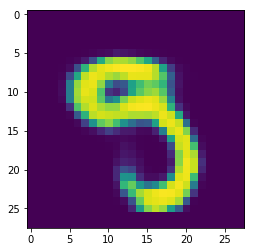

**********result at Epoch 79 Step 200*************


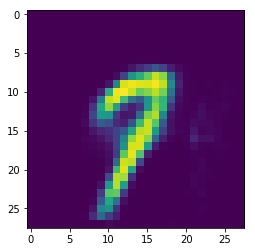

**********result at Epoch 79 Step 300*************


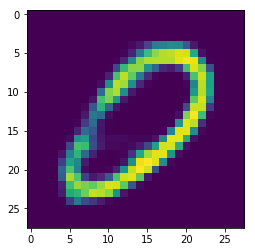

**********result at Epoch 79 Step 400*************


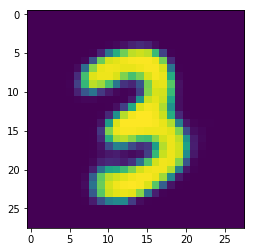

In [4]:
train_f=trains/255
myvae=VAE(batch_size=100,z_size=20)
train(train_f,myvae,100,80)

Instructions for updating:
Please use tf.global_variables instead.
***epoch 0, step 0: total loss: 601.6321411132812, E_loss: 599.631103515625, KL_loss:2.0010600090026855
**********result at Epoch 0 Step 0*************


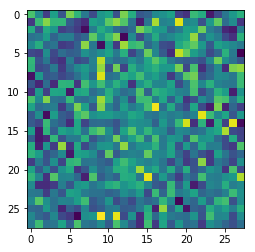

***epoch 0, step 50: total loss: 209.13424682617188, E_loss: 209.10733032226562, KL_loss:0.026910487562417984
***epoch 0, step 100: total loss: 204.65843200683594, E_loss: 204.47299194335938, KL_loss:0.1854408085346222
**********result at Epoch 0 Step 100*************


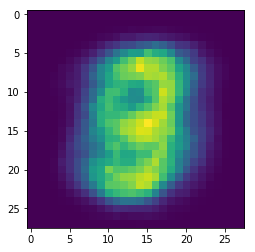

***epoch 0, step 150: total loss: 187.87208557128906, E_loss: 184.26321411132812, KL_loss:3.6088647842407227
***epoch 0, step 200: total loss: 189.62631225585938, E_loss: 186.55599975585938, KL_loss:3.070312976837158
**********result at Epoch 0 Step 200*************


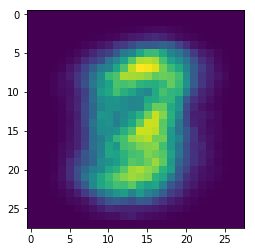

***epoch 0, step 250: total loss: 188.37582397460938, E_loss: 185.21128845214844, KL_loss:3.1645426750183105
***epoch 0, step 300: total loss: 184.94407653808594, E_loss: 181.10427856445312, KL_loss:3.839797258377075
**********result at Epoch 0 Step 300*************


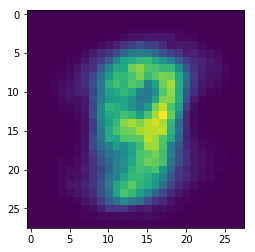

***epoch 0, step 350: total loss: 182.83399963378906, E_loss: 178.7015380859375, KL_loss:4.1324567794799805
***epoch 0, step 400: total loss: 170.11306762695312, E_loss: 165.83656311035156, KL_loss:4.276501655578613
**********result at Epoch 0 Step 400*************


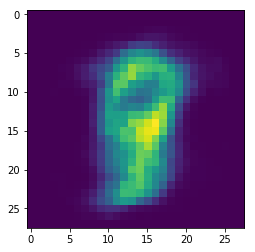

**********result at Epoch 1 Step 0*************


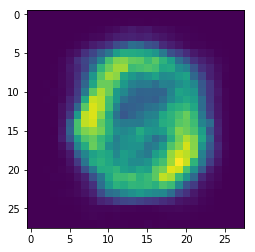

**********result at Epoch 1 Step 100*************


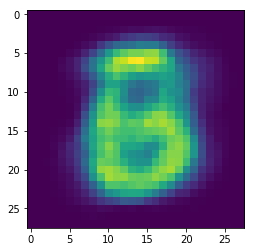

**********result at Epoch 1 Step 200*************


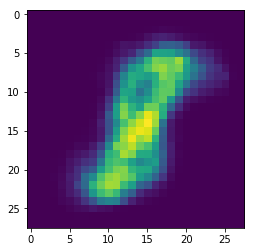

**********result at Epoch 1 Step 300*************


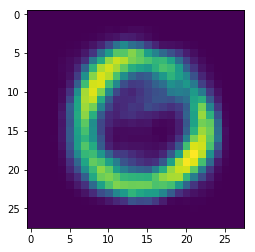

**********result at Epoch 1 Step 400*************


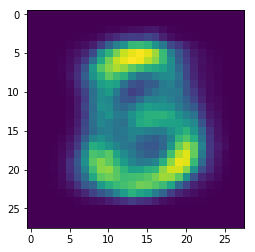

***epoch 2, step 0: total loss: 159.81863403320312, E_loss: 155.07875061035156, KL_loss:4.739877700805664
**********result at Epoch 2 Step 0*************


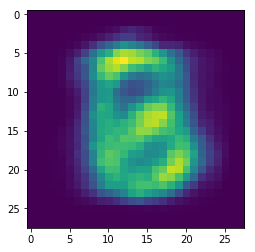

***epoch 2, step 50: total loss: 163.88070678710938, E_loss: 158.56756591796875, KL_loss:5.313148498535156
***epoch 2, step 100: total loss: 161.75946044921875, E_loss: 156.67555236816406, KL_loss:5.0839128494262695
**********result at Epoch 2 Step 100*************


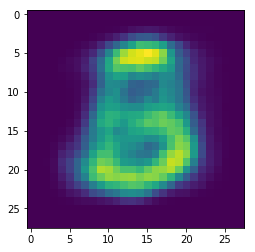

***epoch 2, step 150: total loss: 152.3605194091797, E_loss: 147.43724060058594, KL_loss:4.92327880859375
***epoch 2, step 200: total loss: 158.12893676757812, E_loss: 152.89437866210938, KL_loss:5.234562397003174
**********result at Epoch 2 Step 200*************


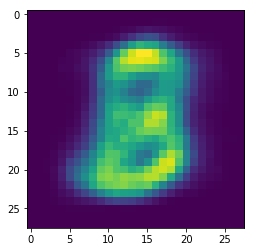

***epoch 2, step 250: total loss: 164.8878936767578, E_loss: 160.13308715820312, KL_loss:4.754799842834473
***epoch 2, step 300: total loss: 165.42953491210938, E_loss: 160.29379272460938, KL_loss:5.135747909545898
**********result at Epoch 2 Step 300*************


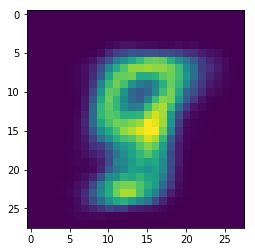

***epoch 2, step 350: total loss: 166.31332397460938, E_loss: 161.5675048828125, KL_loss:4.74581241607666
***epoch 2, step 400: total loss: 158.92103576660156, E_loss: 154.1418914794922, KL_loss:4.779144287109375
**********result at Epoch 2 Step 400*************


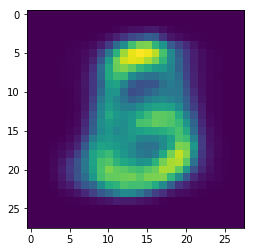

**********result at Epoch 3 Step 0*************


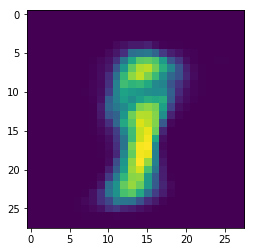

**********result at Epoch 3 Step 100*************


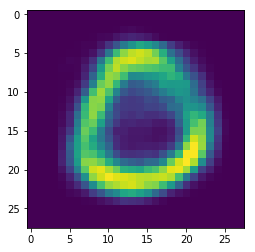

**********result at Epoch 3 Step 200*************


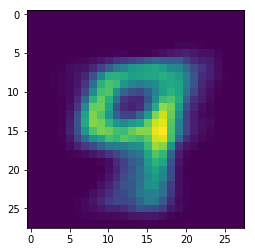

**********result at Epoch 3 Step 300*************


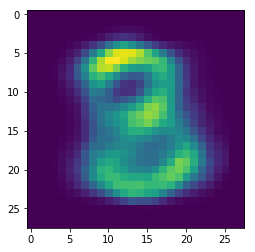

**********result at Epoch 3 Step 400*************


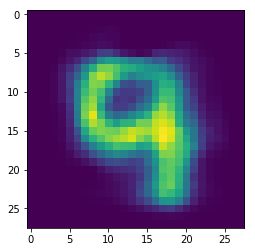

***epoch 4, step 0: total loss: 152.07122802734375, E_loss: 146.7067413330078, KL_loss:5.364485263824463
**********result at Epoch 4 Step 0*************


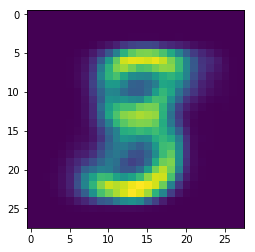

***epoch 4, step 50: total loss: 155.31393432617188, E_loss: 149.95509338378906, KL_loss:5.3588361740112305
***epoch 4, step 100: total loss: 155.3476104736328, E_loss: 150.07012939453125, KL_loss:5.2774858474731445
**********result at Epoch 4 Step 100*************


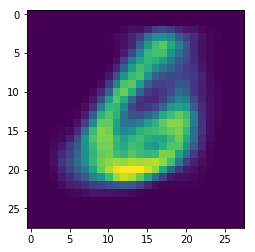

***epoch 4, step 150: total loss: 146.379150390625, E_loss: 141.1974639892578, KL_loss:5.181680202484131
***epoch 4, step 200: total loss: 152.60098266601562, E_loss: 146.75299072265625, KL_loss:5.847987651824951
**********result at Epoch 4 Step 200*************


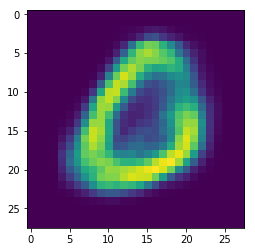

***epoch 4, step 250: total loss: 159.2781524658203, E_loss: 153.85150146484375, KL_loss:5.426653861999512
***epoch 4, step 300: total loss: 157.32574462890625, E_loss: 152.0730438232422, KL_loss:5.252701759338379
**********result at Epoch 4 Step 300*************


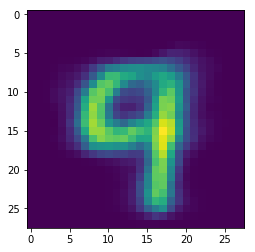

***epoch 4, step 350: total loss: 161.98558044433594, E_loss: 156.69888305664062, KL_loss:5.286694526672363
***epoch 4, step 400: total loss: 154.75021362304688, E_loss: 149.58738708496094, KL_loss:5.162829399108887
**********result at Epoch 4 Step 400*************


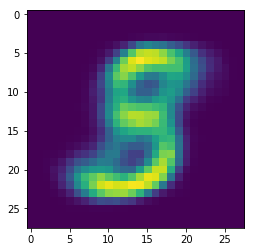

**********result at Epoch 5 Step 0*************


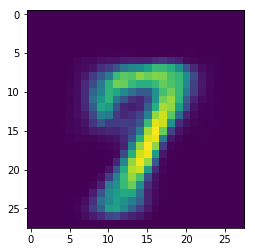

**********result at Epoch 5 Step 100*************


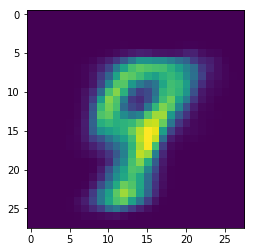

**********result at Epoch 5 Step 200*************


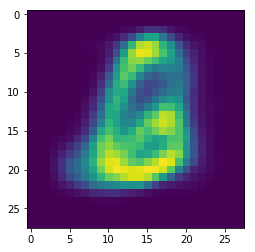

**********result at Epoch 5 Step 300*************


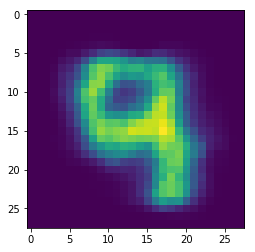

**********result at Epoch 5 Step 400*************


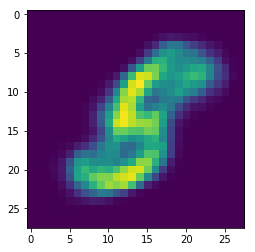

***epoch 6, step 0: total loss: 149.2235107421875, E_loss: 143.63768005371094, KL_loss:5.585832595825195
**********result at Epoch 6 Step 0*************


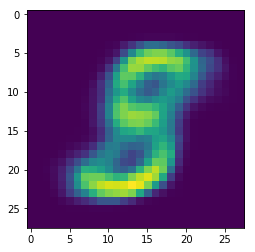

***epoch 6, step 50: total loss: 151.34304809570312, E_loss: 145.8441619873047, KL_loss:5.4988789558410645
***epoch 6, step 100: total loss: 152.2321319580078, E_loss: 146.71670532226562, KL_loss:5.51542854309082
**********result at Epoch 6 Step 100*************


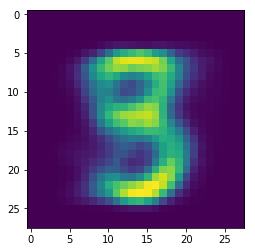

***epoch 6, step 150: total loss: 142.4208526611328, E_loss: 136.6907958984375, KL_loss:5.730055332183838
***epoch 6, step 200: total loss: 148.2698974609375, E_loss: 142.30453491210938, KL_loss:5.965363502502441
**********result at Epoch 6 Step 200*************


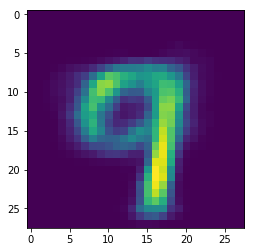

***epoch 6, step 250: total loss: 155.9740753173828, E_loss: 150.34852600097656, KL_loss:5.625548362731934
***epoch 6, step 300: total loss: 152.37908935546875, E_loss: 146.72286987304688, KL_loss:5.656224250793457
**********result at Epoch 6 Step 300*************


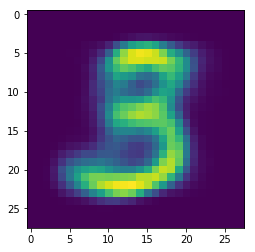

***epoch 6, step 350: total loss: 159.02381896972656, E_loss: 153.6717071533203, KL_loss:5.352109432220459
***epoch 6, step 400: total loss: 152.02294921875, E_loss: 146.50778198242188, KL_loss:5.51516056060791
**********result at Epoch 6 Step 400*************


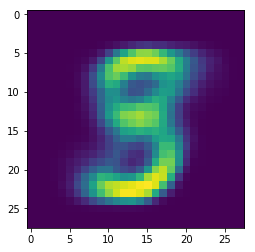

**********result at Epoch 7 Step 0*************


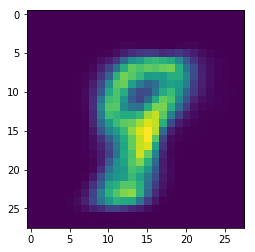

**********result at Epoch 7 Step 100*************


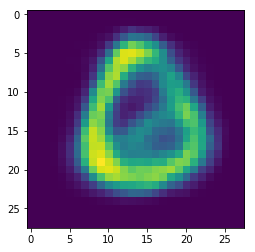

**********result at Epoch 7 Step 200*************


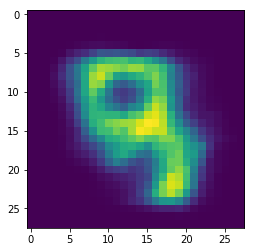

**********result at Epoch 7 Step 300*************


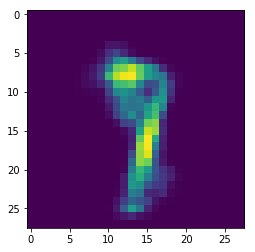

**********result at Epoch 7 Step 400*************


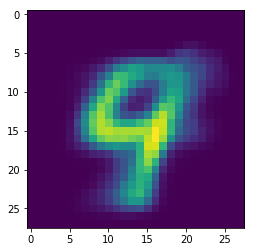

***epoch 8, step 0: total loss: 146.05831909179688, E_loss: 140.2371826171875, KL_loss:5.821141242980957
**********result at Epoch 8 Step 0*************


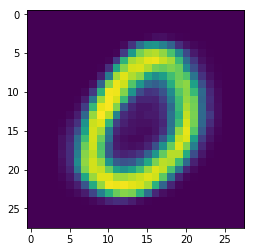

***epoch 8, step 50: total loss: 149.79615783691406, E_loss: 143.8606414794922, KL_loss:5.9355149269104
***epoch 8, step 100: total loss: 149.13670349121094, E_loss: 143.4541015625, KL_loss:5.682603359222412
**********result at Epoch 8 Step 100*************


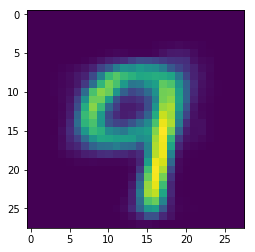

***epoch 8, step 150: total loss: 141.18829345703125, E_loss: 135.5161590576172, KL_loss:5.6721272468566895
***epoch 8, step 200: total loss: 146.2154541015625, E_loss: 140.1542510986328, KL_loss:6.0612101554870605
**********result at Epoch 8 Step 200*************


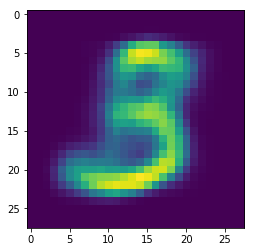

***epoch 8, step 250: total loss: 152.73123168945312, E_loss: 146.9549560546875, KL_loss:5.776268005371094
***epoch 8, step 300: total loss: 149.5964813232422, E_loss: 143.8356475830078, KL_loss:5.760838031768799
**********result at Epoch 8 Step 300*************


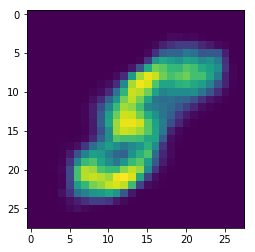

***epoch 8, step 350: total loss: 156.89691162109375, E_loss: 151.26626586914062, KL_loss:5.630648612976074
***epoch 8, step 400: total loss: 149.55908203125, E_loss: 144.04800415039062, KL_loss:5.511085033416748
**********result at Epoch 8 Step 400*************


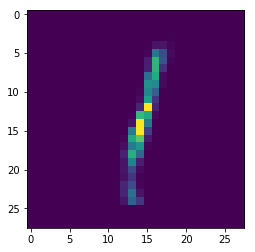

**********result at Epoch 9 Step 0*************


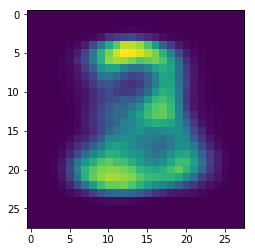

**********result at Epoch 9 Step 100*************


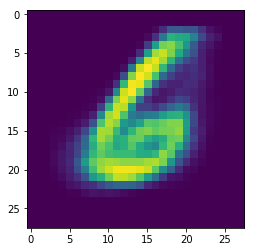

**********result at Epoch 9 Step 200*************


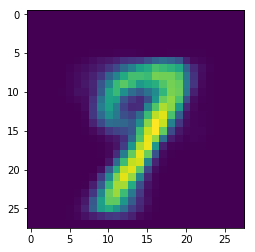

**********result at Epoch 9 Step 300*************


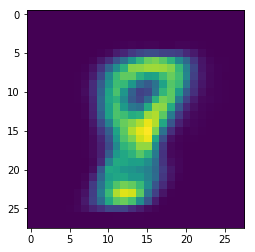

**********result at Epoch 9 Step 400*************


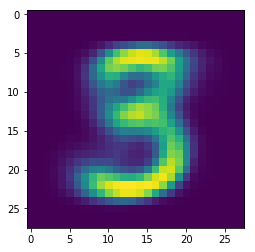

***epoch 10, step 0: total loss: 144.1024169921875, E_loss: 138.147705078125, KL_loss:5.954719543457031
**********result at Epoch 10 Step 0*************


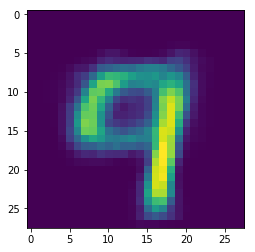

***epoch 10, step 50: total loss: 148.26547241210938, E_loss: 142.2119903564453, KL_loss:6.053479194641113
***epoch 10, step 100: total loss: 147.69845581054688, E_loss: 141.8563232421875, KL_loss:5.842127799987793
**********result at Epoch 10 Step 100*************


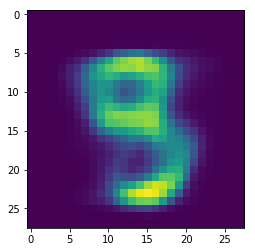

***epoch 10, step 150: total loss: 138.8212890625, E_loss: 132.84849548339844, KL_loss:5.972794055938721
***epoch 10, step 200: total loss: 143.93621826171875, E_loss: 137.82049560546875, KL_loss:6.115724563598633
**********result at Epoch 10 Step 200*************


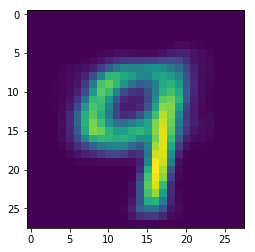

***epoch 10, step 250: total loss: 150.88787841796875, E_loss: 144.90660095214844, KL_loss:5.981271743774414
***epoch 10, step 300: total loss: 148.5, E_loss: 142.3855438232422, KL_loss:6.114453315734863
**********result at Epoch 10 Step 300*************


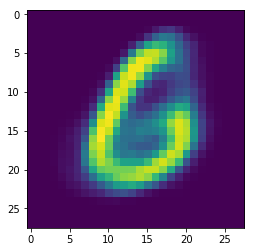

***epoch 10, step 350: total loss: 154.27984619140625, E_loss: 148.63888549804688, KL_loss:5.640967845916748
***epoch 10, step 400: total loss: 148.08792114257812, E_loss: 142.32095336914062, KL_loss:5.766970157623291
**********result at Epoch 10 Step 400*************


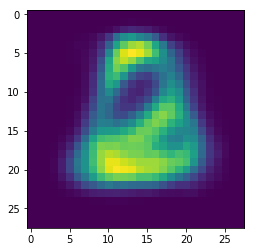

**********result at Epoch 11 Step 0*************


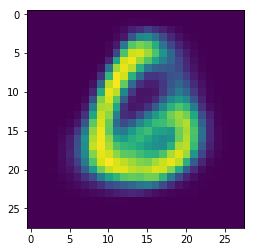

**********result at Epoch 11 Step 100*************


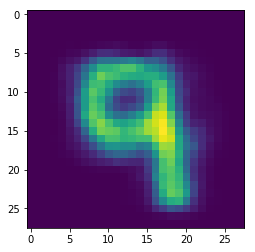

**********result at Epoch 11 Step 200*************


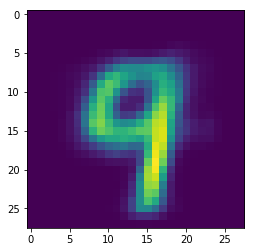

**********result at Epoch 11 Step 300*************


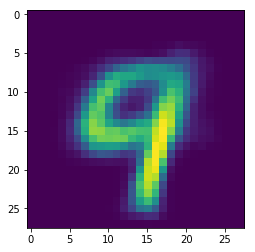

**********result at Epoch 11 Step 400*************


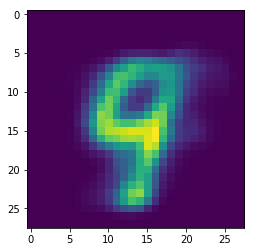

***epoch 12, step 0: total loss: 143.3165283203125, E_loss: 137.3385009765625, KL_loss:5.978028297424316
**********result at Epoch 12 Step 0*************


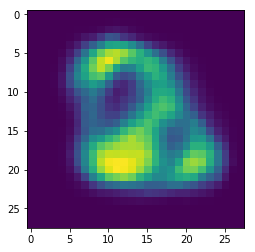

***epoch 12, step 50: total loss: 146.5495147705078, E_loss: 140.44216918945312, KL_loss:6.1073408126831055
***epoch 12, step 100: total loss: 147.11639404296875, E_loss: 141.12110900878906, KL_loss:5.9952921867370605
**********result at Epoch 12 Step 100*************


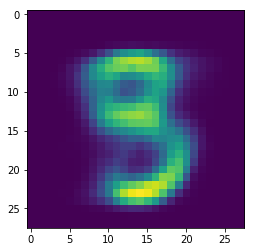

***epoch 12, step 150: total loss: 137.14625549316406, E_loss: 131.03683471679688, KL_loss:6.109420299530029
***epoch 12, step 200: total loss: 143.02651977539062, E_loss: 136.6974334716797, KL_loss:6.329090118408203
**********result at Epoch 12 Step 200*************


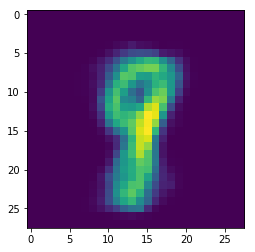

***epoch 12, step 250: total loss: 148.7616729736328, E_loss: 142.69363403320312, KL_loss:6.068034648895264
***epoch 12, step 300: total loss: 147.1916961669922, E_loss: 141.1680450439453, KL_loss:6.023650169372559
**********result at Epoch 12 Step 300*************


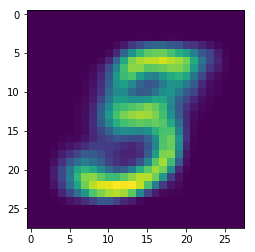

***epoch 12, step 350: total loss: 152.73745727539062, E_loss: 146.76919555664062, KL_loss:5.968259811401367
***epoch 12, step 400: total loss: 146.87208557128906, E_loss: 141.0394744873047, KL_loss:5.832609176635742
**********result at Epoch 12 Step 400*************


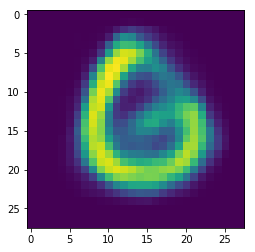

**********result at Epoch 13 Step 0*************


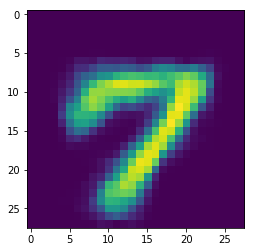

**********result at Epoch 13 Step 100*************


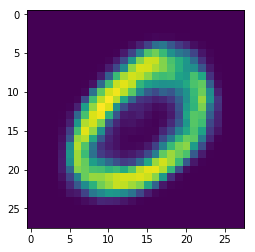

**********result at Epoch 13 Step 200*************


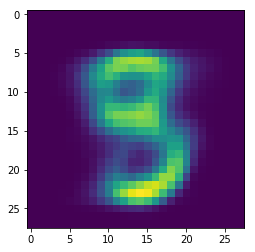

**********result at Epoch 13 Step 300*************


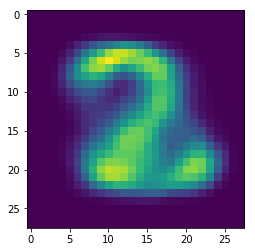

**********result at Epoch 13 Step 400*************


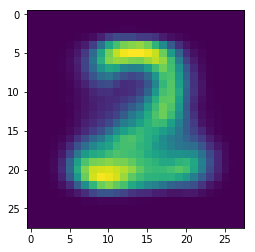

***epoch 14, step 0: total loss: 142.58090209960938, E_loss: 136.5411376953125, KL_loss:6.039767742156982
**********result at Epoch 14 Step 0*************


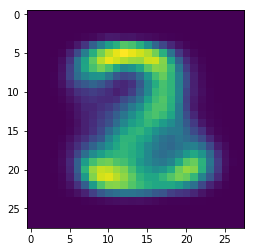

***epoch 14, step 50: total loss: 145.73458862304688, E_loss: 139.48391723632812, KL_loss:6.250670433044434
***epoch 14, step 100: total loss: 145.46229553222656, E_loss: 139.43113708496094, KL_loss:6.031164646148682
**********result at Epoch 14 Step 100*************


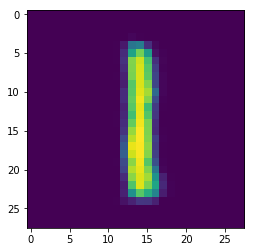

***epoch 14, step 150: total loss: 135.68479919433594, E_loss: 129.52777099609375, KL_loss:6.157033443450928
***epoch 14, step 200: total loss: 141.824462890625, E_loss: 135.54708862304688, KL_loss:6.277369976043701
**********result at Epoch 14 Step 200*************


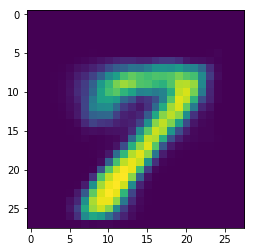

***epoch 14, step 250: total loss: 147.88446044921875, E_loss: 141.82530212402344, KL_loss:6.059153079986572
***epoch 14, step 300: total loss: 145.38352966308594, E_loss: 139.17286682128906, KL_loss:6.21065616607666
**********result at Epoch 14 Step 300*************


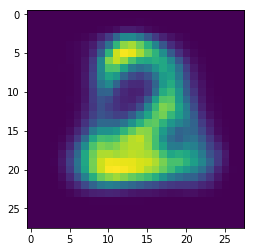

***epoch 14, step 350: total loss: 151.17601013183594, E_loss: 145.23033142089844, KL_loss:5.945683479309082
***epoch 14, step 400: total loss: 145.74716186523438, E_loss: 139.802978515625, KL_loss:5.944177627563477
**********result at Epoch 14 Step 400*************


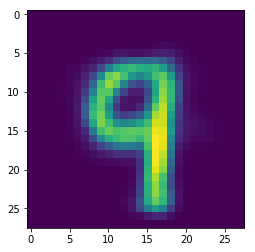

**********result at Epoch 15 Step 0*************


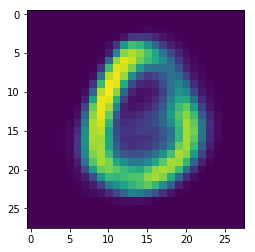

**********result at Epoch 15 Step 100*************


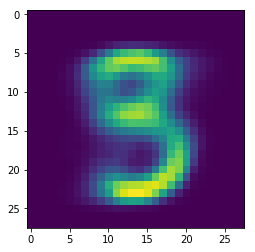

**********result at Epoch 15 Step 200*************


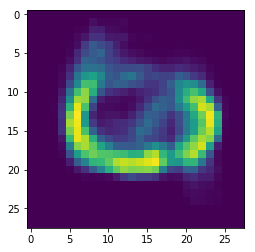

**********result at Epoch 15 Step 300*************


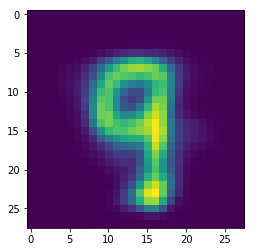

**********result at Epoch 15 Step 400*************


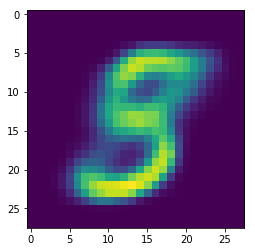

***epoch 16, step 0: total loss: 140.91848754882812, E_loss: 134.778076171875, KL_loss:6.140411376953125
**********result at Epoch 16 Step 0*************


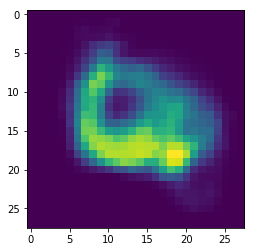

***epoch 16, step 50: total loss: 145.12640380859375, E_loss: 138.86944580078125, KL_loss:6.256955146789551
***epoch 16, step 100: total loss: 144.81155395507812, E_loss: 138.69500732421875, KL_loss:6.116552829742432
**********result at Epoch 16 Step 100*************


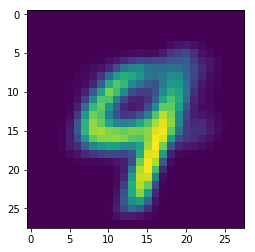

***epoch 16, step 150: total loss: 134.7349090576172, E_loss: 128.52597045898438, KL_loss:6.208938121795654
***epoch 16, step 200: total loss: 141.227294921875, E_loss: 134.91339111328125, KL_loss:6.313906669616699
**********result at Epoch 16 Step 200*************


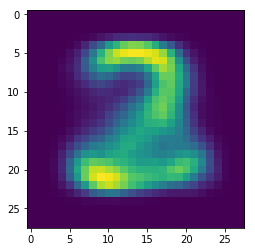

***epoch 16, step 250: total loss: 146.42529296875, E_loss: 140.36570739746094, KL_loss:6.0595903396606445
***epoch 16, step 300: total loss: 144.397705078125, E_loss: 138.14727783203125, KL_loss:6.250425815582275
**********result at Epoch 16 Step 300*************


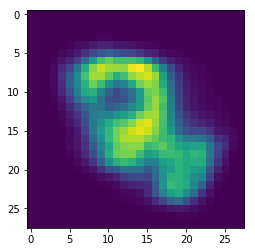

***epoch 16, step 350: total loss: 149.6356201171875, E_loss: 143.65231323242188, KL_loss:5.983309745788574
***epoch 16, step 400: total loss: 145.35398864746094, E_loss: 139.41586303710938, KL_loss:5.938122272491455
**********result at Epoch 16 Step 400*************


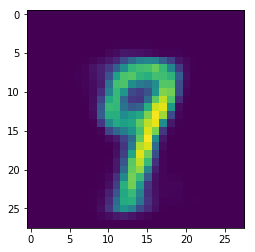

**********result at Epoch 17 Step 0*************


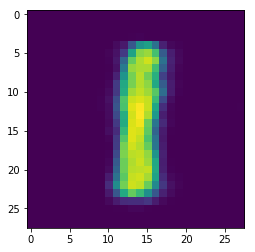

**********result at Epoch 17 Step 100*************


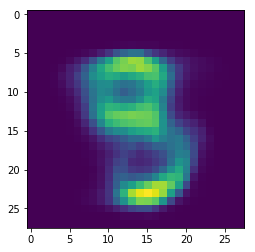

**********result at Epoch 17 Step 200*************


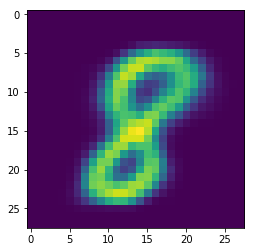

**********result at Epoch 17 Step 300*************


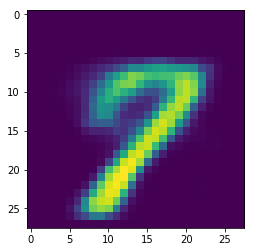

**********result at Epoch 17 Step 400*************


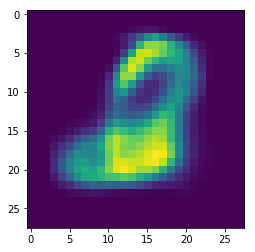

***epoch 18, step 0: total loss: 140.7356719970703, E_loss: 134.52999877929688, KL_loss:6.205677032470703
**********result at Epoch 18 Step 0*************


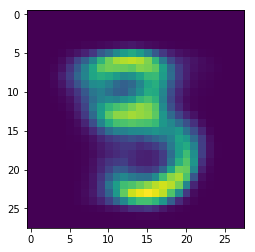

***epoch 18, step 50: total loss: 144.15875244140625, E_loss: 137.85711669921875, KL_loss:6.301630973815918
***epoch 18, step 100: total loss: 144.06402587890625, E_loss: 138.0234832763672, KL_loss:6.040535926818848
**********result at Epoch 18 Step 100*************


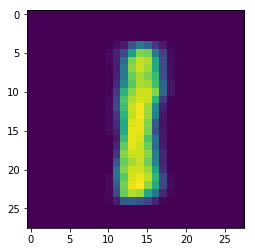

***epoch 18, step 150: total loss: 132.8450927734375, E_loss: 126.6438217163086, KL_loss:6.201274871826172
***epoch 18, step 200: total loss: 140.52059936523438, E_loss: 134.0018310546875, KL_loss:6.51877498626709
**********result at Epoch 18 Step 200*************


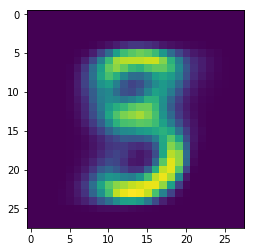

***epoch 18, step 250: total loss: 146.3897705078125, E_loss: 140.35354614257812, KL_loss:6.036224365234375
***epoch 18, step 300: total loss: 143.56756591796875, E_loss: 137.26223754882812, KL_loss:6.305324077606201
**********result at Epoch 18 Step 300*************


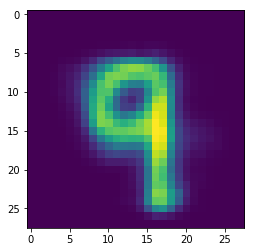

***epoch 18, step 350: total loss: 148.68092346191406, E_loss: 142.57550048828125, KL_loss:6.105422019958496
***epoch 18, step 400: total loss: 144.18978881835938, E_loss: 138.02841186523438, KL_loss:6.161371231079102
**********result at Epoch 18 Step 400*************


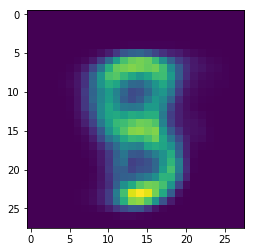

**********result at Epoch 19 Step 0*************


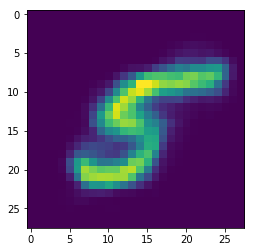

**********result at Epoch 19 Step 100*************


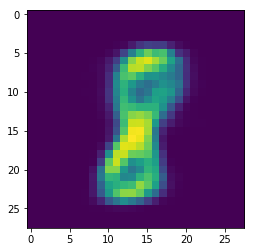

**********result at Epoch 19 Step 200*************


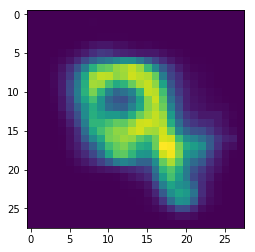

**********result at Epoch 19 Step 300*************


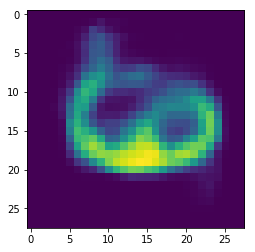

**********result at Epoch 19 Step 400*************


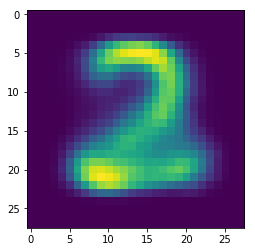

***epoch 20, step 0: total loss: 140.1029510498047, E_loss: 133.7332000732422, KL_loss:6.369746685028076
**********result at Epoch 20 Step 0*************


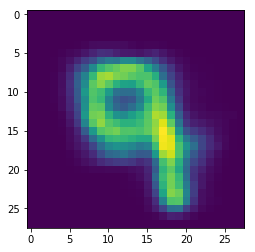

***epoch 20, step 50: total loss: 143.09295654296875, E_loss: 136.80784606933594, KL_loss:6.285118103027344
***epoch 20, step 100: total loss: 143.0831298828125, E_loss: 136.90911865234375, KL_loss:6.174013137817383
**********result at Epoch 20 Step 100*************


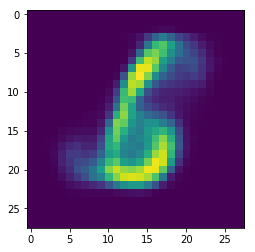

***epoch 20, step 150: total loss: 132.3268585205078, E_loss: 125.99630737304688, KL_loss:6.3305463790893555
***epoch 20, step 200: total loss: 140.595703125, E_loss: 134.1218719482422, KL_loss:6.473836421966553
**********result at Epoch 20 Step 200*************


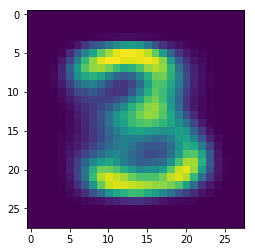

***epoch 20, step 250: total loss: 145.24368286132812, E_loss: 139.09202575683594, KL_loss:6.151660919189453
***epoch 20, step 300: total loss: 142.85574340820312, E_loss: 136.5950927734375, KL_loss:6.260653972625732
**********result at Epoch 20 Step 300*************


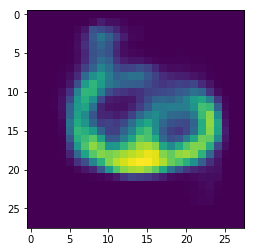

***epoch 20, step 350: total loss: 148.51580810546875, E_loss: 142.28622436523438, KL_loss:6.229586601257324
***epoch 20, step 400: total loss: 143.66978454589844, E_loss: 137.5253448486328, KL_loss:6.144439220428467
**********result at Epoch 20 Step 400*************


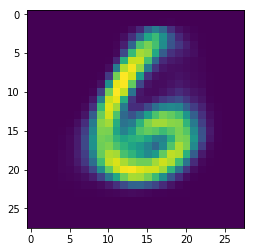

**********result at Epoch 21 Step 0*************


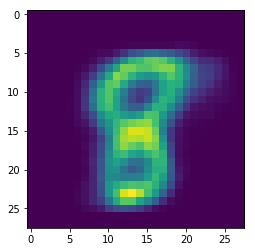

**********result at Epoch 21 Step 100*************


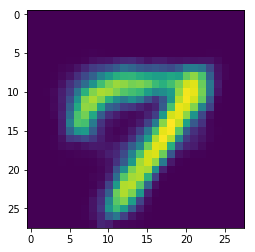

**********result at Epoch 21 Step 200*************


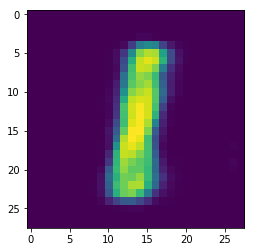

**********result at Epoch 21 Step 300*************


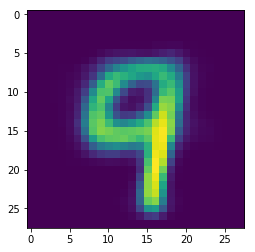

**********result at Epoch 21 Step 400*************


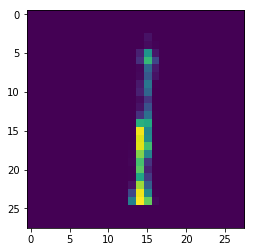

***epoch 22, step 0: total loss: 139.734375, E_loss: 133.59144592285156, KL_loss:6.142936706542969
**********result at Epoch 22 Step 0*************


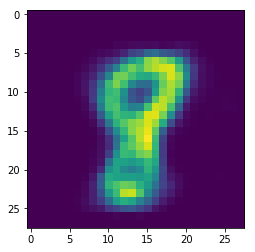

***epoch 22, step 50: total loss: 142.93887329101562, E_loss: 136.50352478027344, KL_loss:6.4353437423706055
***epoch 22, step 100: total loss: 142.4973602294922, E_loss: 136.34750366210938, KL_loss:6.149860382080078
**********result at Epoch 22 Step 100*************


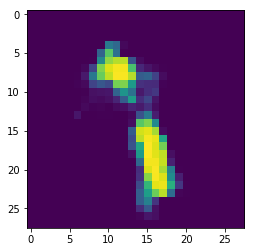

***epoch 22, step 150: total loss: 130.885986328125, E_loss: 124.54319763183594, KL_loss:6.342794895172119
***epoch 22, step 200: total loss: 140.0369873046875, E_loss: 133.56436157226562, KL_loss:6.472629547119141
**********result at Epoch 22 Step 200*************


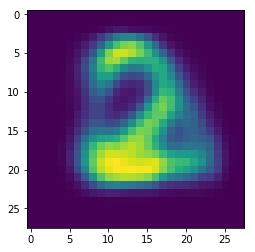

***epoch 22, step 250: total loss: 144.96742248535156, E_loss: 138.64907836914062, KL_loss:6.3183441162109375
***epoch 22, step 300: total loss: 142.24290466308594, E_loss: 135.81838989257812, KL_loss:6.4245123863220215
**********result at Epoch 22 Step 300*************


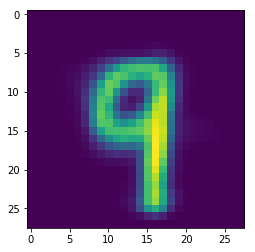

***epoch 22, step 350: total loss: 147.639404296875, E_loss: 141.44119262695312, KL_loss:6.198210716247559
***epoch 22, step 400: total loss: 142.66561889648438, E_loss: 136.47305297851562, KL_loss:6.192559719085693
**********result at Epoch 22 Step 400*************


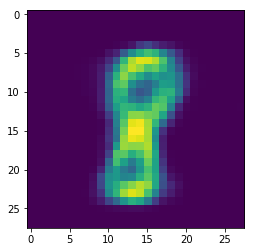

**********result at Epoch 23 Step 0*************


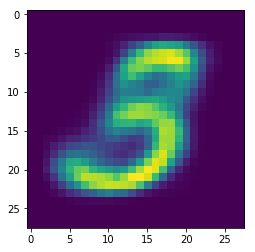

**********result at Epoch 23 Step 100*************


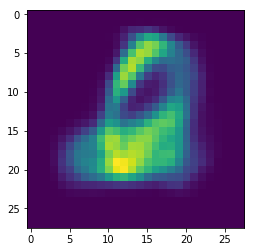

**********result at Epoch 23 Step 200*************


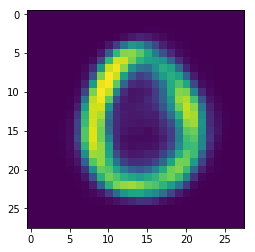

**********result at Epoch 23 Step 300*************


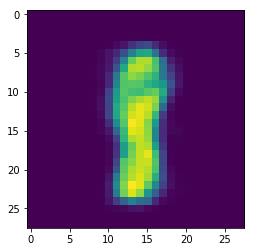

**********result at Epoch 23 Step 400*************


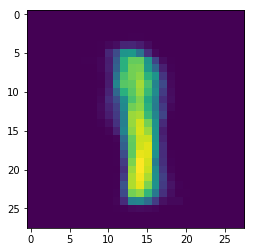

***epoch 24, step 0: total loss: 138.7037811279297, E_loss: 132.39834594726562, KL_loss:6.305431842803955
**********result at Epoch 24 Step 0*************


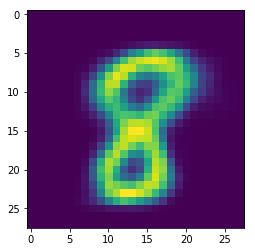

***epoch 24, step 50: total loss: 142.6758575439453, E_loss: 136.23663330078125, KL_loss:6.439225196838379
***epoch 24, step 100: total loss: 141.57913208007812, E_loss: 135.3150634765625, KL_loss:6.264064788818359
**********result at Epoch 24 Step 100*************


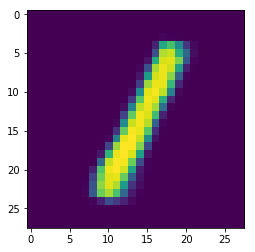

***epoch 24, step 150: total loss: 130.84678649902344, E_loss: 124.49629974365234, KL_loss:6.350485324859619
***epoch 24, step 200: total loss: 139.4276123046875, E_loss: 132.86947631835938, KL_loss:6.55814266204834
**********result at Epoch 24 Step 200*************


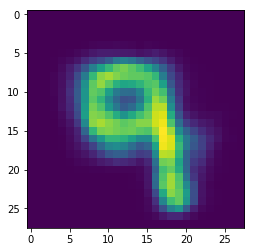

***epoch 24, step 250: total loss: 145.07325744628906, E_loss: 138.9439697265625, KL_loss:6.129292964935303
***epoch 24, step 300: total loss: 141.84609985351562, E_loss: 135.37904357910156, KL_loss:6.467055797576904
**********result at Epoch 24 Step 300*************


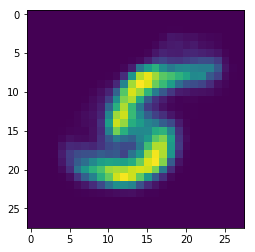

***epoch 24, step 350: total loss: 146.85202026367188, E_loss: 140.69554138183594, KL_loss:6.156478404998779
***epoch 24, step 400: total loss: 141.78475952148438, E_loss: 135.58961486816406, KL_loss:6.195146560668945
**********result at Epoch 24 Step 400*************


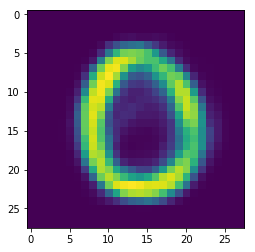

**********result at Epoch 25 Step 0*************


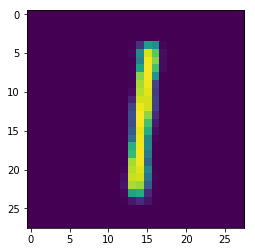

**********result at Epoch 25 Step 100*************


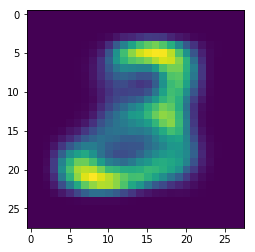

**********result at Epoch 25 Step 200*************


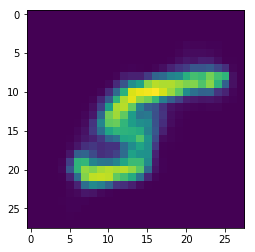

**********result at Epoch 25 Step 300*************


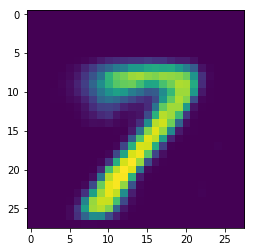

**********result at Epoch 25 Step 400*************


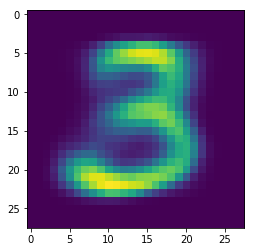

***epoch 26, step 0: total loss: 138.83316040039062, E_loss: 132.47042846679688, KL_loss:6.36273717880249
**********result at Epoch 26 Step 0*************


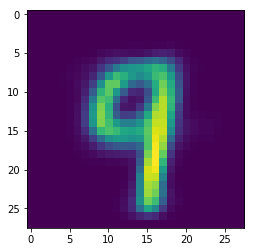

***epoch 26, step 50: total loss: 142.0266571044922, E_loss: 135.69381713867188, KL_loss:6.3328399658203125
***epoch 26, step 100: total loss: 140.1907196044922, E_loss: 133.81878662109375, KL_loss:6.37192964553833
**********result at Epoch 26 Step 100*************


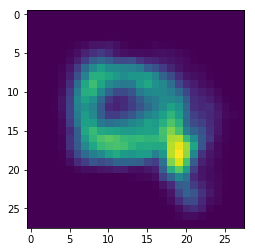

***epoch 26, step 150: total loss: 130.6383819580078, E_loss: 124.31926727294922, KL_loss:6.319116115570068
***epoch 26, step 200: total loss: 139.56549072265625, E_loss: 133.1423797607422, KL_loss:6.4231061935424805
**********result at Epoch 26 Step 200*************


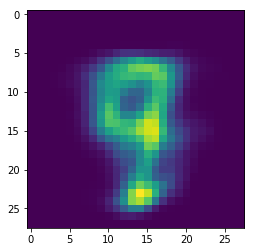

***epoch 26, step 250: total loss: 144.94113159179688, E_loss: 138.82904052734375, KL_loss:6.112091541290283
***epoch 26, step 300: total loss: 141.26870727539062, E_loss: 134.82594299316406, KL_loss:6.4427714347839355
**********result at Epoch 26 Step 300*************


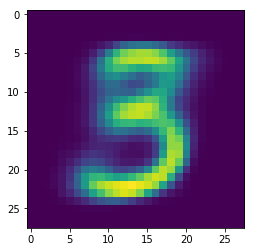

***epoch 26, step 350: total loss: 146.86830139160156, E_loss: 140.6604461669922, KL_loss:6.207849979400635
***epoch 26, step 400: total loss: 141.66461181640625, E_loss: 135.50473022460938, KL_loss:6.159876823425293
**********result at Epoch 26 Step 400*************


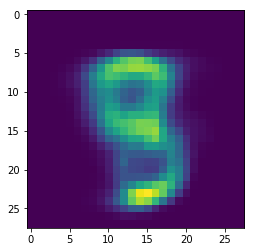

**********result at Epoch 27 Step 0*************


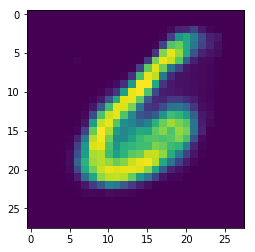

**********result at Epoch 27 Step 100*************


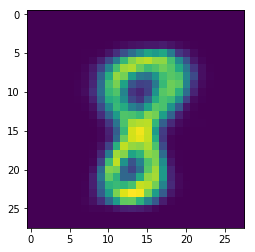

**********result at Epoch 27 Step 200*************


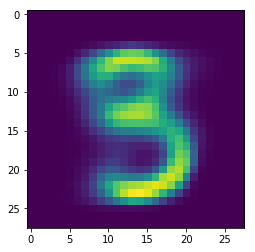

**********result at Epoch 27 Step 300*************


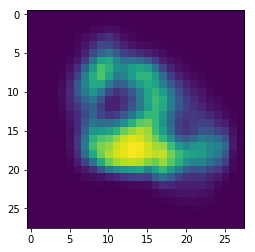

**********result at Epoch 27 Step 400*************


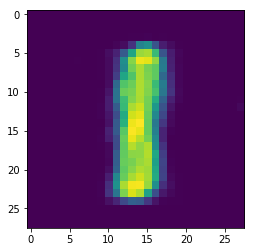

***epoch 28, step 0: total loss: 138.3168487548828, E_loss: 131.98013305664062, KL_loss:6.336712837219238
**********result at Epoch 28 Step 0*************


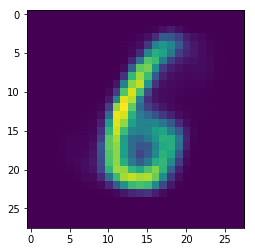

***epoch 28, step 50: total loss: 141.02330017089844, E_loss: 134.49575805664062, KL_loss:6.527539253234863
***epoch 28, step 100: total loss: 140.1151580810547, E_loss: 133.7518768310547, KL_loss:6.363283157348633
**********result at Epoch 28 Step 100*************


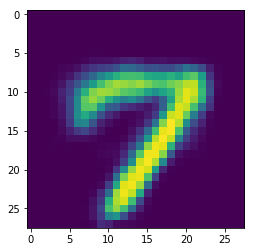

***epoch 28, step 150: total loss: 131.27684020996094, E_loss: 124.98609161376953, KL_loss:6.290753364562988
***epoch 28, step 200: total loss: 138.56396484375, E_loss: 131.97512817382812, KL_loss:6.588836669921875
**********result at Epoch 28 Step 200*************


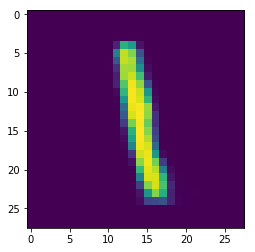

***epoch 28, step 250: total loss: 144.80902099609375, E_loss: 138.5615997314453, KL_loss:6.247417449951172
***epoch 28, step 300: total loss: 141.5272674560547, E_loss: 134.96771240234375, KL_loss:6.559548377990723
**********result at Epoch 28 Step 300*************


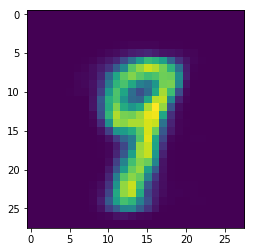

***epoch 28, step 350: total loss: 146.78176879882812, E_loss: 140.44369506835938, KL_loss:6.338077545166016
***epoch 28, step 400: total loss: 141.33409118652344, E_loss: 135.0679168701172, KL_loss:6.266175746917725
**********result at Epoch 28 Step 400*************


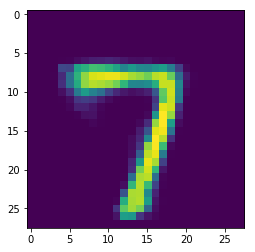

**********result at Epoch 29 Step 0*************


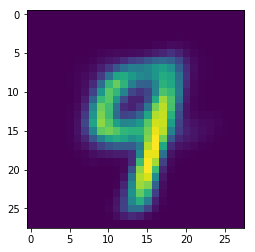

**********result at Epoch 29 Step 100*************


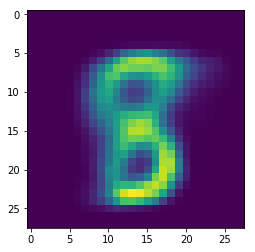

**********result at Epoch 29 Step 200*************


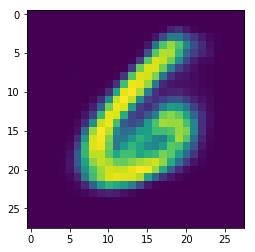

**********result at Epoch 29 Step 300*************


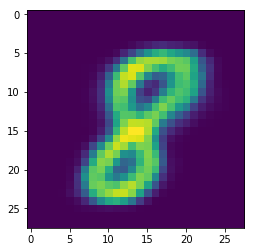

**********result at Epoch 29 Step 400*************


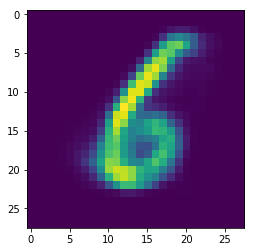

***epoch 30, step 0: total loss: 137.5792694091797, E_loss: 131.29396057128906, KL_loss:6.285305976867676
**********result at Epoch 30 Step 0*************


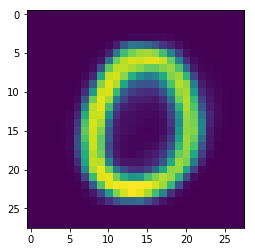

***epoch 30, step 50: total loss: 141.21766662597656, E_loss: 134.74534606933594, KL_loss:6.472327709197998
***epoch 30, step 100: total loss: 139.4749298095703, E_loss: 133.05691528320312, KL_loss:6.418017387390137
**********result at Epoch 30 Step 100*************


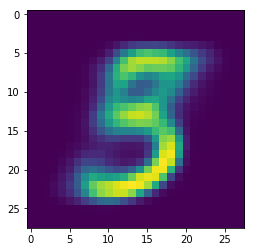

***epoch 30, step 150: total loss: 130.3262939453125, E_loss: 123.9532470703125, KL_loss:6.373046398162842
***epoch 30, step 200: total loss: 139.1759490966797, E_loss: 132.59849548339844, KL_loss:6.577456951141357
**********result at Epoch 30 Step 200*************


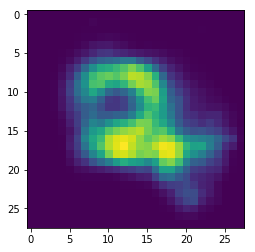

***epoch 30, step 250: total loss: 145.33485412597656, E_loss: 139.0830078125, KL_loss:6.251851558685303
***epoch 30, step 300: total loss: 141.26243591308594, E_loss: 134.5040283203125, KL_loss:6.75840950012207
**********result at Epoch 30 Step 300*************


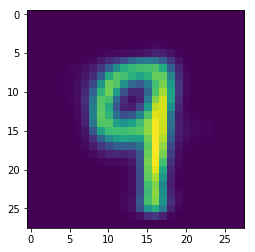

***epoch 30, step 350: total loss: 146.01626586914062, E_loss: 139.80648803710938, KL_loss:6.209776878356934
***epoch 30, step 400: total loss: 141.0596160888672, E_loss: 134.80740356445312, KL_loss:6.252214431762695
**********result at Epoch 30 Step 400*************


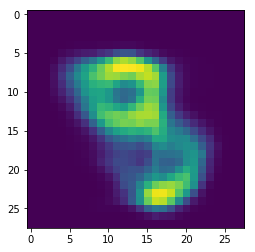

**********result at Epoch 31 Step 0*************


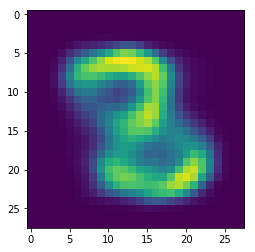

**********result at Epoch 31 Step 100*************


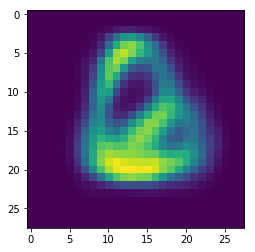

**********result at Epoch 31 Step 200*************


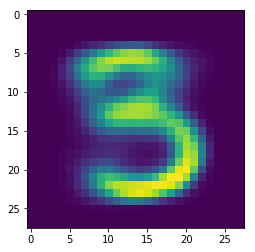

**********result at Epoch 31 Step 300*************


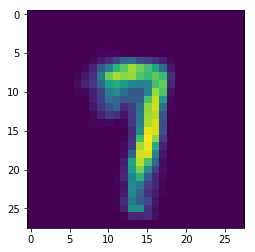

**********result at Epoch 31 Step 400*************


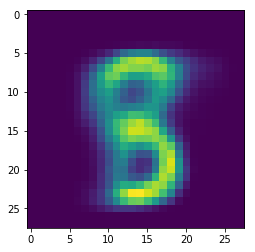

***epoch 32, step 0: total loss: 137.25082397460938, E_loss: 130.8295440673828, KL_loss:6.421287536621094
**********result at Epoch 32 Step 0*************


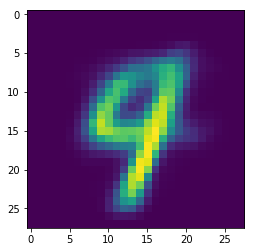

***epoch 32, step 50: total loss: 140.6322021484375, E_loss: 134.13551330566406, KL_loss:6.496690273284912
***epoch 32, step 100: total loss: 139.54608154296875, E_loss: 133.1625213623047, KL_loss:6.3835649490356445
**********result at Epoch 32 Step 100*************


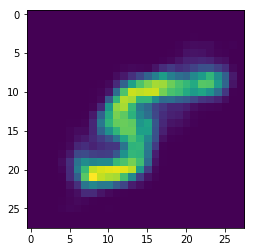

***epoch 32, step 150: total loss: 130.36050415039062, E_loss: 123.94017028808594, KL_loss:6.420331954956055
***epoch 32, step 200: total loss: 138.4785614013672, E_loss: 131.9896240234375, KL_loss:6.488937854766846
**********result at Epoch 32 Step 200*************


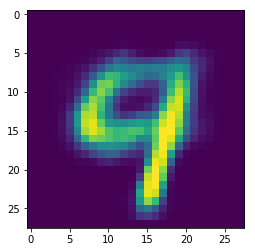

***epoch 32, step 250: total loss: 144.10134887695312, E_loss: 137.7748565673828, KL_loss:6.326497554779053
***epoch 32, step 300: total loss: 141.00479125976562, E_loss: 134.33599853515625, KL_loss:6.668787956237793
**********result at Epoch 32 Step 300*************


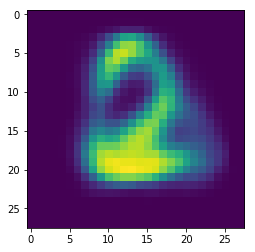

***epoch 32, step 350: total loss: 146.36917114257812, E_loss: 140.00845336914062, KL_loss:6.360713005065918
***epoch 32, step 400: total loss: 140.95169067382812, E_loss: 134.6861572265625, KL_loss:6.265538215637207
**********result at Epoch 32 Step 400*************


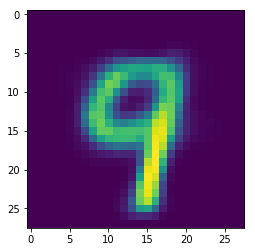

**********result at Epoch 33 Step 0*************


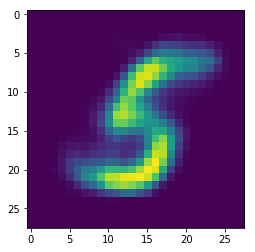

**********result at Epoch 33 Step 100*************


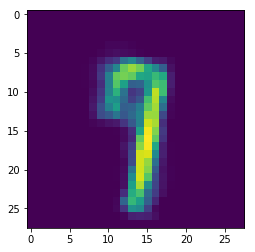

**********result at Epoch 33 Step 200*************


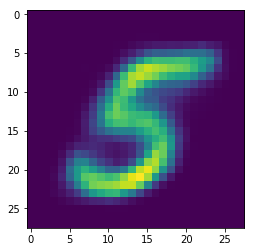

**********result at Epoch 33 Step 300*************


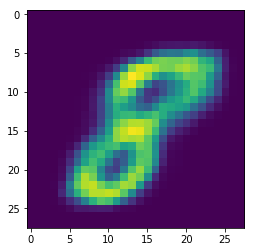

**********result at Epoch 33 Step 400*************


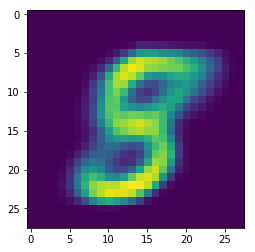

***epoch 34, step 0: total loss: 136.5020751953125, E_loss: 130.13125610351562, KL_loss:6.370816230773926
**********result at Epoch 34 Step 0*************


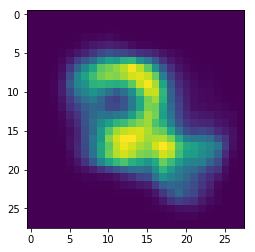

***epoch 34, step 50: total loss: 140.49581909179688, E_loss: 134.01467895507812, KL_loss:6.48114013671875
***epoch 34, step 100: total loss: 138.92074584960938, E_loss: 132.54397583007812, KL_loss:6.376776218414307
**********result at Epoch 34 Step 100*************


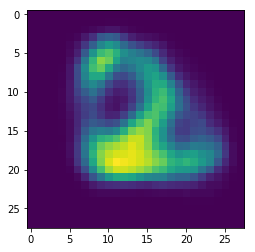

***epoch 34, step 150: total loss: 129.26840209960938, E_loss: 122.82270812988281, KL_loss:6.445690155029297
***epoch 34, step 200: total loss: 138.37026977539062, E_loss: 131.70504760742188, KL_loss:6.66522216796875
**********result at Epoch 34 Step 200*************


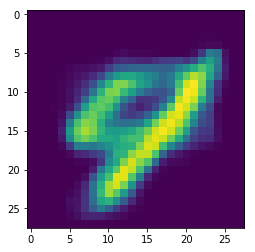

***epoch 34, step 250: total loss: 144.41209411621094, E_loss: 138.05601501464844, KL_loss:6.356072425842285
***epoch 34, step 300: total loss: 141.0947723388672, E_loss: 134.48487854003906, KL_loss:6.609889030456543
**********result at Epoch 34 Step 300*************


***epoch 34, step 350: total loss: 145.48680114746094, E_loss: 139.1820068359375, KL_loss:6.304787635803223
***epoch 34, step 400: total loss: 140.79417419433594, E_loss: 134.46612548828125, KL_loss:6.328052520751953
**********result at Epoch 34 Step 400*************


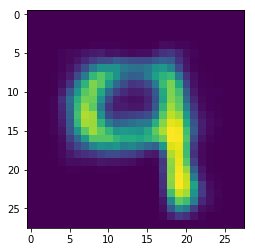

**********result at Epoch 35 Step 0*************


**********result at Epoch 35 Step 100*************


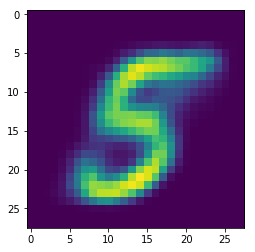

**********result at Epoch 35 Step 200*************


**********result at Epoch 35 Step 300*************


**********result at Epoch 35 Step 400*************


***epoch 36, step 0: total loss: 136.5299072265625, E_loss: 130.10227966308594, KL_loss:6.427635192871094
**********result at Epoch 36 Step 0*************


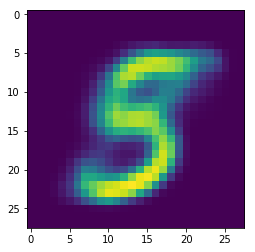

***epoch 36, step 50: total loss: 140.02391052246094, E_loss: 133.4867401123047, KL_loss:6.537171840667725
***epoch 36, step 100: total loss: 138.53834533691406, E_loss: 132.08071899414062, KL_loss:6.457624435424805
**********result at Epoch 36 Step 100*************


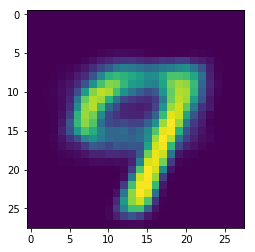

***epoch 36, step 150: total loss: 129.2642059326172, E_loss: 122.82669067382812, KL_loss:6.437518119812012
***epoch 36, step 200: total loss: 137.49978637695312, E_loss: 130.83633422851562, KL_loss:6.663445472717285
**********result at Epoch 36 Step 200*************


***epoch 36, step 250: total loss: 143.89691162109375, E_loss: 137.526611328125, KL_loss:6.370305061340332
***epoch 36, step 300: total loss: 141.05697631835938, E_loss: 134.30096435546875, KL_loss:6.756017684936523
**********result at Epoch 36 Step 300*************


***epoch 36, step 350: total loss: 144.61643981933594, E_loss: 138.24319458007812, KL_loss:6.3732428550720215
***epoch 36, step 400: total loss: 140.39109802246094, E_loss: 134.011474609375, KL_loss:6.379622459411621
**********result at Epoch 36 Step 400*************


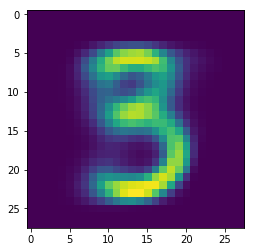

**********result at Epoch 37 Step 0*************


**********result at Epoch 37 Step 100*************


**********result at Epoch 37 Step 200*************


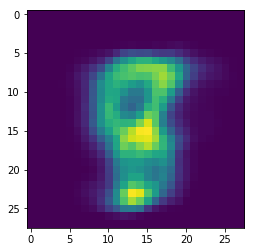

**********result at Epoch 37 Step 300*************


**********result at Epoch 37 Step 400*************


***epoch 38, step 0: total loss: 136.5516357421875, E_loss: 130.02964782714844, KL_loss:6.521992206573486
**********result at Epoch 38 Step 0*************


***epoch 38, step 50: total loss: 140.15455627441406, E_loss: 133.58328247070312, KL_loss:6.571277141571045
***epoch 38, step 100: total loss: 138.57826232910156, E_loss: 132.13201904296875, KL_loss:6.446248531341553
**********result at Epoch 38 Step 100*************


***epoch 38, step 150: total loss: 129.8041229248047, E_loss: 123.32734680175781, KL_loss:6.476771354675293
***epoch 38, step 200: total loss: 137.2760009765625, E_loss: 130.63491821289062, KL_loss:6.641083717346191
**********result at Epoch 38 Step 200*************


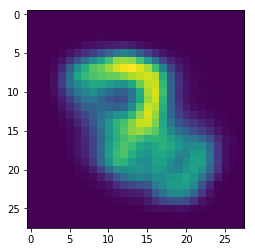

***epoch 38, step 250: total loss: 143.49102783203125, E_loss: 137.11314392089844, KL_loss:6.377888202667236
***epoch 38, step 300: total loss: 140.84017944335938, E_loss: 134.20779418945312, KL_loss:6.632382869720459
**********result at Epoch 38 Step 300*************


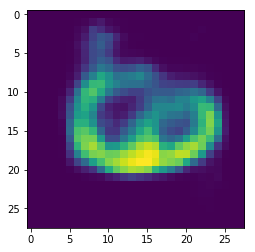

***epoch 38, step 350: total loss: 144.70945739746094, E_loss: 138.35520935058594, KL_loss:6.354247093200684
***epoch 38, step 400: total loss: 140.0769805908203, E_loss: 133.74462890625, KL_loss:6.3323469161987305
**********result at Epoch 38 Step 400*************


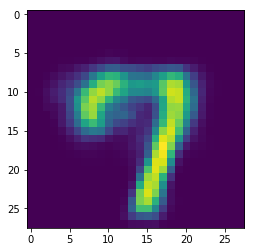

**********result at Epoch 39 Step 0*************


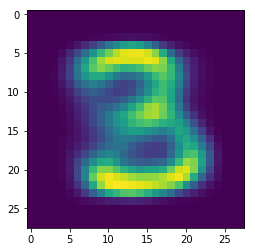

**********result at Epoch 39 Step 100*************


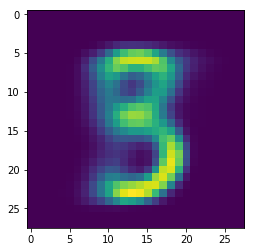

**********result at Epoch 39 Step 200*************


**********result at Epoch 39 Step 300*************


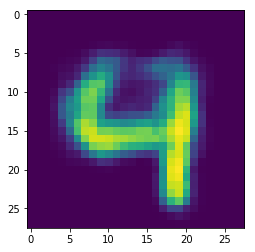

**********result at Epoch 39 Step 400*************


***epoch 40, step 0: total loss: 136.1768035888672, E_loss: 129.77117919921875, KL_loss:6.405625343322754
**********result at Epoch 40 Step 0*************


***epoch 40, step 50: total loss: 139.16070556640625, E_loss: 132.6083984375, KL_loss:6.552311420440674
***epoch 40, step 100: total loss: 138.63717651367188, E_loss: 132.1337127685547, KL_loss:6.5034589767456055
**********result at Epoch 40 Step 100*************


***epoch 40, step 150: total loss: 129.02565002441406, E_loss: 122.45756530761719, KL_loss:6.568082809448242
***epoch 40, step 200: total loss: 136.7412872314453, E_loss: 129.90231323242188, KL_loss:6.838973045349121
**********result at Epoch 40 Step 200*************


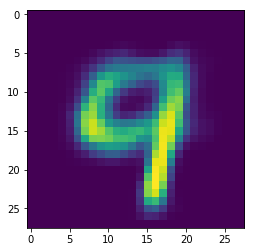

***epoch 40, step 250: total loss: 143.52349853515625, E_loss: 137.14613342285156, KL_loss:6.377364158630371
***epoch 40, step 300: total loss: 140.03451538085938, E_loss: 133.3632354736328, KL_loss:6.6712799072265625
**********result at Epoch 40 Step 300*************


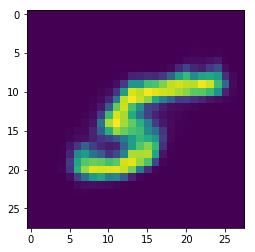

***epoch 40, step 350: total loss: 144.34976196289062, E_loss: 137.91932678222656, KL_loss:6.430428981781006
***epoch 40, step 400: total loss: 140.0198211669922, E_loss: 133.7105712890625, KL_loss:6.309244155883789
**********result at Epoch 40 Step 400*************


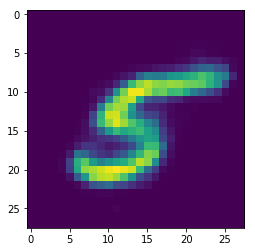

**********result at Epoch 41 Step 0*************


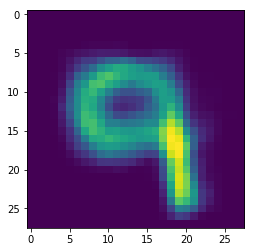

**********result at Epoch 41 Step 100*************


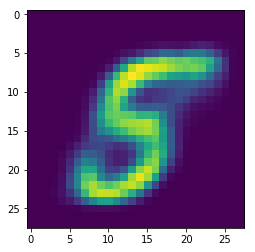

**********result at Epoch 41 Step 200*************


**********result at Epoch 41 Step 300*************


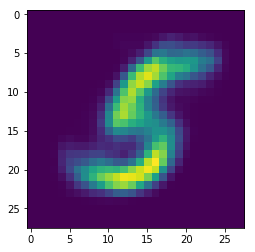

**********result at Epoch 41 Step 400*************


***epoch 42, step 0: total loss: 135.9582061767578, E_loss: 129.50526428222656, KL_loss:6.452939510345459
**********result at Epoch 42 Step 0*************


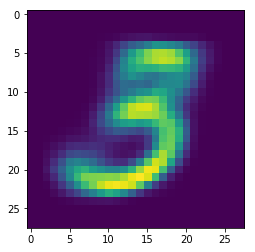

***epoch 42, step 50: total loss: 138.82412719726562, E_loss: 132.24398803710938, KL_loss:6.580132007598877
***epoch 42, step 100: total loss: 138.13626098632812, E_loss: 131.63758850097656, KL_loss:6.498674392700195
**********result at Epoch 42 Step 100*************


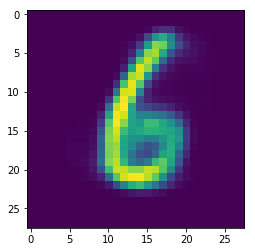

***epoch 42, step 150: total loss: 128.60964965820312, E_loss: 122.04931640625, KL_loss:6.560338020324707
***epoch 42, step 200: total loss: 136.5674591064453, E_loss: 129.919677734375, KL_loss:6.647778511047363
**********result at Epoch 42 Step 200*************


***epoch 42, step 250: total loss: 143.41612243652344, E_loss: 136.91741943359375, KL_loss:6.4987053871154785
***epoch 42, step 300: total loss: 140.4199981689453, E_loss: 133.6229248046875, KL_loss:6.797075271606445
**********result at Epoch 42 Step 300*************


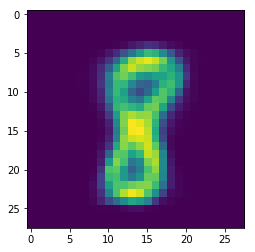

***epoch 42, step 350: total loss: 144.96412658691406, E_loss: 138.4140167236328, KL_loss:6.550114631652832
***epoch 42, step 400: total loss: 139.15869140625, E_loss: 132.67637634277344, KL_loss:6.482321262359619
**********result at Epoch 42 Step 400*************


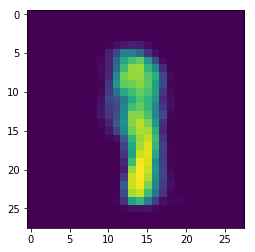

**********result at Epoch 43 Step 0*************


**********result at Epoch 43 Step 100*************


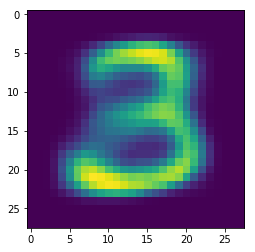

**********result at Epoch 43 Step 200*************


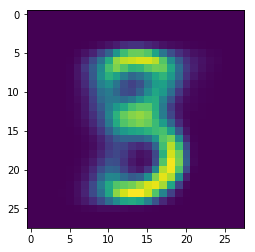

**********result at Epoch 43 Step 300*************


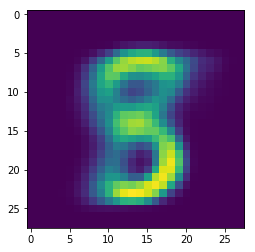

**********result at Epoch 43 Step 400*************


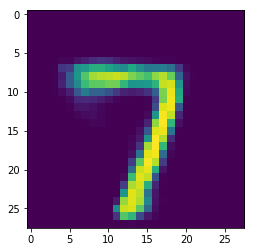

***epoch 44, step 0: total loss: 135.23086547851562, E_loss: 128.7774658203125, KL_loss:6.453397750854492
**********result at Epoch 44 Step 0*************


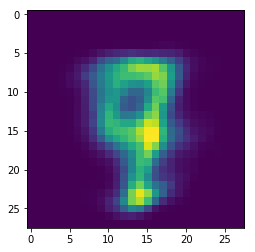

***epoch 44, step 50: total loss: 138.1865234375, E_loss: 131.64015197753906, KL_loss:6.54637336730957
***epoch 44, step 100: total loss: 137.86721801757812, E_loss: 131.42259216308594, KL_loss:6.444623947143555
**********result at Epoch 44 Step 100*************


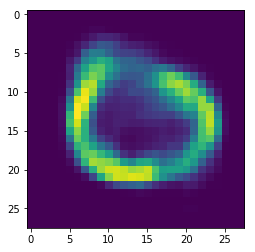

***epoch 44, step 150: total loss: 128.41165161132812, E_loss: 121.96630859375, KL_loss:6.445338726043701
***epoch 44, step 200: total loss: 136.27294921875, E_loss: 129.53024291992188, KL_loss:6.74271297454834
**********result at Epoch 44 Step 200*************


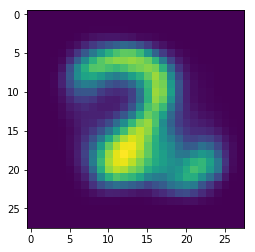

***epoch 44, step 250: total loss: 143.03399658203125, E_loss: 136.55352783203125, KL_loss:6.480470180511475
***epoch 44, step 300: total loss: 140.92457580566406, E_loss: 134.17031860351562, KL_loss:6.754250526428223
**********result at Epoch 44 Step 300*************


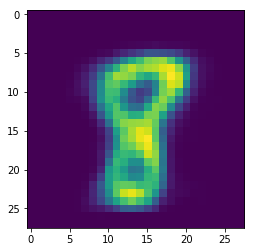

***epoch 44, step 350: total loss: 144.0246124267578, E_loss: 137.52944946289062, KL_loss:6.495169162750244
***epoch 44, step 400: total loss: 139.67617797851562, E_loss: 133.1516571044922, KL_loss:6.52451753616333
**********result at Epoch 44 Step 400*************


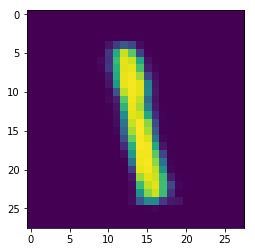

**********result at Epoch 45 Step 0*************


**********result at Epoch 45 Step 100*************


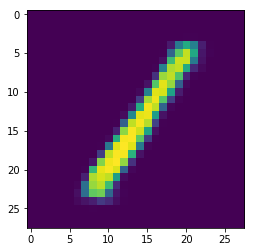

**********result at Epoch 45 Step 200*************


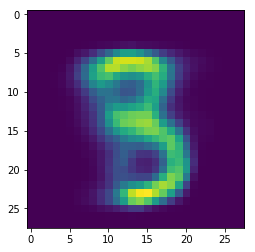

**********result at Epoch 45 Step 300*************


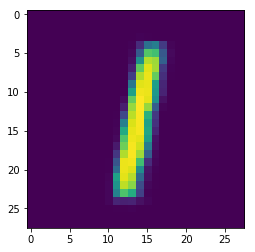

**********result at Epoch 45 Step 400*************


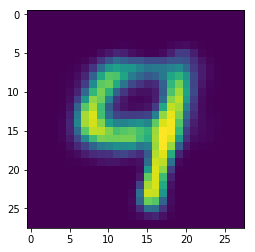

***epoch 46, step 0: total loss: 135.1921844482422, E_loss: 128.79452514648438, KL_loss:6.397656440734863
**********result at Epoch 46 Step 0*************


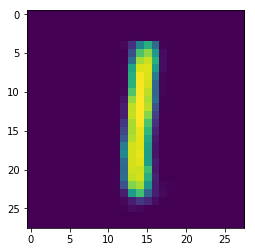

***epoch 46, step 50: total loss: 139.82923889160156, E_loss: 133.3074951171875, KL_loss:6.521744251251221
***epoch 46, step 100: total loss: 137.48304748535156, E_loss: 130.8616485595703, KL_loss:6.621391773223877
**********result at Epoch 46 Step 100*************


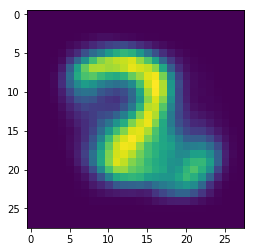

***epoch 46, step 150: total loss: 128.6792449951172, E_loss: 122.15278625488281, KL_loss:6.526456356048584
***epoch 46, step 200: total loss: 135.8116912841797, E_loss: 129.0113067626953, KL_loss:6.800380706787109
**********result at Epoch 46 Step 200*************


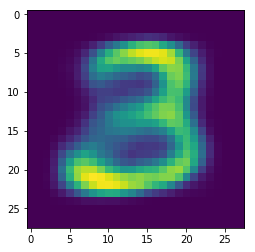

***epoch 46, step 250: total loss: 143.76150512695312, E_loss: 137.27499389648438, KL_loss:6.486511707305908
***epoch 46, step 300: total loss: 140.38616943359375, E_loss: 133.65733337402344, KL_loss:6.7288384437561035
**********result at Epoch 46 Step 300*************


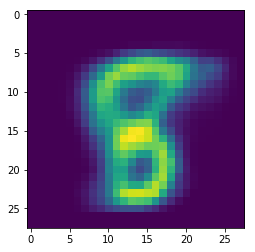

***epoch 46, step 350: total loss: 143.8485870361328, E_loss: 137.33221435546875, KL_loss:6.516366958618164
***epoch 46, step 400: total loss: 139.48281860351562, E_loss: 133.01046752929688, KL_loss:6.472349166870117
**********result at Epoch 46 Step 400*************


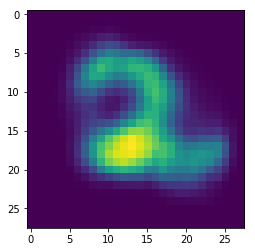

**********result at Epoch 47 Step 0*************


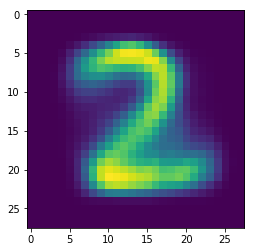

**********result at Epoch 47 Step 100*************


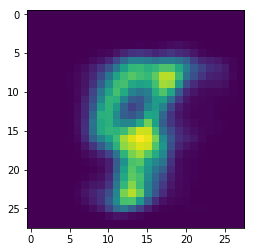

**********result at Epoch 47 Step 200*************


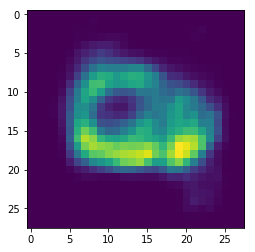

**********result at Epoch 47 Step 300*************


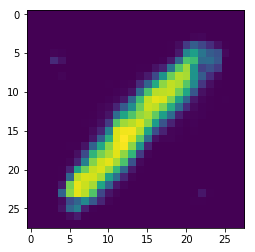

**********result at Epoch 47 Step 400*************


***epoch 48, step 0: total loss: 135.18850708007812, E_loss: 128.6861572265625, KL_loss:6.502355098724365
**********result at Epoch 48 Step 0*************


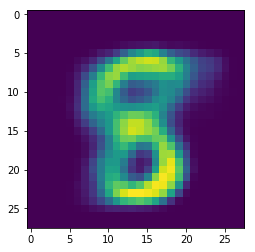

***epoch 48, step 50: total loss: 138.1208038330078, E_loss: 131.41490173339844, KL_loss:6.7059006690979
***epoch 48, step 100: total loss: 137.47726440429688, E_loss: 130.96316528320312, KL_loss:6.514101028442383
**********result at Epoch 48 Step 100*************


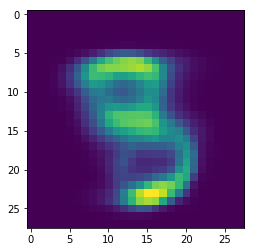

***epoch 48, step 150: total loss: 127.9421615600586, E_loss: 121.33714294433594, KL_loss:6.605019569396973
***epoch 48, step 200: total loss: 136.28817749023438, E_loss: 129.46087646484375, KL_loss:6.827297687530518
**********result at Epoch 48 Step 200*************


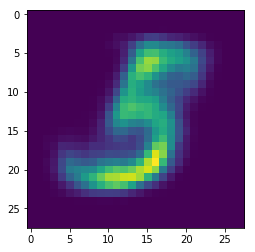

***epoch 48, step 250: total loss: 142.784423828125, E_loss: 136.2945556640625, KL_loss:6.489867687225342
***epoch 48, step 300: total loss: 140.03489685058594, E_loss: 133.129638671875, KL_loss:6.905259132385254
**********result at Epoch 48 Step 300*************


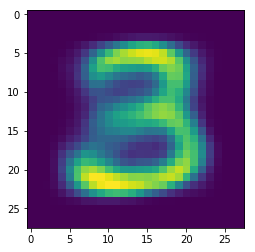

***epoch 48, step 350: total loss: 144.5039825439453, E_loss: 137.9459228515625, KL_loss:6.558054447174072
***epoch 48, step 400: total loss: 138.91127014160156, E_loss: 132.40048217773438, KL_loss:6.510782241821289
**********result at Epoch 48 Step 400*************


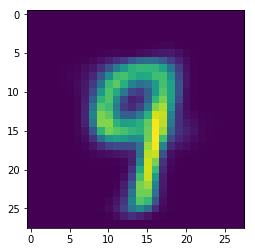

**********result at Epoch 49 Step 0*************


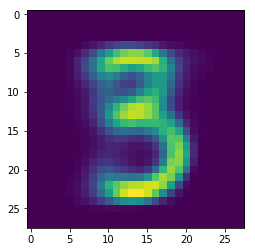

**********result at Epoch 49 Step 100*************


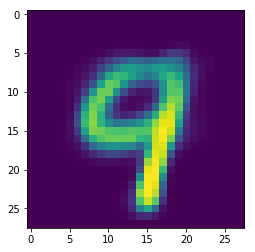

**********result at Epoch 49 Step 200*************


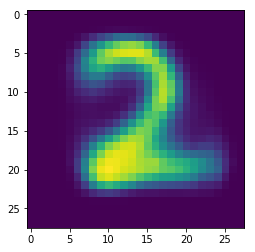

**********result at Epoch 49 Step 300*************


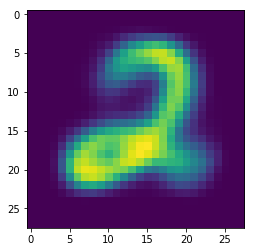

**********result at Epoch 49 Step 400*************


***epoch 50, step 0: total loss: 135.1938018798828, E_loss: 128.59933471679688, KL_loss:6.5944671630859375
**********result at Epoch 50 Step 0*************


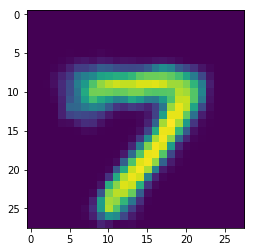

***epoch 50, step 50: total loss: 137.99205017089844, E_loss: 131.45187377929688, KL_loss:6.540179252624512
***epoch 50, step 100: total loss: 137.12855529785156, E_loss: 130.59217834472656, KL_loss:6.536374568939209
**********result at Epoch 50 Step 100*************


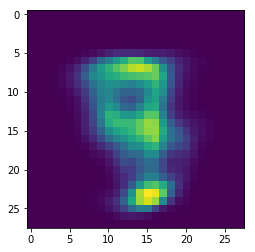

***epoch 50, step 150: total loss: 127.3021240234375, E_loss: 120.72393798828125, KL_loss:6.578184604644775
***epoch 50, step 200: total loss: 135.49021911621094, E_loss: 128.69839477539062, KL_loss:6.791826248168945
**********result at Epoch 50 Step 200*************


***epoch 50, step 250: total loss: 143.08975219726562, E_loss: 136.5417938232422, KL_loss:6.5479607582092285
***epoch 50, step 300: total loss: 139.56617736816406, E_loss: 132.76211547851562, KL_loss:6.804065704345703
**********result at Epoch 50 Step 300*************


***epoch 50, step 350: total loss: 143.88340759277344, E_loss: 137.3643341064453, KL_loss:6.519071578979492
***epoch 50, step 400: total loss: 139.40283203125, E_loss: 132.88162231445312, KL_loss:6.521204948425293
**********result at Epoch 50 Step 400*************


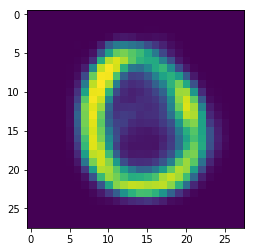

**********result at Epoch 51 Step 0*************


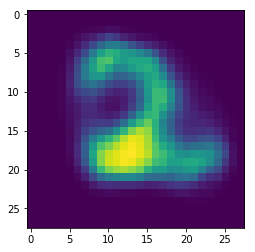

**********result at Epoch 51 Step 100*************


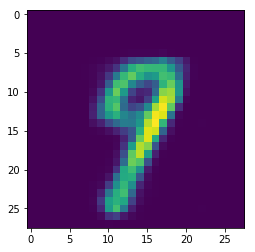

**********result at Epoch 51 Step 200*************


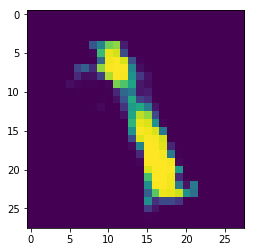

**********result at Epoch 51 Step 300*************


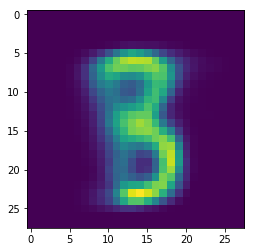

**********result at Epoch 51 Step 400*************


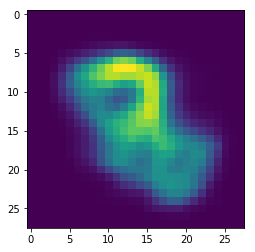

***epoch 52, step 0: total loss: 135.525634765625, E_loss: 128.986572265625, KL_loss:6.539061546325684
**********result at Epoch 52 Step 0*************


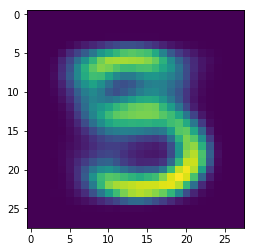

***epoch 52, step 50: total loss: 137.74928283691406, E_loss: 131.08775329589844, KL_loss:6.661523818969727
***epoch 52, step 100: total loss: 136.76077270507812, E_loss: 130.104248046875, KL_loss:6.656527519226074
**********result at Epoch 52 Step 100*************


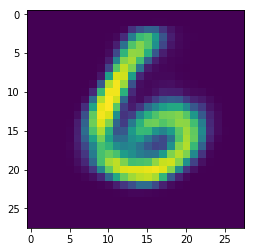

***epoch 52, step 150: total loss: 128.04588317871094, E_loss: 121.44937133789062, KL_loss:6.5965118408203125
***epoch 52, step 200: total loss: 136.08294677734375, E_loss: 129.275634765625, KL_loss:6.807317733764648
**********result at Epoch 52 Step 200*************


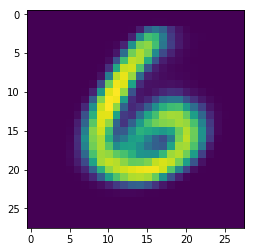

***epoch 52, step 250: total loss: 143.02578735351562, E_loss: 136.5778350830078, KL_loss:6.44795036315918
***epoch 52, step 300: total loss: 140.22775268554688, E_loss: 133.4849853515625, KL_loss:6.742774486541748
**********result at Epoch 52 Step 300*************


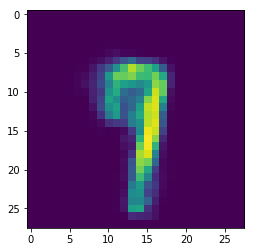

***epoch 52, step 350: total loss: 143.42103576660156, E_loss: 136.90716552734375, KL_loss:6.513867378234863
***epoch 52, step 400: total loss: 138.8162841796875, E_loss: 132.34153747558594, KL_loss:6.4747514724731445
**********result at Epoch 52 Step 400*************


**********result at Epoch 53 Step 0*************


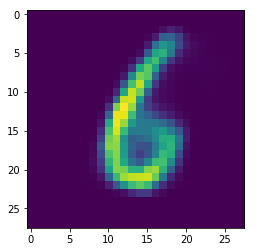

**********result at Epoch 53 Step 100*************


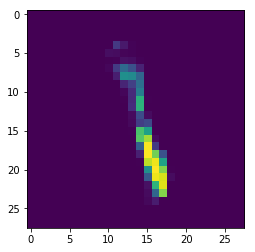

**********result at Epoch 53 Step 200*************


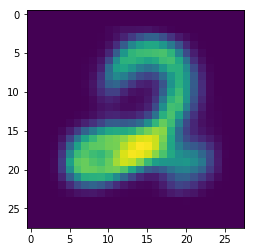

**********result at Epoch 53 Step 300*************


**********result at Epoch 53 Step 400*************


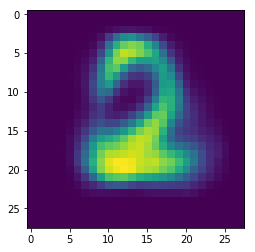

***epoch 54, step 0: total loss: 135.08702087402344, E_loss: 128.55978393554688, KL_loss:6.527233123779297
**********result at Epoch 54 Step 0*************


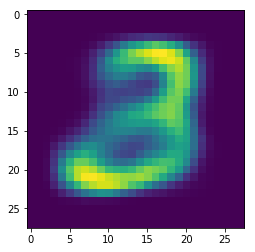

***epoch 54, step 50: total loss: 137.7940216064453, E_loss: 131.1321563720703, KL_loss:6.661864757537842
***epoch 54, step 100: total loss: 136.62356567382812, E_loss: 130.0380859375, KL_loss:6.585472106933594
**********result at Epoch 54 Step 100*************


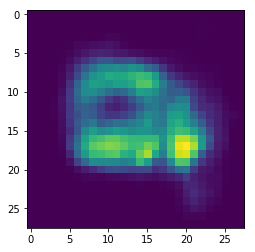

***epoch 54, step 150: total loss: 127.17845916748047, E_loss: 120.52955627441406, KL_loss:6.648904323577881
***epoch 54, step 200: total loss: 135.12124633789062, E_loss: 128.38473510742188, KL_loss:6.73651123046875
**********result at Epoch 54 Step 200*************


***epoch 54, step 250: total loss: 142.77984619140625, E_loss: 136.29066467285156, KL_loss:6.489177703857422
***epoch 54, step 300: total loss: 139.7548828125, E_loss: 132.96133422851562, KL_loss:6.793550968170166
**********result at Epoch 54 Step 300*************


***epoch 54, step 350: total loss: 143.28028869628906, E_loss: 136.57421875, KL_loss:6.706074237823486
***epoch 54, step 400: total loss: 139.0809326171875, E_loss: 132.503662109375, KL_loss:6.577263832092285
**********result at Epoch 54 Step 400*************


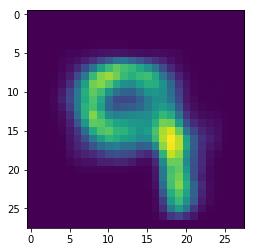

**********result at Epoch 55 Step 0*************


**********result at Epoch 55 Step 100*************


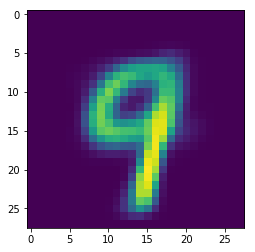

**********result at Epoch 55 Step 200*************


**********result at Epoch 55 Step 300*************


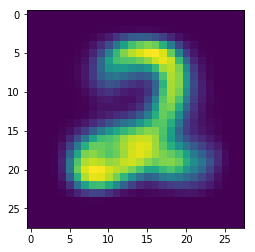

**********result at Epoch 55 Step 400*************


***epoch 56, step 0: total loss: 134.68728637695312, E_loss: 128.18539428710938, KL_loss:6.501890182495117
**********result at Epoch 56 Step 0*************


***epoch 56, step 50: total loss: 138.06243896484375, E_loss: 131.34197998046875, KL_loss:6.720460414886475
***epoch 56, step 100: total loss: 137.23373413085938, E_loss: 130.66546630859375, KL_loss:6.568273544311523
**********result at Epoch 56 Step 100*************


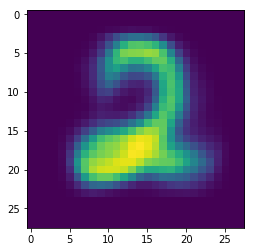

***epoch 56, step 150: total loss: 127.78607177734375, E_loss: 121.09902954101562, KL_loss:6.68704080581665
***epoch 56, step 200: total loss: 135.60447692871094, E_loss: 128.8426513671875, KL_loss:6.7618279457092285
**********result at Epoch 56 Step 200*************


***epoch 56, step 250: total loss: 142.66082763671875, E_loss: 136.18026733398438, KL_loss:6.480564117431641
***epoch 56, step 300: total loss: 139.9063262939453, E_loss: 133.1118621826172, KL_loss:6.7944655418396
**********result at Epoch 56 Step 300*************


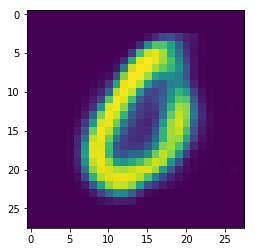

***epoch 56, step 350: total loss: 143.85374450683594, E_loss: 137.25372314453125, KL_loss:6.6000165939331055
***epoch 56, step 400: total loss: 138.89288330078125, E_loss: 132.3269805908203, KL_loss:6.565907001495361
**********result at Epoch 56 Step 400*************


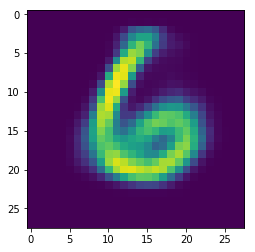

**********result at Epoch 57 Step 0*************


**********result at Epoch 57 Step 100*************


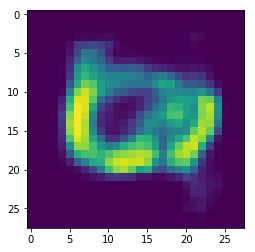

**********result at Epoch 57 Step 200*************


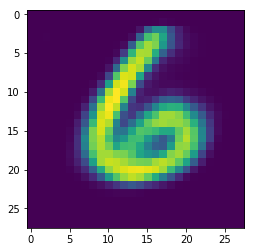

**********result at Epoch 57 Step 300*************


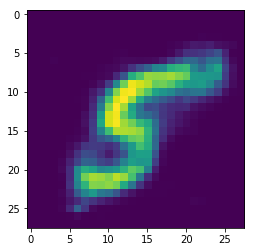

**********result at Epoch 57 Step 400*************


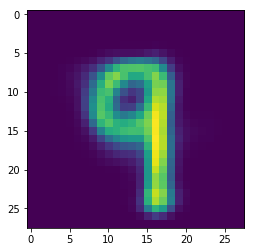

***epoch 58, step 0: total loss: 134.51937866210938, E_loss: 127.95930480957031, KL_loss:6.560066223144531
**********result at Epoch 58 Step 0*************


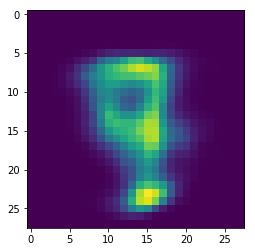

***epoch 58, step 50: total loss: 137.69081115722656, E_loss: 130.91543579101562, KL_loss:6.7753825187683105
***epoch 58, step 100: total loss: 137.33706665039062, E_loss: 130.7177734375, KL_loss:6.619286060333252
**********result at Epoch 58 Step 100*************


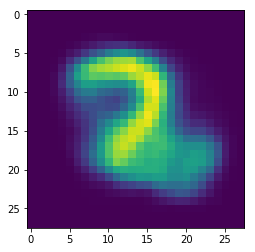

***epoch 58, step 150: total loss: 127.18275451660156, E_loss: 120.5008544921875, KL_loss:6.681899547576904
***epoch 58, step 200: total loss: 135.8834991455078, E_loss: 129.1025390625, KL_loss:6.78095817565918
**********result at Epoch 58 Step 200*************


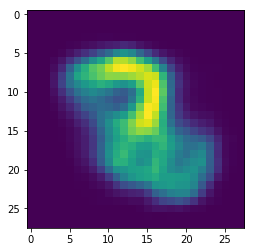

***epoch 58, step 250: total loss: 142.0577850341797, E_loss: 135.49307250976562, KL_loss:6.564716339111328
***epoch 58, step 300: total loss: 140.3508758544922, E_loss: 133.494140625, KL_loss:6.85673713684082
**********result at Epoch 58 Step 300*************


***epoch 58, step 350: total loss: 143.7945556640625, E_loss: 137.19712829589844, KL_loss:6.5974321365356445
***epoch 58, step 400: total loss: 138.87904357910156, E_loss: 132.3493194580078, KL_loss:6.529726982116699
**********result at Epoch 58 Step 400*************


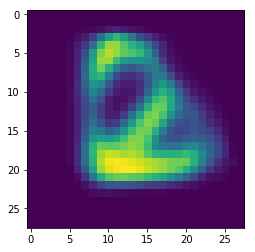

**********result at Epoch 59 Step 0*************


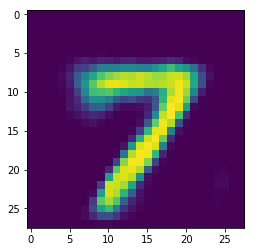

**********result at Epoch 59 Step 100*************


**********result at Epoch 59 Step 200*************


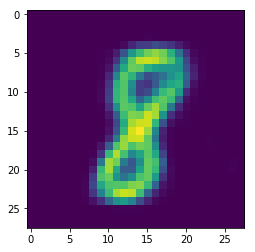

**********result at Epoch 59 Step 300*************


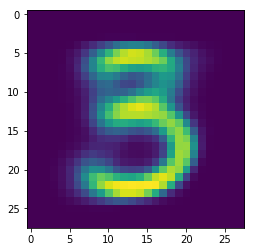

**********result at Epoch 59 Step 400*************


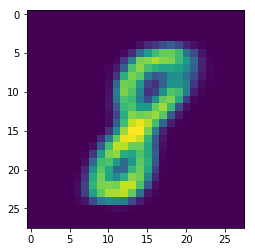

***epoch 60, step 0: total loss: 134.2100067138672, E_loss: 127.58213806152344, KL_loss:6.627866744995117
**********result at Epoch 60 Step 0*************


***epoch 60, step 50: total loss: 137.36851501464844, E_loss: 130.715087890625, KL_loss:6.653424263000488
***epoch 60, step 100: total loss: 137.29568481445312, E_loss: 130.63992309570312, KL_loss:6.655758857727051
**********result at Epoch 60 Step 100*************


***epoch 60, step 150: total loss: 126.85919952392578, E_loss: 120.13099670410156, KL_loss:6.728201866149902
***epoch 60, step 200: total loss: 135.42562866210938, E_loss: 128.5293731689453, KL_loss:6.896251678466797
**********result at Epoch 60 Step 200*************


***epoch 60, step 250: total loss: 142.1676025390625, E_loss: 135.68228149414062, KL_loss:6.485320091247559
***epoch 60, step 300: total loss: 139.76962280273438, E_loss: 132.98251342773438, KL_loss:6.787105560302734
**********result at Epoch 60 Step 300*************


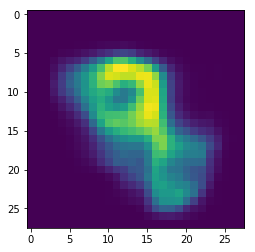

***epoch 60, step 350: total loss: 142.588134765625, E_loss: 135.9322052001953, KL_loss:6.655932903289795
***epoch 60, step 400: total loss: 138.6354217529297, E_loss: 132.1051483154297, KL_loss:6.530280113220215
**********result at Epoch 60 Step 400*************


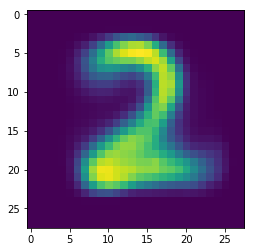

**********result at Epoch 61 Step 0*************


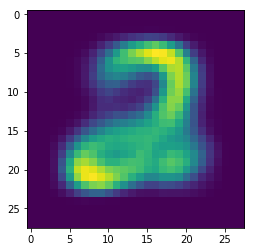

**********result at Epoch 61 Step 100*************


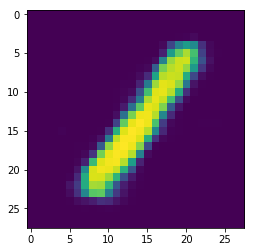

**********result at Epoch 61 Step 200*************


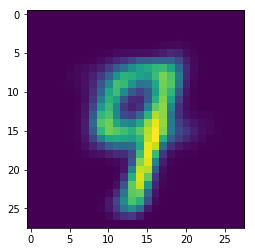

**********result at Epoch 61 Step 300*************


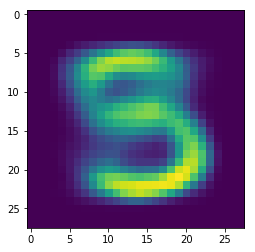

**********result at Epoch 61 Step 400*************


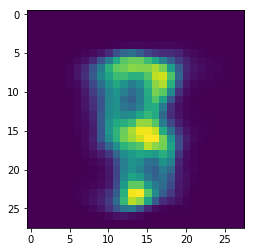

***epoch 62, step 0: total loss: 134.26222229003906, E_loss: 127.75434112548828, KL_loss:6.507883071899414
**********result at Epoch 62 Step 0*************


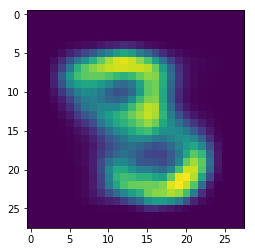

***epoch 62, step 50: total loss: 138.30758666992188, E_loss: 131.52210998535156, KL_loss:6.785477161407471
***epoch 62, step 100: total loss: 136.529296875, E_loss: 129.7895965576172, KL_loss:6.739694118499756
**********result at Epoch 62 Step 100*************


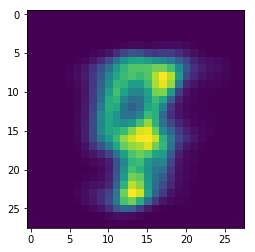

***epoch 62, step 150: total loss: 126.5877685546875, E_loss: 119.92391967773438, KL_loss:6.663846015930176
***epoch 62, step 200: total loss: 135.1217803955078, E_loss: 128.24789428710938, KL_loss:6.873891830444336
**********result at Epoch 62 Step 200*************


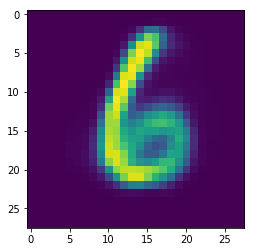

***epoch 62, step 250: total loss: 142.1399383544922, E_loss: 135.56503295898438, KL_loss:6.574910640716553
***epoch 62, step 300: total loss: 139.8549041748047, E_loss: 133.00328063964844, KL_loss:6.851617336273193
**********result at Epoch 62 Step 300*************


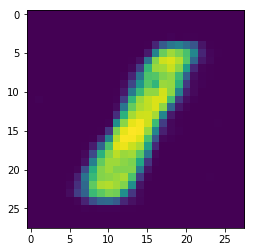

***epoch 62, step 350: total loss: 142.63890075683594, E_loss: 135.93539428710938, KL_loss:6.7034993171691895
***epoch 62, step 400: total loss: 138.81932067871094, E_loss: 132.22711181640625, KL_loss:6.592203617095947
**********result at Epoch 62 Step 400*************


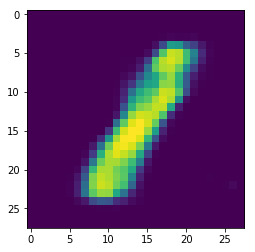

**********result at Epoch 63 Step 0*************


**********result at Epoch 63 Step 100*************


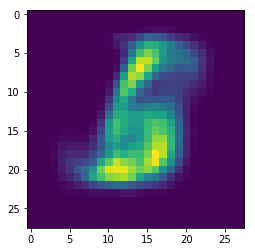

**********result at Epoch 63 Step 200*************


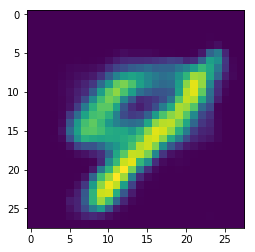

**********result at Epoch 63 Step 300*************


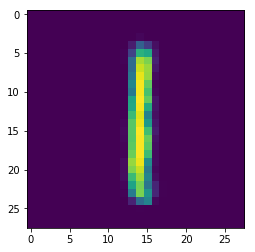

**********result at Epoch 63 Step 400*************


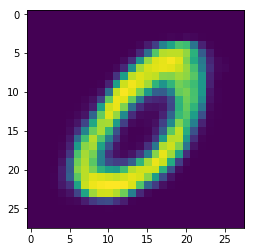

***epoch 64, step 0: total loss: 133.6107940673828, E_loss: 127.07211303710938, KL_loss:6.53868293762207
**********result at Epoch 64 Step 0*************


***epoch 64, step 50: total loss: 137.52976989746094, E_loss: 130.72930908203125, KL_loss:6.8004560470581055
***epoch 64, step 100: total loss: 137.24266052246094, E_loss: 130.46803283691406, KL_loss:6.774622917175293
**********result at Epoch 64 Step 100*************


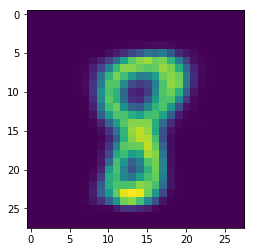

***epoch 64, step 150: total loss: 127.09127044677734, E_loss: 120.42084503173828, KL_loss:6.67042350769043
***epoch 64, step 200: total loss: 135.46897888183594, E_loss: 128.52708435058594, KL_loss:6.941887855529785
**********result at Epoch 64 Step 200*************


***epoch 64, step 250: total loss: 141.543212890625, E_loss: 135.05213928222656, KL_loss:6.491074562072754
***epoch 64, step 300: total loss: 139.30038452148438, E_loss: 132.48019409179688, KL_loss:6.820193290710449
**********result at Epoch 64 Step 300*************


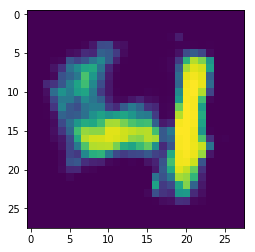

***epoch 64, step 350: total loss: 142.5611114501953, E_loss: 135.91903686523438, KL_loss:6.64207124710083
***epoch 64, step 400: total loss: 138.40237426757812, E_loss: 131.84078979492188, KL_loss:6.561580657958984
**********result at Epoch 64 Step 400*************


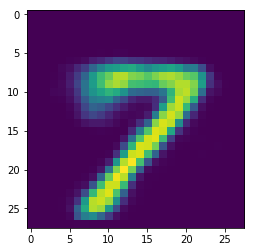

**********result at Epoch 65 Step 0*************


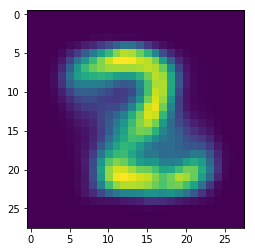

**********result at Epoch 65 Step 100*************


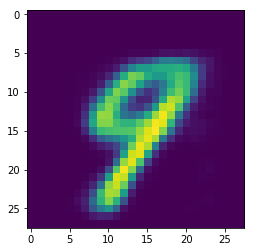

**********result at Epoch 65 Step 200*************


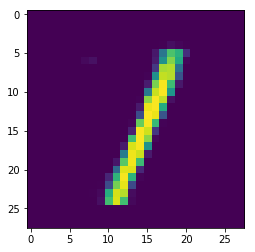

**********result at Epoch 65 Step 300*************


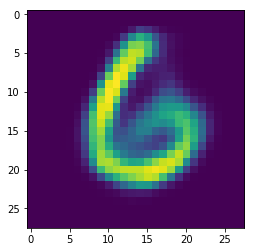

**********result at Epoch 65 Step 400*************


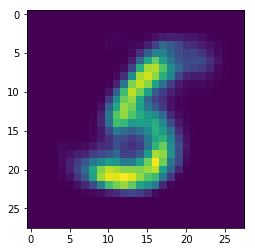

***epoch 66, step 0: total loss: 133.96043395996094, E_loss: 127.38615417480469, KL_loss:6.574280738830566
**********result at Epoch 66 Step 0*************


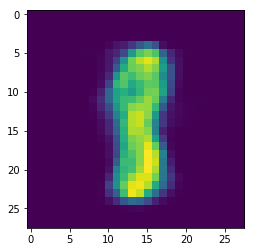

***epoch 66, step 50: total loss: 137.7322235107422, E_loss: 131.01104736328125, KL_loss:6.721177101135254
***epoch 66, step 100: total loss: 136.6152801513672, E_loss: 129.91134643554688, KL_loss:6.703937530517578
**********result at Epoch 66 Step 100*************


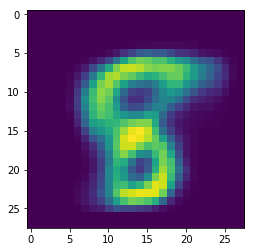

***epoch 66, step 150: total loss: 126.49192810058594, E_loss: 119.78207397460938, KL_loss:6.70985746383667
***epoch 66, step 200: total loss: 134.8785858154297, E_loss: 127.98509216308594, KL_loss:6.893500328063965
**********result at Epoch 66 Step 200*************


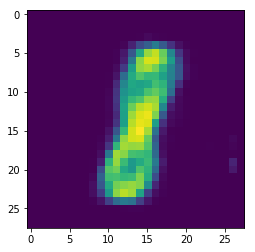

***epoch 66, step 250: total loss: 142.15927124023438, E_loss: 135.70248413085938, KL_loss:6.456789970397949
***epoch 66, step 300: total loss: 139.70338439941406, E_loss: 132.7823028564453, KL_loss:6.921074390411377
**********result at Epoch 66 Step 300*************


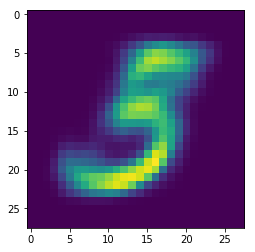

***epoch 66, step 350: total loss: 142.58682250976562, E_loss: 135.900390625, KL_loss:6.686427116394043
***epoch 66, step 400: total loss: 138.56781005859375, E_loss: 131.9393768310547, KL_loss:6.628436088562012
**********result at Epoch 66 Step 400*************


**********result at Epoch 67 Step 0*************


**********result at Epoch 67 Step 100*************


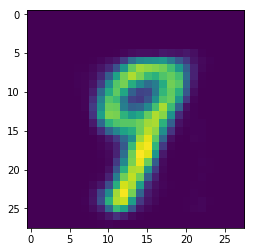

**********result at Epoch 67 Step 200*************


**********result at Epoch 67 Step 300*************


**********result at Epoch 67 Step 400*************


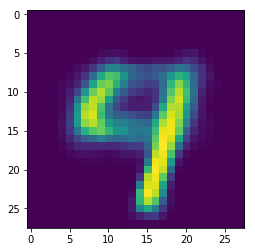

***epoch 68, step 0: total loss: 133.865478515625, E_loss: 127.21382141113281, KL_loss:6.651663303375244
**********result at Epoch 68 Step 0*************


***epoch 68, step 50: total loss: 137.62759399414062, E_loss: 130.8768310546875, KL_loss:6.750768661499023
***epoch 68, step 100: total loss: 136.2646026611328, E_loss: 129.55287170410156, KL_loss:6.711725234985352
**********result at Epoch 68 Step 100*************


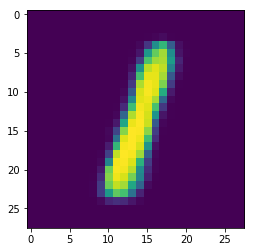

***epoch 68, step 150: total loss: 126.47078704833984, E_loss: 119.76758575439453, KL_loss:6.70320463180542
***epoch 68, step 200: total loss: 134.77891540527344, E_loss: 127.8743896484375, KL_loss:6.9045257568359375
**********result at Epoch 68 Step 200*************


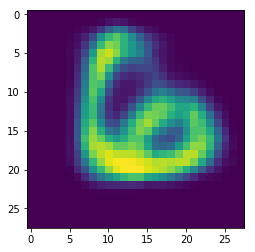

***epoch 68, step 250: total loss: 142.1171417236328, E_loss: 135.4508056640625, KL_loss:6.6663336753845215
***epoch 68, step 300: total loss: 140.59246826171875, E_loss: 133.64767456054688, KL_loss:6.944795608520508
**********result at Epoch 68 Step 300*************


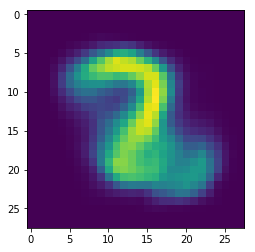

***epoch 68, step 350: total loss: 142.19297790527344, E_loss: 135.4793243408203, KL_loss:6.713654518127441
***epoch 68, step 400: total loss: 138.7071533203125, E_loss: 132.0968780517578, KL_loss:6.610281467437744
**********result at Epoch 68 Step 400*************


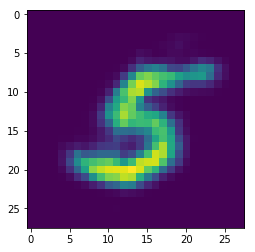

**********result at Epoch 69 Step 0*************


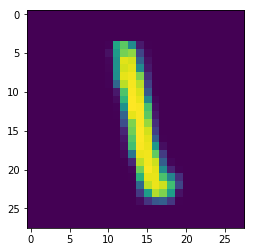

**********result at Epoch 69 Step 100*************


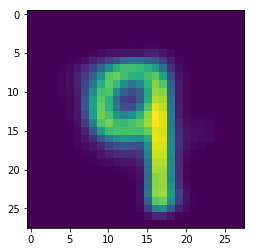

**********result at Epoch 69 Step 200*************


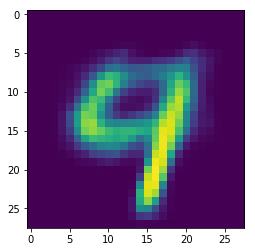

**********result at Epoch 69 Step 300*************


**********result at Epoch 69 Step 400*************


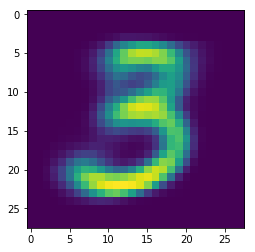

***epoch 70, step 0: total loss: 134.1602325439453, E_loss: 127.51699829101562, KL_loss:6.6432414054870605
**********result at Epoch 70 Step 0*************


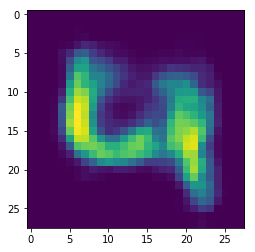

***epoch 70, step 50: total loss: 137.08990478515625, E_loss: 130.34185791015625, KL_loss:6.748048305511475
***epoch 70, step 100: total loss: 136.69602966308594, E_loss: 130.03506469726562, KL_loss:6.6609721183776855
**********result at Epoch 70 Step 100*************


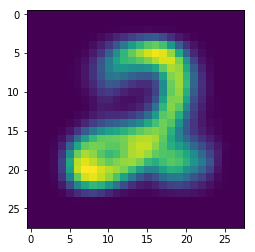

***epoch 70, step 150: total loss: 126.38971710205078, E_loss: 119.75787353515625, KL_loss:6.631845474243164
***epoch 70, step 200: total loss: 134.17649841308594, E_loss: 127.22745513916016, KL_loss:6.949038982391357
**********result at Epoch 70 Step 200*************


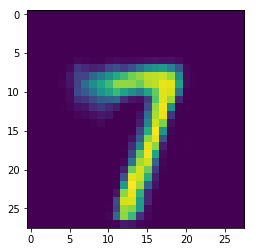

***epoch 70, step 250: total loss: 141.6292724609375, E_loss: 135.13552856445312, KL_loss:6.493737697601318
***epoch 70, step 300: total loss: 139.28286743164062, E_loss: 132.40151977539062, KL_loss:6.881340980529785
**********result at Epoch 70 Step 300*************


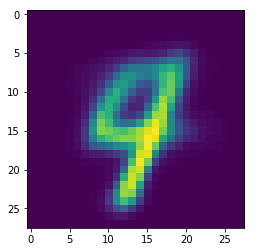

***epoch 70, step 350: total loss: 142.51080322265625, E_loss: 135.74798583984375, KL_loss:6.762813568115234
***epoch 70, step 400: total loss: 138.871337890625, E_loss: 132.2905731201172, KL_loss:6.580757141113281
**********result at Epoch 70 Step 400*************


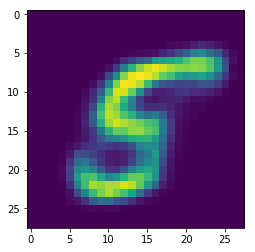

**********result at Epoch 71 Step 0*************


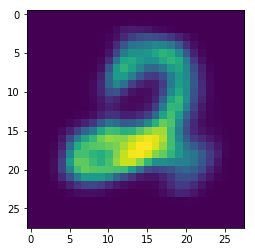

**********result at Epoch 71 Step 100*************


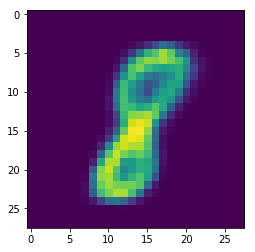

**********result at Epoch 71 Step 200*************


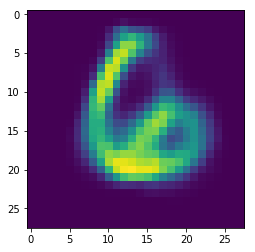

**********result at Epoch 71 Step 300*************


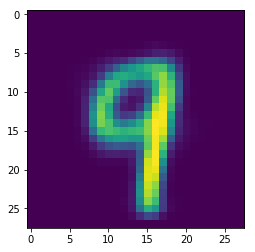

**********result at Epoch 71 Step 400*************


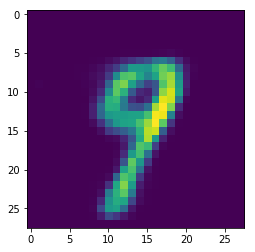

***epoch 72, step 0: total loss: 133.75216674804688, E_loss: 126.97014617919922, KL_loss:6.782026290893555
**********result at Epoch 72 Step 0*************


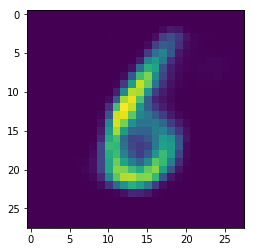

***epoch 72, step 50: total loss: 136.36630249023438, E_loss: 129.64385986328125, KL_loss:6.722445487976074
***epoch 72, step 100: total loss: 135.41238403320312, E_loss: 128.63658142089844, KL_loss:6.775806427001953
**********result at Epoch 72 Step 100*************


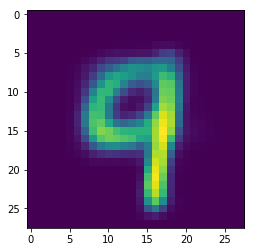

***epoch 72, step 150: total loss: 126.60832214355469, E_loss: 119.89166259765625, KL_loss:6.71666145324707
***epoch 72, step 200: total loss: 134.30172729492188, E_loss: 127.46757507324219, KL_loss:6.834156513214111
**********result at Epoch 72 Step 200*************


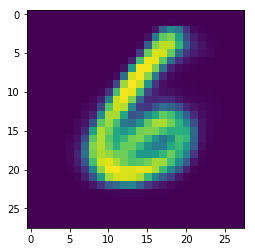

***epoch 72, step 250: total loss: 142.06507873535156, E_loss: 135.54222106933594, KL_loss:6.522855758666992
***epoch 72, step 300: total loss: 139.37594604492188, E_loss: 132.52499389648438, KL_loss:6.850946426391602
**********result at Epoch 72 Step 300*************


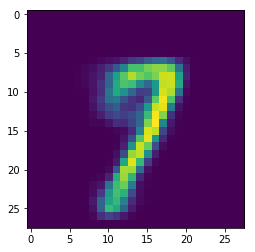

***epoch 72, step 350: total loss: 142.65518188476562, E_loss: 135.9029083251953, KL_loss:6.752276420593262
***epoch 72, step 400: total loss: 138.43356323242188, E_loss: 131.86663818359375, KL_loss:6.566929340362549
**********result at Epoch 72 Step 400*************


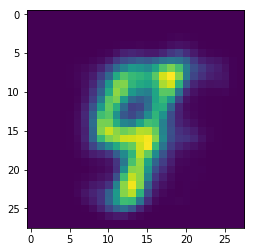

**********result at Epoch 73 Step 0*************


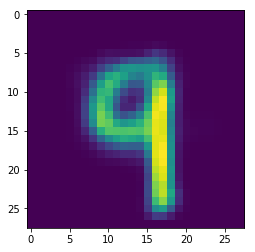

**********result at Epoch 73 Step 100*************


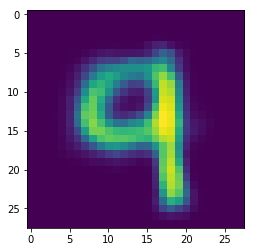

**********result at Epoch 73 Step 200*************


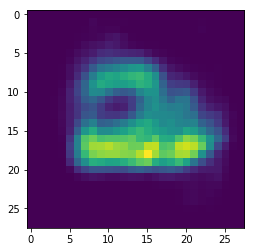

**********result at Epoch 73 Step 300*************


**********result at Epoch 73 Step 400*************


***epoch 74, step 0: total loss: 133.44871520996094, E_loss: 126.8128433227539, KL_loss:6.635869979858398
**********result at Epoch 74 Step 0*************


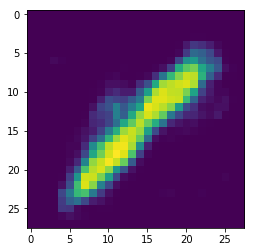

***epoch 74, step 50: total loss: 137.3172607421875, E_loss: 130.52789306640625, KL_loss:6.789364337921143
***epoch 74, step 100: total loss: 135.37037658691406, E_loss: 128.69422912597656, KL_loss:6.676143646240234
**********result at Epoch 74 Step 100*************


***epoch 74, step 150: total loss: 126.52527618408203, E_loss: 119.85768127441406, KL_loss:6.667598247528076
***epoch 74, step 200: total loss: 134.80909729003906, E_loss: 127.88369750976562, KL_loss:6.925398349761963
**********result at Epoch 74 Step 200*************


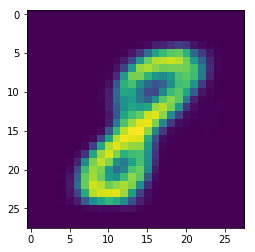

***epoch 74, step 250: total loss: 141.71389770507812, E_loss: 135.06253051757812, KL_loss:6.651365756988525
***epoch 74, step 300: total loss: 140.27825927734375, E_loss: 133.40768432617188, KL_loss:6.870571136474609
**********result at Epoch 74 Step 300*************


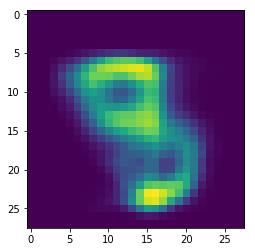

***epoch 74, step 350: total loss: 141.5806884765625, E_loss: 134.7876739501953, KL_loss:6.793015480041504
***epoch 74, step 400: total loss: 138.08460998535156, E_loss: 131.44155883789062, KL_loss:6.643057346343994
**********result at Epoch 74 Step 400*************


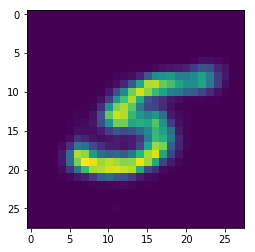

**********result at Epoch 75 Step 0*************


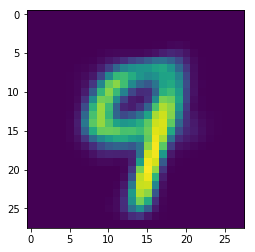

**********result at Epoch 75 Step 100*************


**********result at Epoch 75 Step 200*************


**********result at Epoch 75 Step 300*************


**********result at Epoch 75 Step 400*************


***epoch 76, step 0: total loss: 133.43716430664062, E_loss: 126.73583984375, KL_loss:6.701326847076416
**********result at Epoch 76 Step 0*************


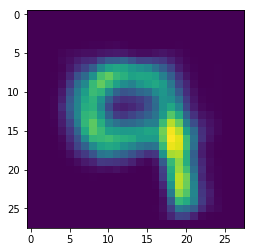

***epoch 76, step 50: total loss: 136.2239990234375, E_loss: 129.4482421875, KL_loss:6.775764465332031
***epoch 76, step 100: total loss: 135.6945343017578, E_loss: 128.98504638671875, KL_loss:6.709489345550537
**********result at Epoch 76 Step 100*************


***epoch 76, step 150: total loss: 126.30341339111328, E_loss: 119.56561279296875, KL_loss:6.737797260284424
***epoch 76, step 200: total loss: 134.40408325195312, E_loss: 127.4488525390625, KL_loss:6.95522403717041
**********result at Epoch 76 Step 200*************


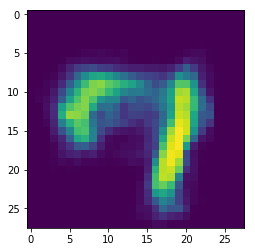

***epoch 76, step 250: total loss: 142.65293884277344, E_loss: 136.11756896972656, KL_loss:6.535368919372559
***epoch 76, step 300: total loss: 139.63946533203125, E_loss: 132.68370056152344, KL_loss:6.955770015716553
**********result at Epoch 76 Step 300*************


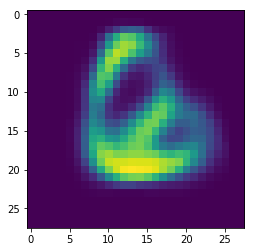

***epoch 76, step 350: total loss: 142.1085662841797, E_loss: 135.37786865234375, KL_loss:6.7306928634643555
***epoch 76, step 400: total loss: 138.00802612304688, E_loss: 131.37612915039062, KL_loss:6.631896495819092
**********result at Epoch 76 Step 400*************


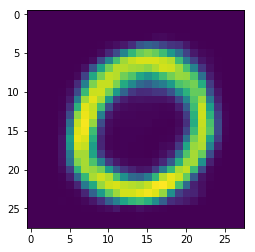

**********result at Epoch 77 Step 0*************


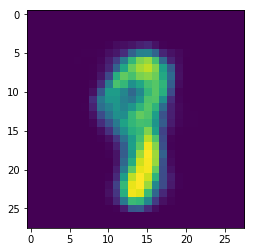

**********result at Epoch 77 Step 100*************


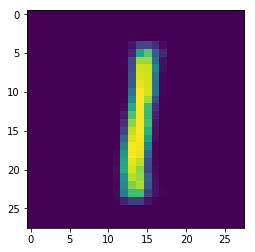

**********result at Epoch 77 Step 200*************


**********result at Epoch 77 Step 300*************


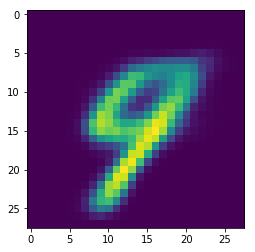

**********result at Epoch 77 Step 400*************


***epoch 78, step 0: total loss: 133.24871826171875, E_loss: 126.51850891113281, KL_loss:6.730209827423096
**********result at Epoch 78 Step 0*************


***epoch 78, step 50: total loss: 135.9535369873047, E_loss: 129.16140747070312, KL_loss:6.792132377624512
***epoch 78, step 100: total loss: 135.76425170898438, E_loss: 129.01272583007812, KL_loss:6.751525402069092
**********result at Epoch 78 Step 100*************


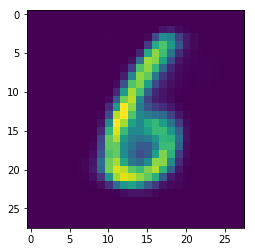

***epoch 78, step 150: total loss: 126.832275390625, E_loss: 120.01448059082031, KL_loss:6.81779670715332
***epoch 78, step 200: total loss: 134.38137817382812, E_loss: 127.4513168334961, KL_loss:6.9300665855407715
**********result at Epoch 78 Step 200*************


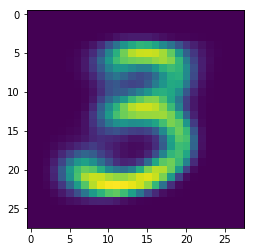

***epoch 78, step 250: total loss: 141.30322265625, E_loss: 134.76776123046875, KL_loss:6.535459518432617
***epoch 78, step 300: total loss: 139.66001892089844, E_loss: 132.73617553710938, KL_loss:6.923840522766113
**********result at Epoch 78 Step 300*************


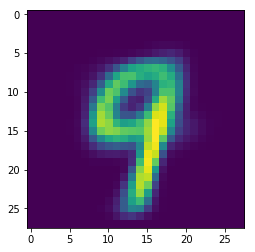

***epoch 78, step 350: total loss: 141.7091827392578, E_loss: 134.9417724609375, KL_loss:6.7674174308776855
***epoch 78, step 400: total loss: 137.78225708007812, E_loss: 131.17697143554688, KL_loss:6.605278015136719
**********result at Epoch 78 Step 400*************


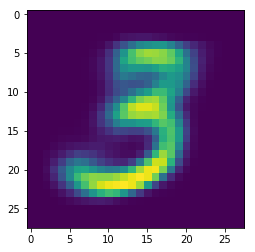

**********result at Epoch 79 Step 0*************


**********result at Epoch 79 Step 100*************


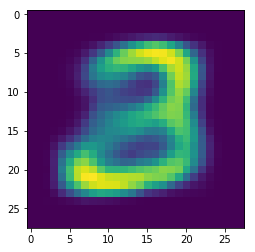

**********result at Epoch 79 Step 200*************


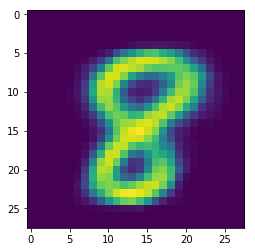

**********result at Epoch 79 Step 300*************


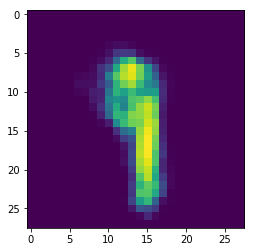

**********result at Epoch 79 Step 400*************


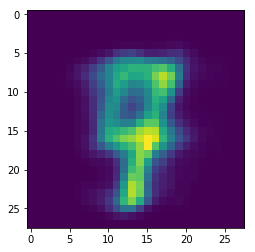

In [5]:
train_f=trains/255
myvae=VAE(batch_size=100,z_size=2)
train(train_f,myvae,80)

We train 3 different VAE, each with a different latent coder size. Based on the results, the model with latent code size 20 outperforms the other 2 models while model with latent code size 100 arise the worst results.

In [11]:
new=VAE()
cost,x_,E_loss,KL_loss=new.cost(reuse=True)
saver=tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,os.path.join(os.getcwd(),'B_VAE.ckpt'))
    x_reconstruct=sess.run(x_,{new.X:train_f[:1]})

INFO:tensorflow:Restoring parameters from C:\Users\jiema\Documents\VAE\B_VAE.ckpt


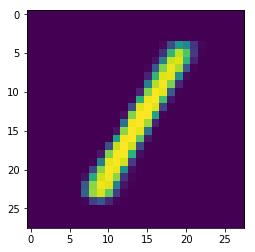

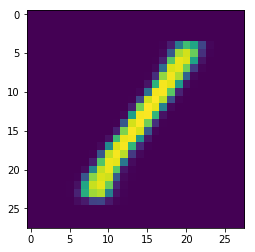

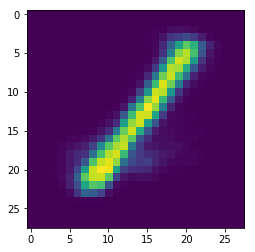

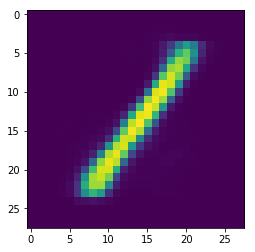

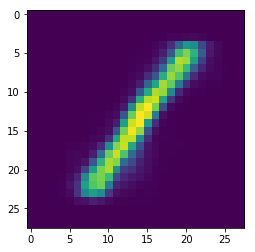

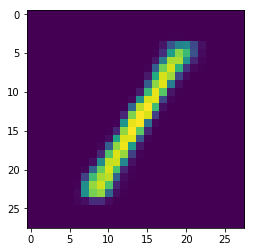

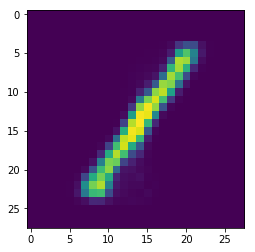

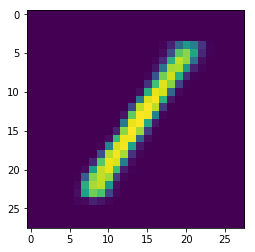

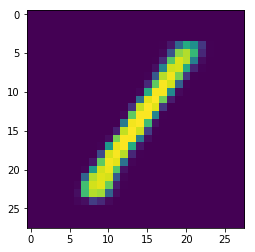

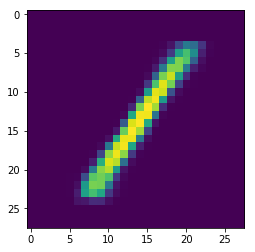

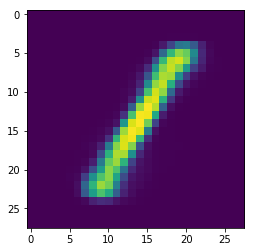

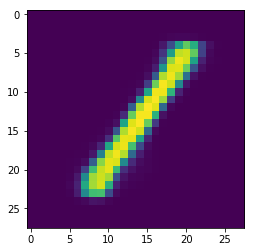

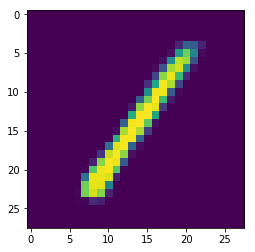

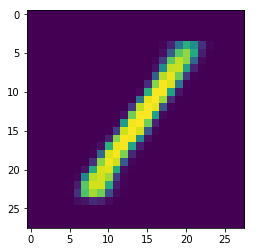

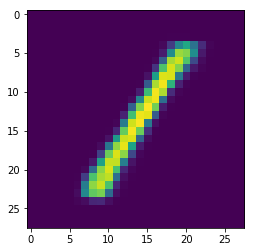

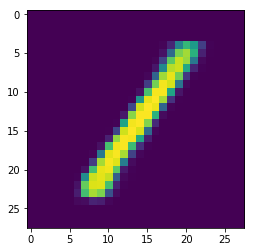

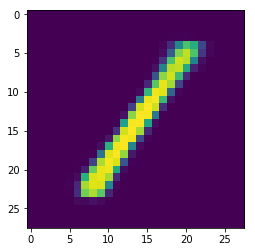

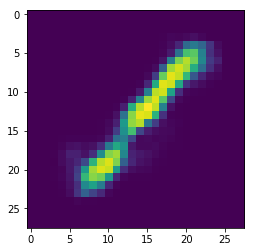

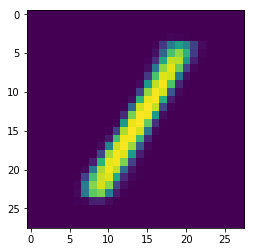

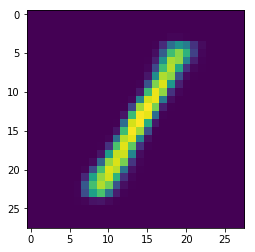

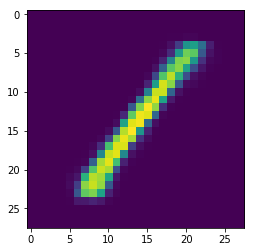

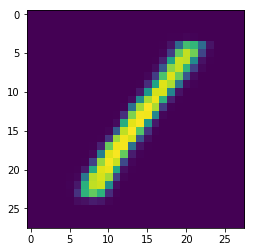

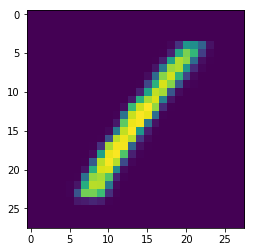

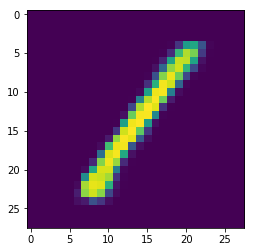

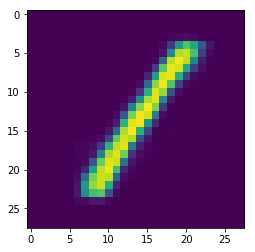

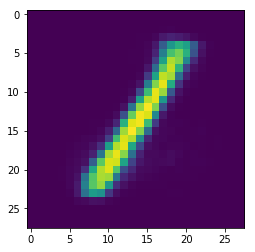

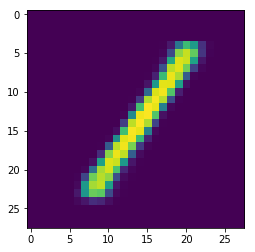

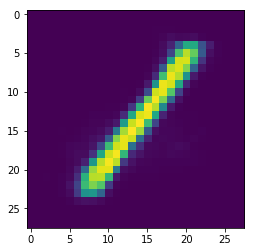

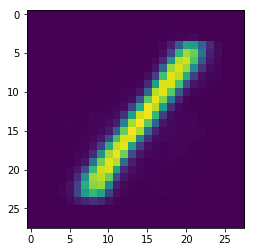

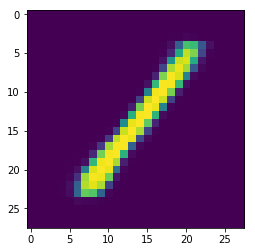

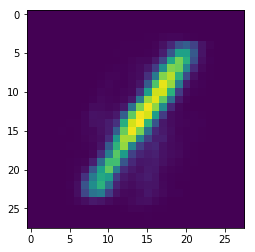

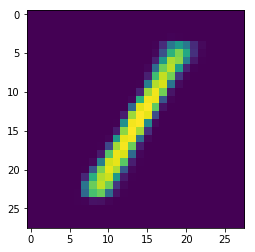

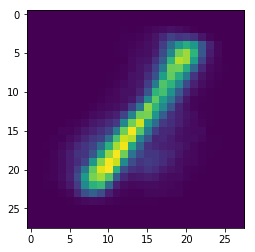

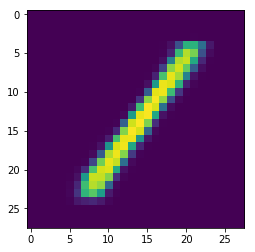

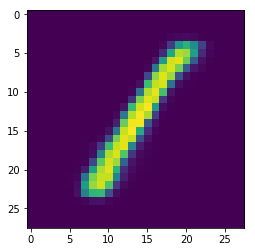

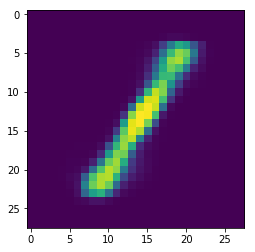

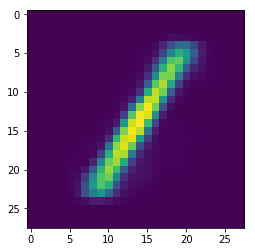

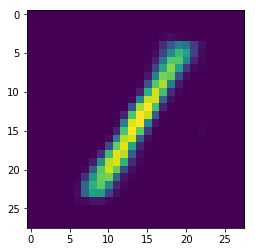

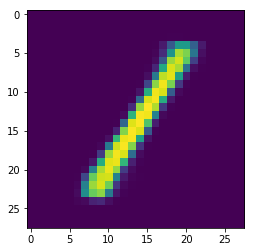

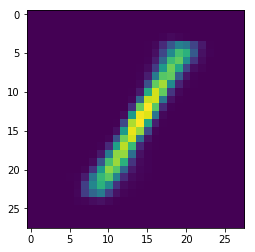

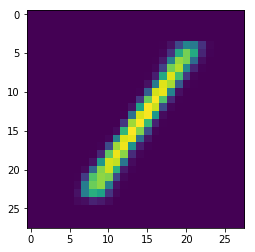

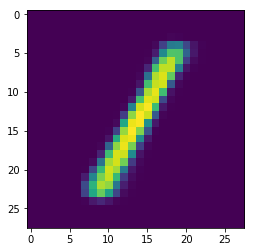

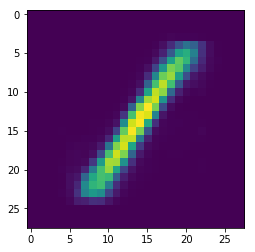

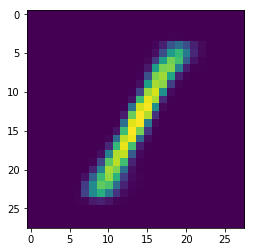

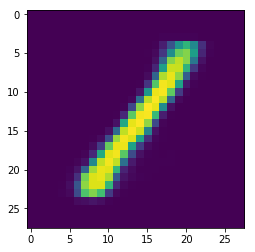

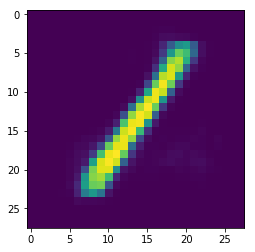

In [14]:
x_reconstruct.shape
for i in range(len(x_reconstruct)):
    img=x_reconstruct[i]
    plt.imshow(img.reshape(28,28))
    plt.show()

INFO:tensorflow:Restoring parameters from C:\Users\jiema\Documents\VAE\B_2_VAE.ckpt


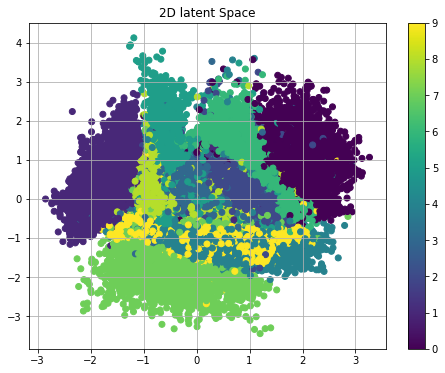

In [14]:
train_f=trains/255
new=VAE(batch_size=train_f.shape[0],z_size=2)
z_mean,z_var=new.Encoder(reuse=True)
saver=tf.train.Saver()
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,os.path.join(os.getcwd(),'B_2_VAE.ckpt'))
    z_m=sess.run(z_mean,{new.X:train_f})
plt.figure(figsize=(8,6))
plt.scatter(z_m[:,0],z_m[:,1],c=labels.reshape(len(labels)))
plt.title('2D latent Space')
plt.colorbar()
plt.grid()
plt.show()

This is the visilization of the distribution of the latent code with size 2. It is quite clear that the latent codes from the same digit images cluster while latent codes from different digit images are geometrically seperated 

INFO:tensorflow:Restoring parameters from C:\Users\jiema\Documents\VAE\B_2_VAE.ckpt


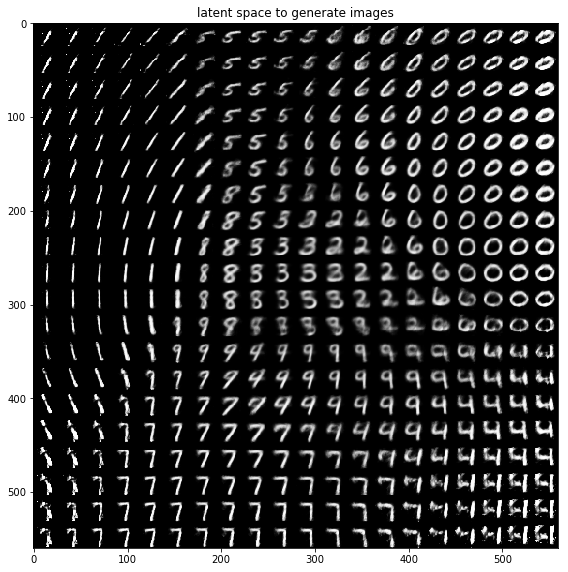

In [16]:
#We sample a group of 2-D latent codes from the uniform distribution to generate images. 
new=VAE(batch_size=1,z_size=2)
output=new.generate(reuse=False)
nx=ny=20
x_values=np.linspace(-3,3,nx)
y_values=np.linspace(-3,3,ny)
canvas=np.empty((28*ny,28*nx))
saver=tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,os.path.join(os.getcwd(),'B_2_VAE.ckpt'))
    for i,yi in enumerate(x_values):
        for j,xi in enumerate(y_values):
            z_mu=np.array([[xi,yi]]*new.batch_size)
            x_mean=sess.run(output,{new.Z:z_mu})
            canvas[(nx-i-1)*28:(nx-i)*28,j*28:(j+1)*28]=x_mean[0].reshape(28,28)

plt.figure(figsize=(8,10))
Xi,Yi=np.meshgrid(x_values,y_values)
plt.imshow(canvas,origin='upper',cmap='gray')
plt.title('latent space to generate images')
plt.tight_layout()  
plt.show()